# **neuroAI for biomedical engineering**

A. Lozano 03/03/2025

In [ ]:
# 1. Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
# Import required functions
from skimage.filters import gabor_kernel
from skimage.transform import resize
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D


# Natural images

In [ ]:
n# 2. Download a simple natural images dataset (CIFAR-10) and select a few images
num_images = 5000

(x_train, _), (x_test, _) = cifar10.load_data()
images = np.concatenate([x_train, x_test], axis=0)
subset_idx = np.random.choice(images.shape[0],num_images, replace=False)

#subset_idx = images[0:num_images]
subset_idx = np.arange(num_images)
subset_images = images[subset_idx]
print(f"The shape of the subset_images array is: {subset_images.shape}")

NameError: name 'n' is not defined

NameError: name 'subset_images' is not defined

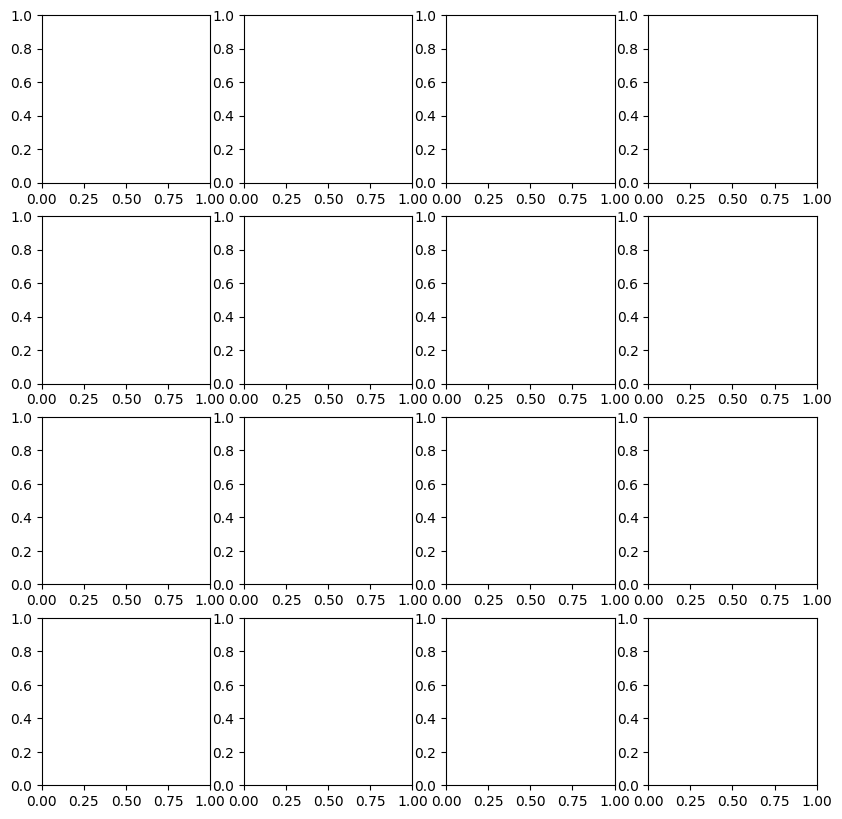

In [ ]:
# 3. Visualize a few random images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for ax in axs.flat:
    idx = np.random.randint(0, subset_images.shape[0])
    ax.imshow(subset_images[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

# The visual system as an information encoder

In [ ]:
from IPython.display import HTML

# Embed the YouTube video
video_url = "https://www.youtube.com/embed/8VdFf3egwfg"
HTML(f'<iframe width="560" height="315" src="{video_url}" frameborder="0" allowfullscreen></iframe>')


/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# V1 cells as features detectors

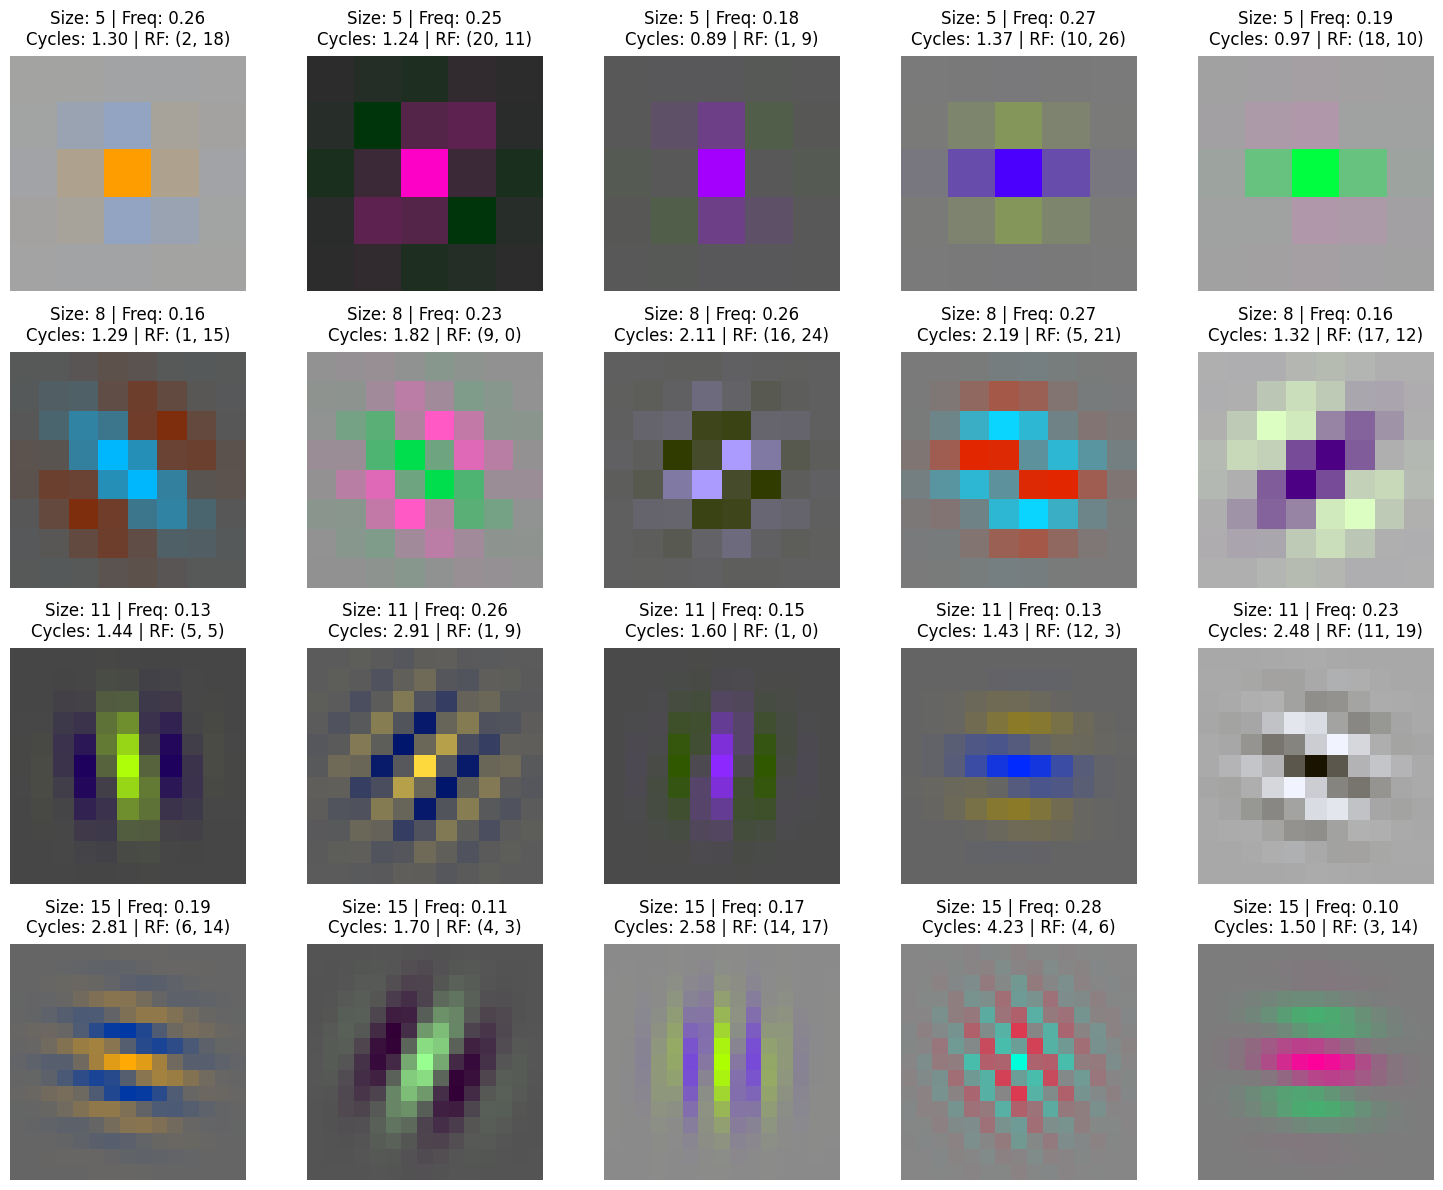

In [ ]:
# Parameters
n_v1_cells = 20
n_sizes = 4
sizes = [5, 8, 11, 15]  # kernel sizes: 5x5, 8x8, 11x11, 15x15
frequency_range = (0.1, 0.3)  # cycles per pixel
img_height, img_width = 32, 32  # assuming CIFAR-10-like images

def generate_rgb_gabor_kernel(size, frequency_range, img_shape):
    # Sample frequency and orientation
    frequency = np.random.uniform(*frequency_range)
    theta = np.random.uniform(0, np.pi)
    sigma = size / 4.0  # sigma proportional to kernel size
    # Generate a 2D Gabor kernel (real part)
    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
    # Resize the kernel to the desired size
    kernel_resized = resize(kernel, (size, size), anti_aliasing=True)
    # Apply random RGB weights to form an RGB kernel
    color_weights = np.random.randn(3)
    kernel_rgb = np.stack([kernel_resized * color_weights[c] for c in range(3)], axis=-1)

    # Generate RF coordinates: top-left corner so that the SxS patch fits in the image
    max_x = img_shape[1] - size
    max_y = img_shape[0] - size
    x_coord = np.random.randint(0, max_x + 1)
    y_coord = np.random.randint(0, max_y + 1)
    coords = (x_coord, y_coord)

    return kernel_rgb, frequency, size, coords

# Generate V1 cells: distribute cells equally among the defined sizes
v1_cells = []
cells_per_size = n_v1_cells // n_sizes

for size in sizes:
    for _ in range(cells_per_size):
        v1_cells.append(generate_rgb_gabor_kernel(size, frequency_range, (img_height, img_width)))

# Function to normalize image for visualization
def norm_img(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# Visualize the generated kernels with titles showing size, frequency, cycles, and RF coordinates
cols = 5
rows = len(v1_cells) // cols + (len(v1_cells) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axs = axs.flatten()

for ax, (kernel, freq, size, coords) in zip(axs, v1_cells):
    cycles = freq * size  # approximate number of cycles across the kernel
    ax.imshow(norm_img(kernel))
    ax.set_title(f"Size: {size} | Freq: {freq:.2f}\nCycles: {cycles:.2f} | RF: {coords}",
                 fontsize=12, pad=8)
    ax.axis('off')

# Hide any unused subplots
for ax in axs[len(v1_cells):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# V1 cells and excitation / inhibition kernels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("subset_images shape:", subset_images.shape)  # Expected: (1000, 32, 32, 3)
print("subset_images dtype:", subset_images.dtype)
print("First image min, max:", np.min(subset_images[0]), np.max(subset_images[0]))

# Convert images to float (keeping them in 0-255 range)
subset_images_float = np.array([img.astype(np.float32) for img in subset_images])
print("After conversion to float, first image min, max:",
      np.min(subset_images_float[0]), np.max(subset_images_float[0]))

# --- Debugging v1_cells (V1 Kernels) ---
if 'v1_cells' in globals():
    print("v1_cells is defined. Total kernels:", len(v1_cells))
    # Print info for the first 3 kernels
    for i in range(min(3, len(v1_cells))):
        kernel, freq, size, coords = v1_cells[i]
        print(f"Kernel {i}: shape = {kernel.shape}, min = {np.min(kernel):.3f}, max = {np.max(kernel):.3f}, "
              f"freq = {freq:.3f}, size = {size}, coords = {coords}")
else:
    print("v1_cells is not defined. Please define v1_cells with kernels.")

NEURONS_TO_PLOT = [4,10,13,17,18]
# --- Optionally, Display Debug Panels ---
if 'v1_cells' in globals():
    for n in NEURONS_TO_PLOT:
        # Use a kernel from v1_cells (e.g., the nth kernel)
        kernel, freq, size, coords = v1_cells[n]

        # Panel 2: Normalize the kernel for display (using your norm_img function)
        kernel_norm = norm_img(kernel)

        # Panel 3 & 4: Compute the per-pixel mean (across channels) of the kernel
        kernel_mean = np.mean(kernel, axis=-1)

        # Create a figure with 4 panels in a row
        plt.figure(figsize=(16, 4))

        # Panel 2: Display the normalized kernel
        plt.subplot(1, 4, 1)
        plt.imshow(kernel_norm, interpolation='nearest')
        plt.title(f"Kernel {n} (normalized)")
        plt.axis("off")

        # Panel 3: Display the kernel mean in grayscale
        plt.subplot(1, 4, 2)
        plt.imshow(kernel_mean, cmap="gray", interpolation='nearest')
        plt.title(f"Kernel {n} Mean (gray)")
        plt.axis("off")

        # Panel 4: Display the kernel mean with seismic colormap
        plt.subplot(1, 4, 3)
        img = plt.imshow(kernel_mean, cmap="seismic", interpolation='nearest')
        plt.colorbar(img, fraction=0.046, pad=0.04)  # Add colorbar
        plt.title(f"Kernel {n} Mean (seismic)")
        plt.axis("off")

        # Panel 5: 3D plot
        ax = plt.subplot(1, 4, 4, projection='3d')

        # Define the grid for the 3D plot
        x = np.arange(kernel_mean.shape[0])
        y = np.arange(kernel_mean.shape[1])
        x, y = np.meshgrid(x, y)

        # Plot the surface
        surf = ax.plot_surface(x, y, kernel_mean, cmap='seismic', edgecolor='none')

        # Add a color bar which maps values to colors
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        # Set the view angle
        ax.view_init(elev=30, azim=45)  # You can adjust elev and azim for different view angles

        # Set labels
        ax.set_title(f"3D Kernel {n} Mean (Seismic)")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Mean Value')

        plt.tight_layout()
        plt.show()


NameError: name 'subset_images' is not defined

# V1 cells have receptive fields

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Utility Function ---
def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# --- Selected Neuron and Image Extraction ---
selected_neuron = 15 # arbitrarily defined
# Assume v1_cells is already defined from a previous code snippet.
# Each element in v1_cells is a tuple: (kernel_rgb, frequency, size, coords)
selected_kernel, selected_freq, selected_size, selected_coords = v1_cells[selected_neuron]
# Normalize the selected kernel for visualization
selected_kernel_norm = norm_img(selected_kernel)

# --- Prepare 25 Images for 5x5 Grid ---
# Convert images to float in [0,1]
images_5x5 = [img.astype(np.float32) / 255.0 for img in subset_images[:25]]

# --- Get RF Coordinates ---
x_rf, y_rf = selected_coords  # RF coordinates in a 32x32 image

# --- Create 5x5 Grid Figure with Kernel Overlaid ---
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axs.flatten(), images_5x5):
    # Display the full 32x32 image with transparency (alpha=0.3)
    ax.imshow(img, alpha=0.9, origin='upper')
    # Overlay the normalized kernel at its RF.
    # The extent is defined as [left, right, bottom, top]:
    #   left = x_rf, right = x_rf + selected_size,
    #   bottom = y_rf, top = y_rf + selected_size.
    ax.imshow(
        selected_kernel_norm,
        alpha=1,
        extent=[x_rf, x_rf + selected_size, y_rf, y_rf + selected_size],
        interpolation='none',
        origin='upper'
    )
    # Set axis limits to enforce a 32x32 pixel coordinate system.
    ax.set_xlim(0, 32)
    ax.set_ylim(32, 0)  # y-axis reversed so that 0 is at the top
    ax.axis('off')

    # Add black lines at the center of the image
    ax.axvline(x=16, color='black', linewidth=2)
    ax.axhline(y=16, color='black', linewidth=2)

    # Add a red dot in the center
    ax.plot(16, 16, 'ro')  # Center of 32x32 image

    # Add concentric circles every 5 pixels
    for radius in range(5, 32, 5):
        circle = plt.Circle((16, 16), radius, color='black', fill=False, linestyle='--', linewidth=0.5)
        ax.add_artist(circle)

plt.suptitle("Receptive field of a neuron", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NameError: name 'subset_images' is not defined

# Multiple V1 neurons and their RFs

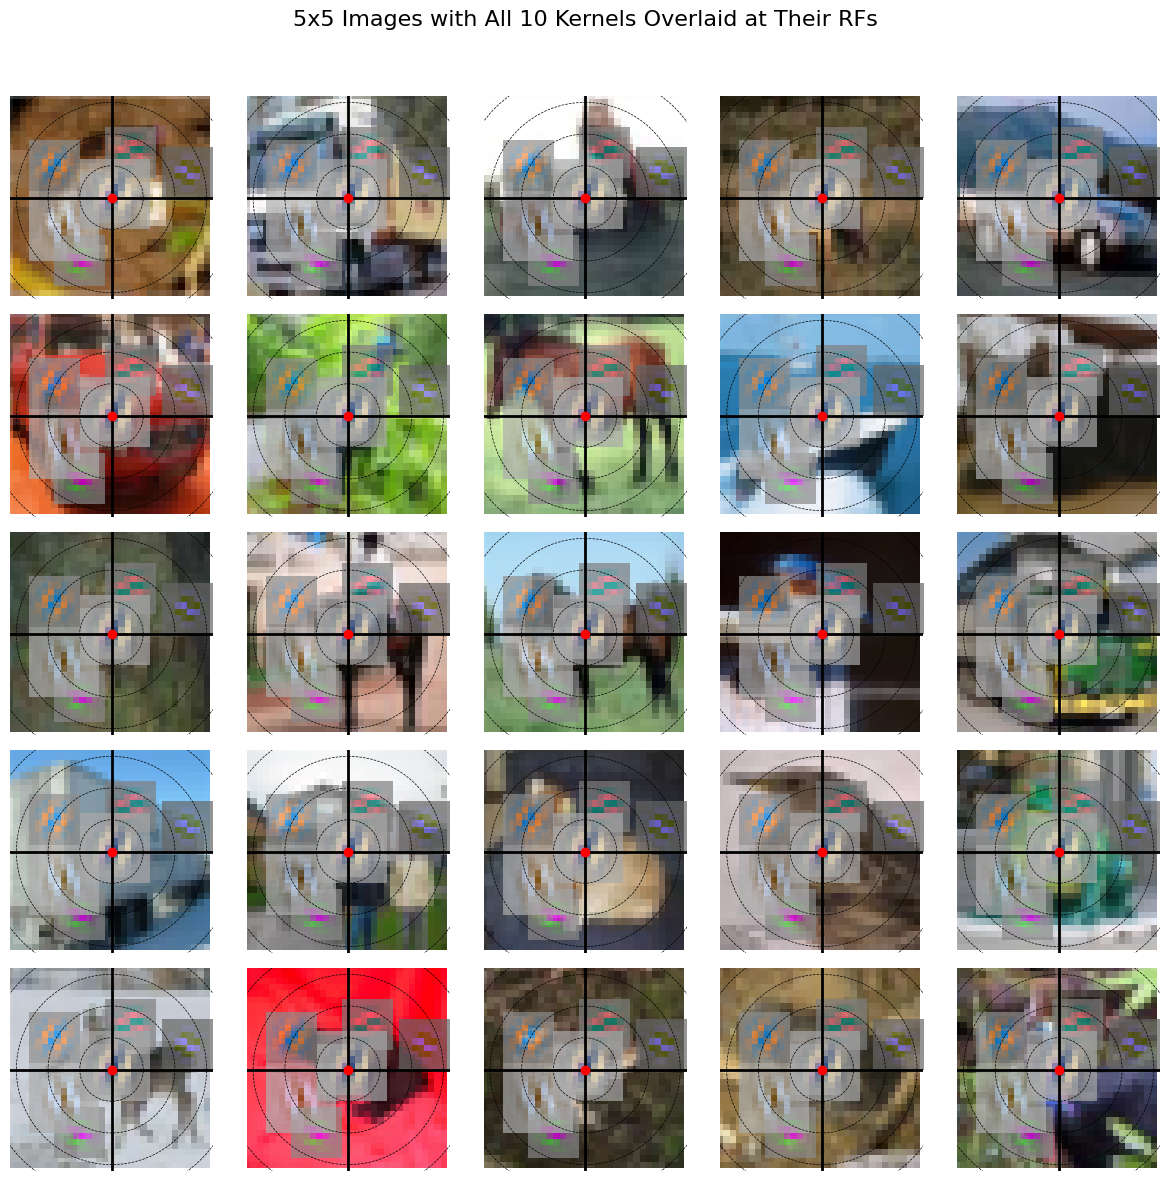

In [ ]:

# --- Utility Function ---
def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# Convert images to float and scale them to [0,1]
subset_images_plot = np.array([img.astype(np.float32) / 255.0 for img in subset_images])
H, W, C = subset_images[0].shape  # expected to be (32, 32, 3)

# --- Assume v1_cells is defined ---
# Each element in v1_cells is a tuple: (kernel_rgb, frequency, size, coords)
# For this snippet, we assume v1_cells already exists.
selected_kernels = v1_cells[5:12]

# --- Prepare 25 Images for a 5x5 Grid ---
images_5x5 = [img for img in subset_images_plot[:25]]

# --- Create a 5x5 Figure and Overlay All 10 Kernels on Each Image ---
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()

for ax, img in zip(axs, images_5x5):
    # Display the base image using the [0,1] range
    ax.imshow(img, vmin=0, vmax=1, origin='upper')
    # Overlay each of the 10 kernels (normalized to [0,1])
    for kernel_tuple in selected_kernels:
        kernel, freq, size, coords = kernel_tuple
        kernel_disp = norm_img(kernel)  # Normalize kernel to [0,1]
        x_rf, y_rf = coords  # RF coordinates (top-left corner) in the 32x32 image
        # Define the extent so that the kernel appears at its natural size:
        # extent = [left, right, top, bottom]
        extent = [x_rf, x_rf + size, y_rf, y_rf + size]
        ax.imshow(kernel_disp, vmin=0, vmax=1, alpha=0.7,
                  extent=extent, interpolation='none', origin='upper')
    # Fix the axis to the image coordinate system (32x32 pixels)
    ax.set_xlim(0, 32)
    ax.set_ylim(32, 0)  # Inverted y-axis so that (0,0) is top-left
    ax.axis('off')

    # Add black lines at the center of the image
    ax.axvline(x=16, color='black', linewidth=2)
    ax.axhline(y=16, color='black', linewidth=2)

    # Add a red dot in the center
    ax.plot(16, 16, 'ro')  # Center of 32x32 image

    # Add concentric circles every 5 pixels
    for radius in range(5, 32, 5):
        circle = plt.Circle((16, 16), radius, color='black', fill=False, linestyle='--', linewidth=0.5)
        ax.add_artist(circle)

plt.suptitle("5x5 Images with All 10 Kernels Overlaid at Their RFs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Simulating a neuroscience experiment

In [ ]:

# --- Parameters (in ms) ---
N = 4                  # Number of image trials
trial_time = 200       # Duration each image is shown (ms)
intertrial_time = 500  # Duration of gray background (ms)

# --- Compute Segment Widths ---
trial_width = W  # image is displayed at its original width (32 pixels)
gray_width = int(round((intertrial_time / trial_time) * trial_width))

# Create a gray patch (using mid-gray 0.5)
gray_patch = np.ones((H, gray_width, 3), dtype=np.float32) * 0.5

selected_images = subset_images[:N] / 255.0


# --- Build the Timeline ---
segments = [gray_patch]  # initial gray period
trial_positions = []     # Store positions for marking the image display periods
intertrial_positions = []  # Store positions for marking intertrial periods

current_x = gray_width  # initial gray period occupies [0, gray_width]
for img in selected_images:
    trial_positions.append((current_x, current_x + trial_width))  # Mark image display period
    current_x += trial_width
    intertrial_positions.append((current_x, current_x + gray_width))  # Mark intertrial period
    current_x += gray_width

# Concatenate segments: initial gray period + (for each trial: image then gray period)
timeline_image = np.concatenate(
    [gray_patch] + [seg for i in range(N) for seg in (selected_images[i], gray_patch)],
    axis=1
)

# --- Time Axis Conversion ---
ms_per_pixel = trial_time / trial_width
seconds_per_pixel = ms_per_pixel / 1000.0   # Convert ms to seconds
total_pixels = timeline_image.shape[1]
total_time_sec = total_pixels * seconds_per_pixel

# --- Plot the Timeline ---
fig, ax = plt.subplots(figsize=(16, 4), dpi=200)
ax.imshow(timeline_image, vmin=0, vmax=1, interpolation='nearest')
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Pixels", fontsize=14)

# Convert pixel positions to time in seconds for x-ticks
xticks = np.linspace(0, total_pixels, 6)  # 6 evenly spaced ticks
xticklabels = [f"{(x * seconds_per_pixel):.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# y-offset for horizontal annotation bars above the timeline
y_offset = -35  # Offset above the images

# Add red horizontal bar for the initial gray period (first intertrial)
ax.plot([0, gray_width], [H + y_offset, H + y_offset], 'black', linewidth=3)
ax.text(gray_width / 2, H + y_offset - 3, "Intertrial", color='black', fontsize=12, ha='center')

# Add red horizontal bars for intertrial periods after each image
for start, end in intertrial_positions:
    ax.plot([start, end], [H + y_offset, H + y_offset], 'black', linewidth=3)
    ax.text((start + end) / 2, H + y_offset - 3, "Intertrial", color='black', fontsize=12, ha='center')

# Add blue horizontal bars for image (trial) periods
for start, end in trial_positions:
    ax.plot([start, end], [H + y_offset, H + y_offset], 'b', linewidth=3)
    ax.text((start + end) / 2, H + y_offset - 3, "Image", color='black', fontsize=12, ha='center')

# Remove upper and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Title with total duration in seconds
plt.title(f"Timeline: {total_time_sec:.2f} seconds", fontsize=16, pad=20)
plt.show()


NameError: name 'W' is not defined

# Creating a temporal dataset

In [ ]:
# Convert subset images from [0,1] to [-1,1]
subset_images_norm = [ (img.astype(np.float32) / 255.0) * 2 - 1 for img in subset_images ]

# Parameters
N_total = num_images       # Total number of image trials used for calculation
N_plot = 3                 # Number of image trials to display in the plot
trial_time = 200           # Duration each image is shown (ms)
intertrial_time = 500      # Duration of gray background (ms)
bin_size = 10              # Temporal resolution: 10 ms per bin

bins_image = trial_time // bin_size         # e.g. 200/10 = 20 bins per image
bins_intertrial = intertrial_time // bin_size  # e.g. 500/10 = 50 bins per intertrial

# --- Define Gray Input ---
# For images in [-1,1] the neutral gray is 0.
gray_input = np.zeros((H, W, C), dtype=np.float32)

# --- Build Temporal Dataset ---
# Use N_total trials for full calculation.
selected_images = subset_images_norm[:N_total]
temporal_inputs = []

# Initial intertrial period
for _ in range(bins_intertrial):
    temporal_inputs.append(gray_input.copy())

# For each trial: image period then intertrial period
for img in selected_images:
    for _ in range(bins_image):
        temporal_inputs.append(img.copy())
    for _ in range(bins_intertrial):
        temporal_inputs.append(gray_input.copy())

temporal_inputs = np.array(temporal_inputs)  # Shape: (T, H, W, C)
T = temporal_inputs.shape[0]
print("Temporal dataset shape:", temporal_inputs.shape)  # e.g., (bins_intertrial + N_total*(bins_image+bins_intertrial), H, W, C)


Temporal dataset shape: (350050, 32, 32, 3)


# Simulating neural firing rates

In [ ]:
# --- Compute Firing Rates for Each Neuron ---
# v1_cells is assumed to be defined.
# Each element in v1_cells is a tuple: (kernel_rgb, frequency, size, coords)
num_neurons = len(v1_cells)
firing_rates = np.zeros((T, num_neurons), dtype=np.float32)

for i, (kernel, freq, size, coords) in enumerate(v1_cells):
    x_rf, y_rf = coords  # receptive field (top-left corner)
    # Extract patch from each time bin: shape (T, size, size, 3)
    patch = temporal_inputs[:, y_rf:y_rf+size, x_rf:x_rf+size, :]
    # Compute dot product (sum over spatial & channel dimensions) as firing rate
    firing_rates[:, i] = np.sum(patch * kernel, axis=(1, 2, 3))
print("Firing rates shape:", firing_rates.shape)


NameError: name 'T' is not defined

# Normalizing firing rates


In [ ]:
# 1. Set any negative firing rates to 0 (per neuron)
firing_rates = np.maximum(firing_rates, 0)

# 2. Normalize each neuron's firing rates to be between 10 and 40
random_values = np.random.uniform(5, 30, size=(1, firing_rates.shape[1]))  # Generate random values between 10 and 40 for each neuron

# Get the max firing rate for each neuron (across time bins)
max_vals = np.max(firing_rates, axis=0, keepdims=True)

# Avoid division by zero: if a neuron's max is 0, leave its rates unchanged
firing_rates_normalized = np.where(max_vals > 0, (random_values * firing_rates) / max_vals, firing_rates)

# Set the normalized firing rates back to the original variable
firing_rates = firing_rates_normalized

# Print shape, min, and max of the normalized firing rates per neuron (column).
print("Normalized firing rates shape:", firing_rates_normalized.shape)
print("Minimum values per neuron:", np.min(firing_rates_normalized, axis=0))
print("Maximum values per neuron:", np.max(firing_rates_normalized, axis=0))


NameError: name 'firing_rates' is not defined

# Plotting firing rates

In [ ]:

N_seconds = 10  # Duration to plot (in seconds)
bins_to_plot = int(N_seconds * 1000 / bin_size)  # e.g., if bin_size=10 ms, then 10 s -> 1000 bins
selected_neuron = 0  # change as needed

# Create a time axis in seconds
time_axis = np.arange(bins_to_plot) * bin_size / 1000.0

plt.figure(figsize=(10, 4), dpi=200)

# Plot the firing rate with a black line
plt.plot(time_axis, firing_rates[:bins_to_plot, selected_neuron], lw=2, color='black')

# Add a blue shaded area for each image presentation period.
# The first image is presented from bin index = bins_intertrial to bins_intertrial+bins_image,
# then every trial follows the same structure.
i = 0
while True:
    start_bin = bins_intertrial + i * (bins_image + bins_intertrial)
    end_bin = start_bin + bins_image
    start_time = start_bin * bin_size / 1000.0
    end_time = end_bin * bin_size / 1000.0
    if start_time >= N_seconds:
        break
    if end_time > N_seconds:
        end_time = N_seconds
    plt.axvspan(start_time, end_time, color='blue', alpha=0.2)
    i += 1

# Add labels and title
plt.xlabel("Time (s)", fontsize=14, color='black')
plt.ylabel("Firing Rate", fontsize=14, color='black')
plt.title(f"Firing Rate of Neuron {selected_neuron} over {N_seconds} seconds", fontsize=16, color='black')

# Remove grid and adjust spines
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.tight_layout()
plt.show()


NameError: name 'bin_size' is not defined

# Visualizing firing rates and raster plot of a selected neuron with N repetitions

In [ ]:
# ---- Parameters ----
selected_neurons = [0, 3, 5, 10, 15, 18]  # List of neuron indices to analyze
bin_size = 10             # Original bin size for firing_rates (ms)
total_bins_10ms = 1000    # 10 seconds expressed in 10-ms bins
total_time_ms = total_bins_10ms * bin_size  # 10,000 ms = 10 s
num_runs = 50             # Number of experiment runs
noise_percentage = 0.1    # 10% noise (global)

# Customizable noise range for each time bin (e.g., ±5% noise)
time_bin_noise_percentage = 0.05  # 5% noise for each time bin

# Trial structure (in ms)
initial_intertrial = 500   # Initial intertrial period: 500 ms
trial_time = 200           # Image (stimulus) period per trial: 200 ms
intertrial = 500           # Intertrial period per trial: 500 ms
trial_window = trial_time + intertrial  # 700 ms per trial
num_trials = 15            # Number of complete trials per run
# Extra intertrial at end to pad to 10 s:
extra_ms = total_time_ms - (initial_intertrial + num_trials * trial_window)

# ---- For Each Neuron, Generate Spike Trains & Plot ----
for selected_neuron in selected_neurons:
    # Prepare firing rate pattern for the selected neuron; use first 1000 10-ms bins.
    binned_rate = np.abs(firing_rates[:total_bins_10ms, selected_neuron])  # shape: (1000,)

    # Upsample to 1-ms resolution by repeating each 10-ms bin 10 times.
    rate_1ms = np.repeat(binned_rate, 10)  # shape: (10000,)

    # Calculate base probabilities for spike occurrence at each 1-ms time step
    prob_1ms = rate_1ms / 10.0  # Assumed constant rate within each 10-ms bin

    # Create time-dependent noise (±time_bin_noise_percentage noise for each time bin)
    time_weighted_noise = np.random.uniform(-time_bin_noise_percentage, time_bin_noise_percentage, prob_1ms.shape)

    # Apply the time-dependent noise to the probabilities
    noisy_prob_1ms = prob_1ms + (prob_1ms * time_weighted_noise)
    noisy_prob_1ms = np.clip(noisy_prob_1ms, 0, 1)  # Ensure probability stays in range [0, 1]

    # Add general noise based on global noise_percentage (previous method)
    global_noise = np.random.normal(0, noise_percentage, prob_1ms.shape)
    noisy_prob_1ms += global_noise  # Apply global noise

    # Clip again to ensure the probabilities remain valid
    noisy_prob_1ms = np.clip(noisy_prob_1ms, 0, 1)  # Final clipping after both time-dependent and global noise

    # ---- Generate Experiment Runs (1-ms resolution) with Noisy Probabilities ----
    experiment_runs = np.zeros((num_runs, total_time_ms), dtype=int)
    for run in range(num_runs):
        experiment_runs[run, :] = (np.random.rand(total_time_ms) < noisy_prob_1ms).astype(int)

    # ---- Compute PSTH (Rebin 1-ms spikes into 10-ms bins and convert to firing rate) ----
    psth_runs = experiment_runs.reshape(num_runs, total_bins_10ms, 10).sum(axis=2)  # shape: (num_runs, 1000)
    # Convert spike count per 10-ms bin to firing rate (spikes/s) by dividing by 0.01 s
    psth = psth_runs.mean(axis=0)  # shape: (1000,)
    time_axis_psth = (np.arange(total_bins_10ms)*10 + 5) / 1000.0  # in seconds (using bin midpoints)

    # ---- Define Shading Intervals (Image Periods) ----
    shaded_intervals = []
    for i in range(1, num_trials+1):
        start_ms = initial_intertrial + (i-1)*trial_window
        end_ms = start_ms + trial_time
        shaded_intervals.append((start_ms/1000.0, end_ms/1000.0))

    # ---- Plot Figure with Three Subplots using GridSpec ----
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    ax_raster = fig.add_subplot(gs[0, 0])
    ax_psth = fig.add_subplot(gs[1, 0])
    ax_kernel = fig.add_subplot(gs[:, 1])

    # --- Raster Plot (Left Top) ---
    for run in range(num_runs):
        spike_indices = np.where(experiment_runs[run, :] == 1)[0]  # in ms
        spike_times = spike_indices / 1000.0
        ax_raster.vlines(spike_times, run+0.6, run+1.4, color='black', lw=0.5)
    for (start, end) in shaded_intervals:
        ax_raster.axvspan(start, end, color='blue', alpha=0.2)
    ax_raster.set_xlim(0, total_time_ms/1000.0)
    ax_raster.set_ylim(0.5, num_runs+0.5)
    ax_raster.set_xlabel("Time (s)", fontsize=12)
    ax_raster.set_ylabel("Experiment Run", fontsize=12)
    ax_raster.set_title(f"Raster Plot for Neuron {selected_neuron}", fontsize=14)
    ax_raster.invert_yaxis()  # Optional: run 1 on top

    # --- PSTH Plot (Left Bottom) ---
    ax_psth.plot(time_axis_psth, psth, color='blue', lw=3)
    for (start, end) in shaded_intervals:
        ax_psth.axvspan(start, end, color='blue', alpha=0.2)
    ax_psth.set_xlim(0, total_time_ms/1000.0)
    ax_psth.set_xlabel("Time (s)", fontsize=12)
    ax_psth.set_ylabel("Firing Rate (spikes/s)", fontsize=12)
    ax_psth.set_title(f"PSTH for Neuron {selected_neuron}", fontsize=14)

    # --- Neuron Kernel Plot (Right) ---
    kernel, freq, size, coords = v1_cells[selected_neuron]
    def norm_img(img):
        return (img - img.min()) / (img.max() - img.min() + 1e-10)
    ax_kernel.imshow(norm_img(kernel), interpolation='nearest')
    ax_kernel.set_title("Neuron Kernel", fontsize=14)
    ax_kernel.axis("off")

    plt.suptitle(f"Analysis for Neuron {selected_neuron}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


NameError: name 'firing_rates' is not defined

# Compute Spike Triggered Average

In [ ]:
import numpy as np

# ---- Parameters ----
bin_size = 10  # ms per bin
initial_intertrial = 500   # ms (50 bins)
trial_time = 200           # ms image period (20 bins)
intertrial = 500           # ms intertrial period (50 bins)
trial_window = trial_time + intertrial  # 700 ms per trial (70 bins)
num_trials = 1000          # Use 1000 image trials
total_time_ms = initial_intertrial + num_trials * trial_window
total_bins = total_time_ms // bin_size  # total number of 10-ms bins

# ---- Check Firing Rates Length ----
if firing_rates.shape[0] < total_bins:
    raise ValueError(f"Firing_rates has {firing_rates.shape[0]} bins, but {total_bins} bins are required for the experiment run.")

# ---- Build Stimulus Sequence at 10-ms Resolution ----
# Assume CIFAR-10 images are in subset_images (each shape: (32,32,3)), and they are currently in [0,255].
H, W, C = subset_images[0].shape  # expected (32,32,3)

# For images in [-1,1], the neutral gray is 0.
gray_image = np.zeros((H, W, C), dtype=np.float32)

# Use the first num_trials images for the trials. If not enough, tile them.
if subset_images.shape[0] < num_trials:
    repeats = int(np.ceil(num_trials / subset_images.shape[0]))
    selected_trial_images = np.tile(subset_images, (repeats, 1, 1, 1))[:num_trials]
else:
    selected_trial_images = subset_images[:num_trials]

# Convert selected images from [0,255] to [0,1] then to [-1,1]
selected_trial_images = ((selected_trial_images.astype(np.float32) / 255.0) * 2) - 1

temporal_inputs = []
# Initial intertrial period (50 bins)
for _ in range(initial_intertrial // bin_size):
    temporal_inputs.append(gray_image)
# For each trial: 20 bins of image followed by 50 bins of gray
for i in range(num_trials):
    for _ in range(trial_time // bin_size):
        temporal_inputs.append(selected_trial_images[i])
    for _ in range(intertrial // bin_size):
        temporal_inputs.append(gray_image)
temporal_inputs = np.array(temporal_inputs)
assert temporal_inputs.shape[0] == total_bins, f"Temporal inputs length {temporal_inputs.shape[0]} does not match expected {total_bins}"

# In this version, we do not perform z-scoring. The stimulus is already normalized to [-1,1].
stimulus = temporal_inputs
print("Stimulus shape:", stimulus.shape)  # (total_bins, H, W, C)

# ---- Compute STA for Selected Neurons ----
# Assume firing_rates is defined with shape (total_bins, num_neurons)
# Assume v1_cells is defined: list of tuples (kernel_rgb, frequency, size, coords)
selected_neurons = np.arange(20)  # or any list of neuron indices to analyze
sta_results = {}  # dictionary to store STA results for each neuron

for neuron in selected_neurons:
    # Use exactly total_bins 10-ms bins from firing_rates for the neuron (using absolute value)
    binned_rate = np.abs(firing_rates[:total_bins, neuron])  # shape: (total_bins,)
    total_weight = binned_rate.sum()

    if total_weight > 0:
        sta = np.sum(binned_rate[:, None, None, None] * stimulus, axis=0) / total_weight
    else:
        sta = np.zeros((H, W, C), dtype=np.float32)

    sta_results[neuron] = sta

# Optionally, print or visualize one STA result:
print("STA for neuron 0:", sta_results[0].shape)


NameError: name 'firing_rates' is not defined

# Nonlinear methods: multilayer perceptron

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

# --- Flatten the stimulus and prepare targets ---
stimulus_flat = stimulus.reshape(total_bins, -1)  # shape: (total_bins, H*W*C)
targets = firing_rates[:total_bins]  # shape: (total_bins, num_neurons)

# --- Define a one-layer MLP with L1 and L2 regularization ---
reg = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2)  # adjust regularization strengths as needed

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(targets.shape[1],
                          activation='relu',
                          kernel_regularizer=reg,
                          input_shape=(stimulus_flat.shape[1],))
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history = model.fit(stimulus_flat, targets, epochs=10, batch_size=64)

# Plot the training loss over epochs.
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss over Epochs")
plt.tight_layout()
plt.show()

# --- Extract and reshape weights ---
# weights shape: (H*W*C, num_neurons), bias shape: (num_neurons,)
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

mlp_weights = {}
for neuron in selected_neurons:
    mlp_weights[neuron] = weights[:, neuron].reshape(H, W, C)

#


NameError: name 'stimulus' is not defined

In [ ]:

# --- Visualize one neuron's weight ---
plt.figure(figsize=(4, 4), dpi=200)
w = mlp_weights[selected_neurons[14]]
# Normalize for visualization
w_norm = (w - w.min()) / (w.max() - w.min())
plt.imshow(w_norm)
plt.title(f'Neuron {selected_neurons[14]} Weight Visualization')
plt.axis('off')
plt.show()


NameError: name 'mlp_weights' is not defined

<Figure size 800x800 with 0 Axes>

# Visualize STA, Cropped STA, and Original Kernel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# We'll save the peak coordinates for each neuron (from full results) in this dictionary.
peak_coords_dict = {}

# Loop over each selected neuron.
for neuron in selected_neurons:
    # Retrieve original neuron kernel info from v1_cells: (kernel_rgb, frequency, size, coords)
    kernel, freq, size, coords = v1_cells[neuron]

    # Prepare Original RF Location image:
    # Start with a gray background (H x W x C) and paste the original kernel (normalized) at its RF.
    in_situ = np.ones((H, W, C), dtype=np.float32) * 0.5
    in_situ[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :] = norm_img(kernel)
    global_center = (W // 2, H // 2)

    # Retrieve STA and MLP full results.
    sta_full = sta_results[neuron]
    mlp_full = mlp_weights[neuron]

    # Crop STA and MLP kernels to the receptive field.
    cropped_sta = sta_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    cropped_mlp = mlp_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # Compute full result overlays for STA and MLP.
    # STA:
    sta_gray = np.sum(sta_full**2, axis=2)
    sta_peak_idx = np.unravel_index(np.argmax(sta_gray), sta_gray.shape)
    # Save peak coordinates (using STA as an example).
    peak_coords_dict.setdefault(neuron, {})["STA"] = (sta_peak_idx[1], sta_peak_idx[0])
    sta_full_center = (sta_full.shape[1] // 2, sta_full.shape[0] // 2)

    # MLP:
    mlp_gray = np.sum(mlp_full**2, axis=2)
    mlp_peak_idx = np.unravel_index(np.argmax(mlp_gray), mlp_gray.shape)
    peak_coords_dict.setdefault(neuron, {})["MLP"] = (mlp_peak_idx[1], mlp_peak_idx[0])
    mlp_full_center = (mlp_full.shape[1] // 2, mlp_full.shape[0] // 2)

    # Create a 3x2 figure.
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))

    # === Row 1: Original ===
    # Top Left: Original RF Location.
    axs[0, 0].imshow(norm_img(in_situ), interpolation='nearest')
    axs[0, 0].set_title("Original RF Location", fontsize=12)
    axs[0, 0].axis("off")
    axs[0, 0].axvline(global_center[0], color='black', lw=2)
    axs[0, 0].axhline(global_center[1], color='black', lw=2)
    r = 5
    while r < min(H, W) // 2:
        axs[0, 0].add_patch(Circle(global_center, r, edgecolor='black', facecolor='none', lw=1))
        r += 5
    axs[0, 0].add_patch(Circle(global_center, 0.5, color='red'))

    # Top Right: Original Kernel.
    annotation = f"Freq: {freq:.2f}, Size: {size}, RF: {coords}"
    axs[0, 1].imshow(norm_img(kernel), interpolation='nearest')
    axs[0, 1].set_title("Original Kernel\n" + annotation, fontsize=12)
    axs[0, 1].axis("off")

    # === Row 2: STA ===
    # Middle Left: Full STA with RF box and peak cross.
    axs[1, 0].imshow(norm_img(sta_full), interpolation='nearest')
    axs[1, 0].set_title(f"Full STA for Neuron {neuron}", fontsize=12)
    axs[1, 0].axis("off")
    # Draw a blue rectangle indicating the RF region.
    rect_sta = Rectangle((coords[0], coords[1]), size, size, edgecolor='blue', facecolor='none', lw=2)
    axs[1, 0].add_patch(rect_sta)
    # Draw center cross.
    axs[1, 0].axvline(sta_full_center[0], color='black', lw=2)
    axs[1, 0].axhline(sta_full_center[1], color='black', lw=2)
    r = 5
    while r < min(sta_full.shape[0], sta_full.shape[1]) // 2:
        axs[1, 0].add_patch(Circle(sta_full_center, r, edgecolor='black', facecolor='none', lw=1))
        r += 5
    axs[1, 0].add_patch(Circle(sta_full_center, 0.5, color='red'))
    axs[1, 0].plot(sta_peak_idx[1], sta_peak_idx[0], marker='x', markersize=12, color='red', markeredgewidth=2)

    # Middle Right: Cropped STA.
    axs[1, 1].imshow(norm_img(cropped_sta), interpolation='nearest')
    axs[1, 1].set_title("Cropped STA", fontsize=12)
    axs[1, 1].axis("off")

    # === Row 3: MLP ===
    # Bottom Left: Full MLP with RF box and peak cross.
    axs[2, 0].imshow(norm_img(mlp_full), interpolation='nearest')
    axs[2, 0].set_title(f"Full MLP for Neuron {neuron}", fontsize=12)
    axs[2, 0].axis("off")
    # Draw a blue rectangle indicating the RF region.
    rect_mlp = Rectangle((coords[0], coords[1]), size, size, edgecolor='blue', facecolor='none', lw=2)
    axs[2, 0].add_patch(rect_mlp)
    # Draw center cross.
    axs[2, 0].axvline(mlp_full_center[0], color='black', lw=2)
    axs[2, 0].axhline(mlp_full_center[1], color='black', lw=2)
    r = 5
    while r < min(mlp_full.shape[0], mlp_full.shape[1]) // 2:
        axs[2, 0].add_patch(Circle(mlp_full_center, r, edgecolor='black', facecolor='none', lw=1))
        r += 5
    axs[2, 0].add_patch(Circle(mlp_full_center, 0.5, color='red'))
    axs[2, 0].plot(mlp_peak_idx[1], mlp_peak_idx[0], marker='x', markersize=12, color='red', markeredgewidth=2)

    # Bottom Right: Cropped MLP.
    axs[2, 1].imshow(norm_img(cropped_mlp), interpolation='nearest')
    axs[2, 1].set_title("Cropped MLP", fontsize=12)
    axs[2, 1].axis("off")

    plt.suptitle(f"Neuron {neuron}: Original, STA, and MLP Visualizations", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Print the vector of peak coordinates for each neuron (for STA and MLP).
print("Peak coordinates (x, y) for each neuron:")
for neuron, peaks in peak_coords_dict.items():
    print(f"Neuron {neuron}: STA: {peaks.get('STA')}, MLP: {peaks.get('MLP')}")


NameError: name 'H' is not defined

# Recovered RF locations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume subset_images is a list of images; here we use its first image for dimensions.
H, W, C = subset_images[0].shape  # e.g. (32, 32, 3)
global_center = (W / 2, H / 2)

# Prepare lists to store parameters for STA and MLP separately.
recovered_centers_sta = []
recovered_centers_mlp = []
original_centers = []

original_ecc_sta = []
recovered_ecc_sta = []
original_angles_sta = []
recovered_angles_sta = []

original_ecc_mlp = []
recovered_ecc_mlp = []
original_angles_mlp = []
recovered_angles_mlp = []

for neuron in selected_neurons:
    # Retrieve original kernel info: (kernel, freq, size, coords)
    _, _, size, coords = v1_cells[neuron]
    # Original RF center computed from coordinates.
    orig = (coords[0] + size / 2, coords[1] + size / 2)
    original_centers.append(orig)

    # Get recovered centers for STA and MLP from peak_coords_dict.
    rec_sta = peak_coords_dict[neuron]["STA"]
    rec_mlp = peak_coords_dict[neuron]["MLP"]
    recovered_centers_sta.append(rec_sta)
    recovered_centers_mlp.append(rec_mlp)

    # Compute eccentricity (Euclidean distance from global center) for original, STA, and MLP.
    orig_ecc = np.sqrt((orig[0] - global_center[0])**2 + (orig[1] - global_center[1])**2)
    rec_ecc_sta = np.sqrt((rec_sta[0] - global_center[0])**2 + (rec_sta[1] - global_center[1])**2)
    rec_ecc_mlp = np.sqrt((rec_mlp[0] - global_center[0])**2 + (rec_mlp[1] - global_center[1])**2)

    original_ecc_sta.append(orig_ecc)
    recovered_ecc_sta.append(rec_ecc_sta)
    original_ecc_mlp.append(orig_ecc)
    recovered_ecc_mlp.append(rec_ecc_mlp)

    # Compute angle (in degrees) from the global center using arctan2.
    orig_ang = np.degrees(np.arctan2(orig[1] - global_center[1],
                                     orig[0] - global_center[0]))
    rec_ang_sta = np.degrees(np.arctan2(rec_sta[1] - global_center[1],
                                        rec_sta[0] - global_center[0]))
    rec_ang_mlp = np.degrees(np.arctan2(rec_mlp[1] - global_center[1],
                                        rec_mlp[0] - global_center[0]))

    original_angles_sta.append(orig_ang)
    recovered_angles_sta.append(rec_ang_sta)
    original_angles_mlp.append(orig_ang)
    recovered_angles_mlp.append(rec_ang_mlp)

# Convert lists to numpy arrays.
recovered_centers_sta = np.array(recovered_centers_sta)
recovered_centers_mlp = np.array(recovered_centers_mlp)
original_centers = np.array(original_centers)

original_ecc_sta = np.array(original_ecc_sta)
recovered_ecc_sta = np.array(recovered_ecc_sta)
original_angles_sta = np.array(original_angles_sta)
recovered_angles_sta = np.array(recovered_angles_sta)

original_ecc_mlp = np.array(original_ecc_mlp)
recovered_ecc_mlp = np.array(recovered_ecc_mlp)
original_angles_mlp = np.array(original_angles_mlp)
recovered_angles_mlp = np.array(recovered_angles_mlp)

# Create a 2x3 grid of subplots: row1 for STA, row2 for MLP.
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# --- Row 1: STA Results ---
# (a) Original vs. Recovered RF Centers (STA)
axs[0, 0].scatter(original_centers[:, 0], original_centers[:, 1], s=200, c='black', label='Original RF Center')
axs[0, 0].scatter(recovered_centers_sta[:, 0], recovered_centers_sta[:, 1], s=200, facecolors='none', edgecolors='red', linewidths=2, label='Recovered RF Center (STA)')
axs[0, 0].axvline(x=W/2, color='black', linestyle='--', linewidth=1)
axs[0, 0].axhline(y=H/2, color='black', linestyle='--', linewidth=1)
axs[0, 0].set_xlabel("RF Center X (pixels)", fontsize=14)
axs[0, 0].set_ylabel("RF Center Y (pixels)", fontsize=14)
axs[0, 0].set_title("STA: Recovered vs. Original RF Centers", fontsize=16)
axs[0, 0].legend(fontsize=12)
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

# (b) Eccentricity Comparison (STA)
axs[0, 1].scatter(original_ecc_sta, recovered_ecc_sta, s=100, facecolors='black', edgecolors='black')
max_ecc_sta = max(original_ecc_sta.max(), recovered_ecc_sta.max())
axs[0, 1].plot([0, max_ecc_sta], [0, max_ecc_sta], 'r--', lw=2)
axs[0, 1].set_xlabel("Original Eccentricity (pixels)", fontsize=14)
axs[0, 1].set_ylabel("Recovered Eccentricity (pixels)", fontsize=14)
axs[0, 1].set_title("STA: Eccentricity Comparison", fontsize=16)
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['right'].set_visible(False)

# (c) Angle Comparison (STA)
axs[0, 2].scatter(original_angles_sta, recovered_angles_sta, s=200, facecolors='black', edgecolors='black')
min_ang_sta = min(original_angles_sta.min(), recovered_angles_sta.min())
max_ang_sta = max(original_angles_sta.max(), recovered_angles_sta.max())
axs[0, 2].plot([min_ang_sta, max_ang_sta], [min_ang_sta, max_ang_sta], 'r--', lw=2)
axs[0, 2].set_xlabel("Original Angle (degrees)", fontsize=14)
axs[0, 2].set_ylabel("Recovered Angle (degrees)", fontsize=14)
axs[0, 2].set_title("STA: Angle Comparison", fontsize=16)
axs[0, 2].spines['top'].set_visible(False)
axs[0, 2].spines['right'].set_visible(False)

# --- Row 2: MLP Results ---
# (a) Original vs. Recovered RF Centers (MLP)
axs[1, 0].scatter(original_centers[:, 0], original_centers[:, 1], s=200, c='black', label='Original RF Center')
axs[1, 0].scatter(recovered_centers_mlp[:, 0], recovered_centers_mlp[:, 1], s=200, facecolors='none', edgecolors='red', linewidths=2, label='Recovered RF Center (MLP)')
axs[1, 0].axvline(x=W/2, color='black', linestyle='--', linewidth=1)
axs[1, 0].axhline(y=H/2, color='black', linestyle='--', linewidth=1)
axs[1, 0].set_xlabel("RF Center X (pixels)", fontsize=14)
axs[1, 0].set_ylabel("RF Center Y (pixels)", fontsize=14)
axs[1, 0].set_title("MLP: Recovered vs. Original RF Centers", fontsize=16)
axs[1, 0].legend(fontsize=12)
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)

# (b) Eccentricity Comparison (MLP)
axs[1, 1].scatter(original_ecc_mlp, recovered_ecc_mlp, s=100, facecolors='black', edgecolors='black')
max_ecc_mlp = max(original_ecc_mlp.max(), recovered_ecc_mlp.max())
axs[1, 1].plot([0, max_ecc_mlp], [0, max_ecc_mlp], 'r--', lw=2)
axs[1, 1].set_xlabel("Original Eccentricity (pixels)", fontsize=14)
axs[1, 1].set_ylabel("Recovered Eccentricity (pixels)", fontsize=14)
axs[1, 1].set_title("MLP: Eccentricity Comparison", fontsize=16)
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)

# (c) Angle Comparison (MLP)
axs[1, 2].scatter(original_angles_mlp, recovered_angles_mlp, s=200, facecolors='black', edgecolors='black')
min_ang_mlp = min(original_angles_mlp.min(), recovered_angles_mlp.min())
max_ang_mlp = max(original_angles_mlp.max(), recovered_angles_mlp.max())
axs[1, 2].plot([min_ang_mlp, max_ang_mlp], [min_ang_mlp, max_ang_mlp], 'r--', lw=2)
axs[1, 2].set_xlabel("Original Angle (degrees)", fontsize=14)
axs[1, 2].set_ylabel("Recovered Angle (degrees)", fontsize=14)
axs[1, 2].set_title("MLP: Angle Comparison", fontsize=16)
axs[1, 2].spines['top'].set_visible(False)
axs[1, 2].spines['right'].set_visible(False)

plt.suptitle("Recovered vs. Original RF Parameters (STA and MLP)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NameError: name 'subset_images' is not defined

# 3D plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # already imported if needed

# Assume norm_img is defined.
def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)

# Use the first image from subset_images to get the dimensions.
H, W, C = subset_images[0].shape  # e.g. (32, 32, 3)

for neuron in selected_neurons:
    # Retrieve original kernel info from v1_cells: (kernel_rgb, freq, size, coords)
    kernel, freq, size, coords = v1_cells[neuron]

    # Crop STA and MLP results to the receptive field.
    sta_full = sta_results[neuron]
    mlp_full = mlp_weights[neuron]

    cropped_sta = sta_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    cropped_mlp = mlp_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # Compute mean across channels.
    kernel_mean = np.mean(kernel, axis=2)
    cropped_sta_mean = np.mean(cropped_sta, axis=2)
    cropped_mlp_mean = np.mean(cropped_mlp, axis=2)

    # Create a new figure.
    fig = plt.figure(figsize=(18, 12))

    # --- First row: 2D images ---
    # Column 1: Mean Original Kernel.
    ax1 = fig.add_subplot(2, 3, 1)
    im1 = ax1.imshow(norm_img(kernel_mean), cmap='seismic', interpolation='nearest')
    ax1.set_title("Mean Original Kernel", fontsize=14)
    ax1.axis("off")
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # Column 2: Mean Cropped STA.
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(norm_img(cropped_sta_mean), cmap='seismic', interpolation='nearest')
    ax2.set_title("Mean Cropped STA\nNeuron {}".format(neuron), fontsize=14)
    ax2.axis("off")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Column 3: Mean Cropped MLP.
    ax3 = fig.add_subplot(2, 3, 3)
    im3 = ax3.imshow(norm_img(cropped_mlp_mean), cmap='seismic', interpolation='nearest')
    ax3.set_title("Mean Cropped MLP\nNeuron {}".format(neuron), fontsize=14)
    ax3.axis("off")
    fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

    # --- Second row: 3D surface plots ---
    # Column 1: 3D Mean Original Kernel.
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    h1, w1 = kernel_mean.shape
    X1, Y1 = np.meshgrid(np.arange(w1), np.arange(h1))
    surf1 = ax4.plot_surface(X1, Y1, norm_img(kernel_mean), cmap='seismic', edgecolor='none')
    ax4.set_title("3D Mean Original Kernel", fontsize=14)
    ax4.set_xlabel("X")
    ax4.set_ylabel("Y")
    ax4.set_zlabel("Intensity")
    fig.colorbar(surf1, ax=ax4, shrink=0.5, aspect=10)

    # Column 2: 3D Mean Cropped STA.
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    h2, w2 = cropped_sta_mean.shape
    X2, Y2 = np.meshgrid(np.arange(w2), np.arange(h2))
    surf2 = ax5.plot_surface(X2, Y2, norm_img(cropped_sta_mean), cmap='seismic', edgecolor='none')
    ax5.set_title("3D Mean Cropped STA", fontsize=14)
    ax5.set_xlabel("X")
    ax5.set_ylabel("Y")
    ax5.set_zlabel("Intensity")
    fig.colorbar(surf2, ax=ax5, shrink=0.5, aspect=10)

    # Column 3: 3D Mean Cropped MLP.
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    h3, w3 = cropped_mlp_mean.shape
    X3, Y3 = np.meshgrid(np.arange(w3), np.arange(h3))
    surf3 = ax6.plot_surface(X3, Y3, norm_img(cropped_mlp_mean), cmap='seismic', edgecolor='none')
    ax6.set_title("3D Mean Cropped MLP", fontsize=14)
    ax6.set_xlabel("X")
    ax6.set_ylabel("Y")
    ax6.set_zlabel("Intensity")
    fig.colorbar(surf3, ax=ax6, shrink=0.5, aspect=10)

    plt.suptitle("Neuron {}: Mean Original Kernel, Cropped STA, and Cropped MLP".format(neuron), fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


NameError: name 'subset_images' is not defined

# Orientation and frequency tuning analysis

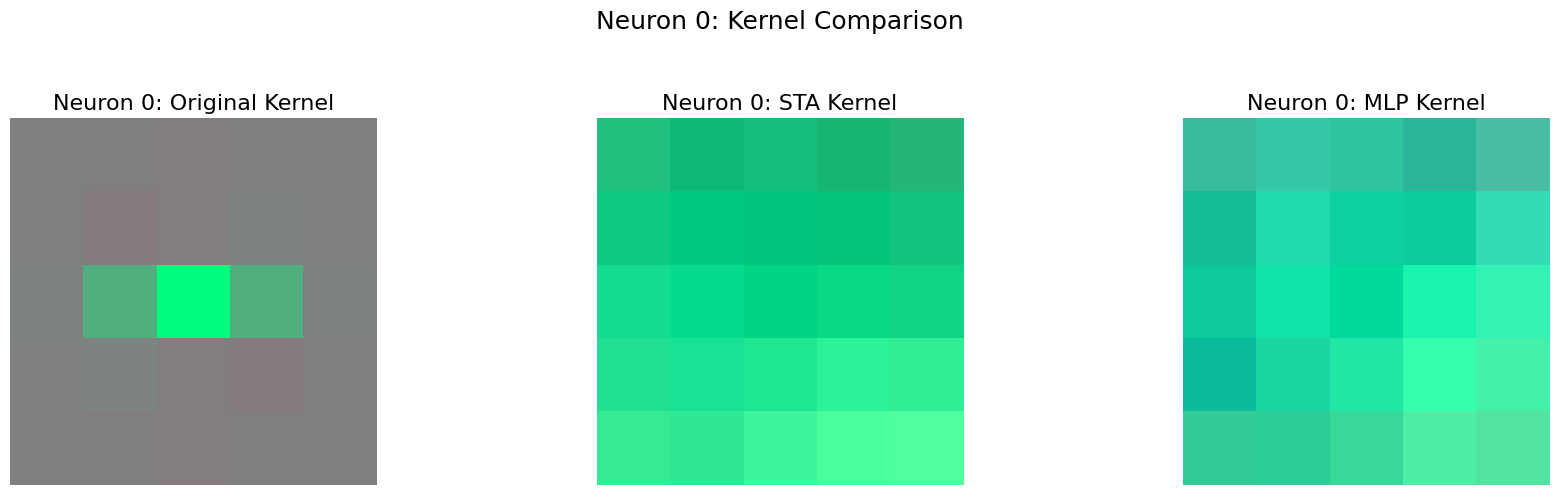

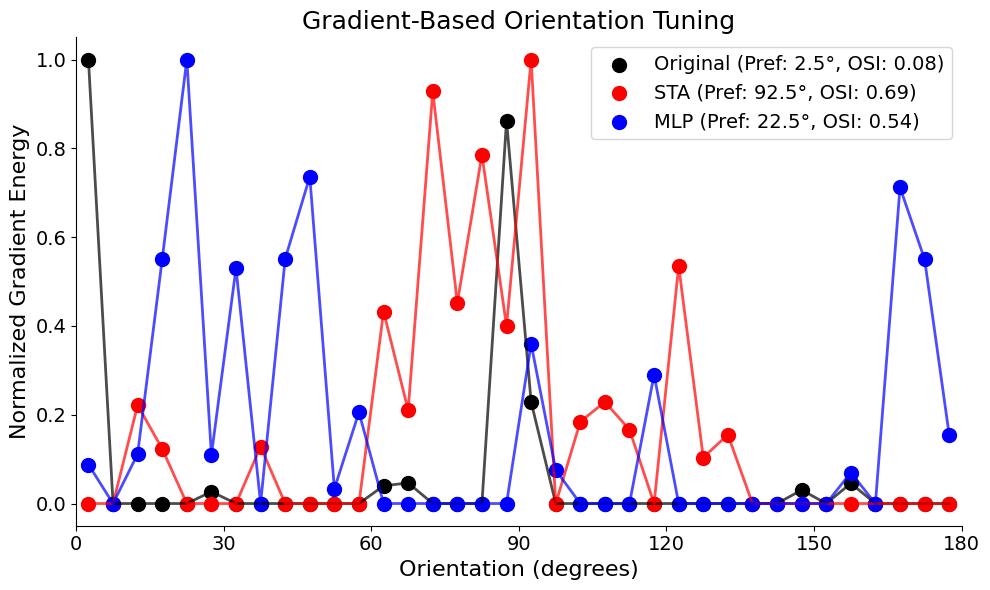


Neuron 0 Tuning Analysis Summary:
  Original: Pref Orientation = 2.5°, OSI = 0.08
  STA: Pref Orientation = 92.5°, OSI = 0.69
  MLP: Pref Orientation = 22.5°, OSI = 0.54


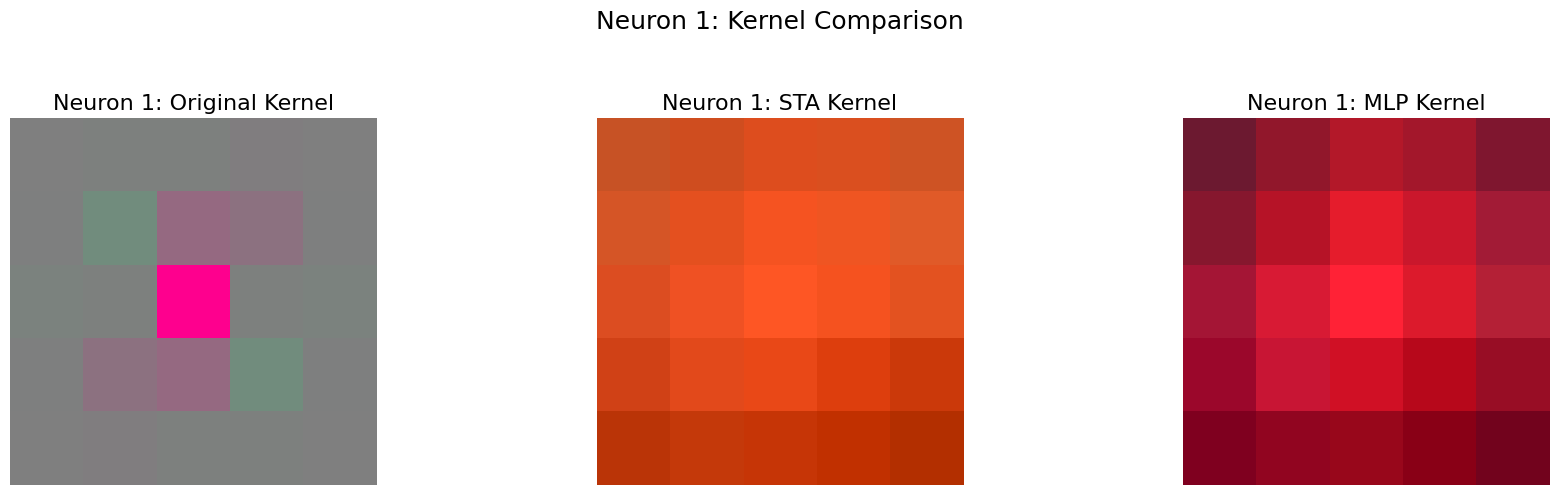

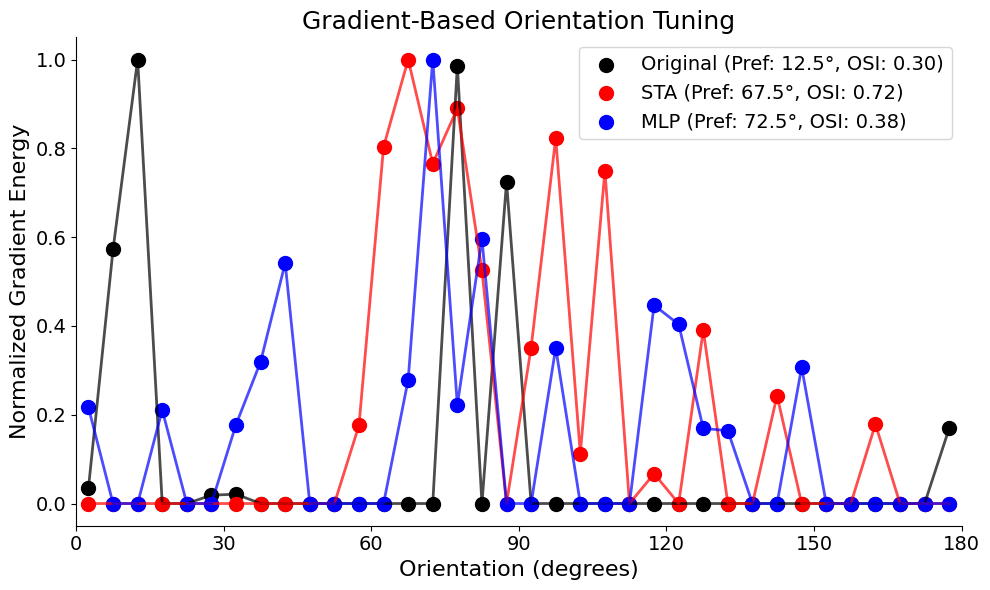


Neuron 1 Tuning Analysis Summary:
  Original: Pref Orientation = 12.5°, OSI = 0.30
  STA: Pref Orientation = 67.5°, OSI = 0.72
  MLP: Pref Orientation = 72.5°, OSI = 0.38


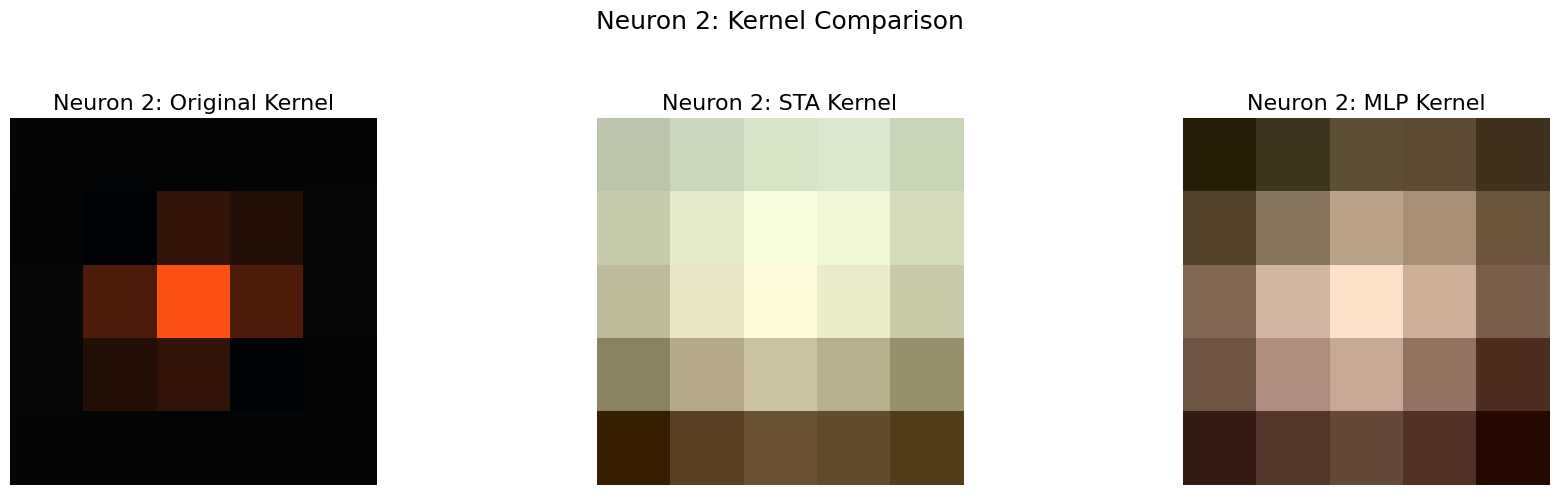

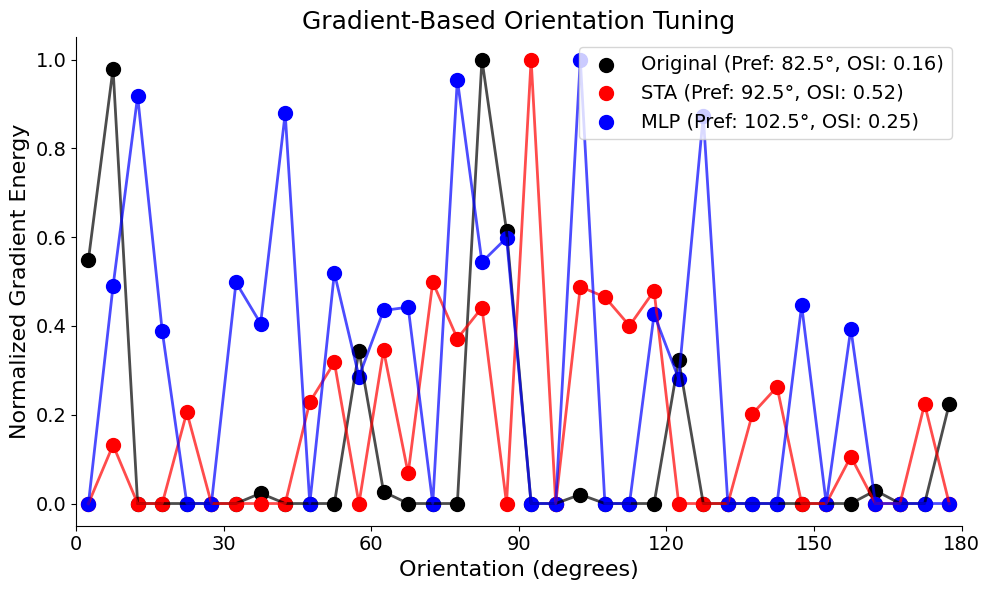


Neuron 2 Tuning Analysis Summary:
  Original: Pref Orientation = 82.5°, OSI = 0.16
  STA: Pref Orientation = 92.5°, OSI = 0.52
  MLP: Pref Orientation = 102.5°, OSI = 0.25


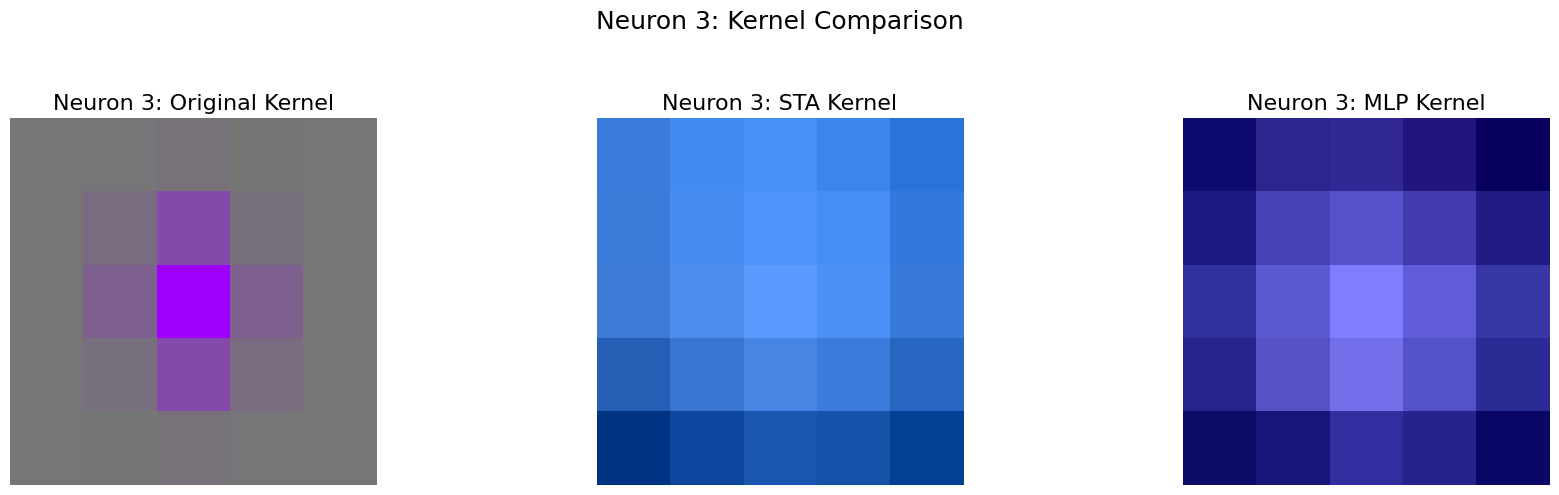

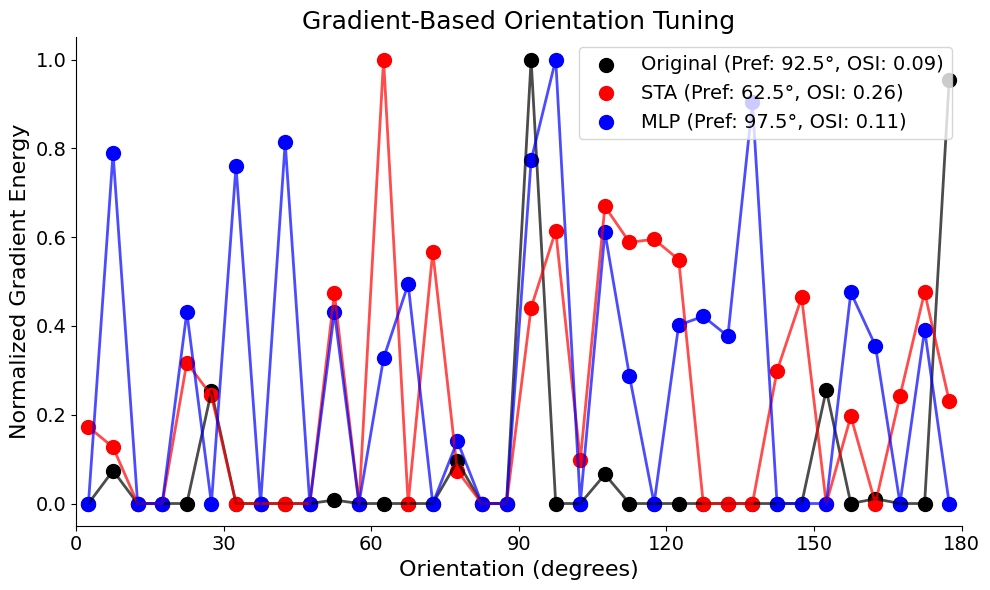


Neuron 3 Tuning Analysis Summary:
  Original: Pref Orientation = 92.5°, OSI = 0.09
  STA: Pref Orientation = 62.5°, OSI = 0.26
  MLP: Pref Orientation = 97.5°, OSI = 0.11


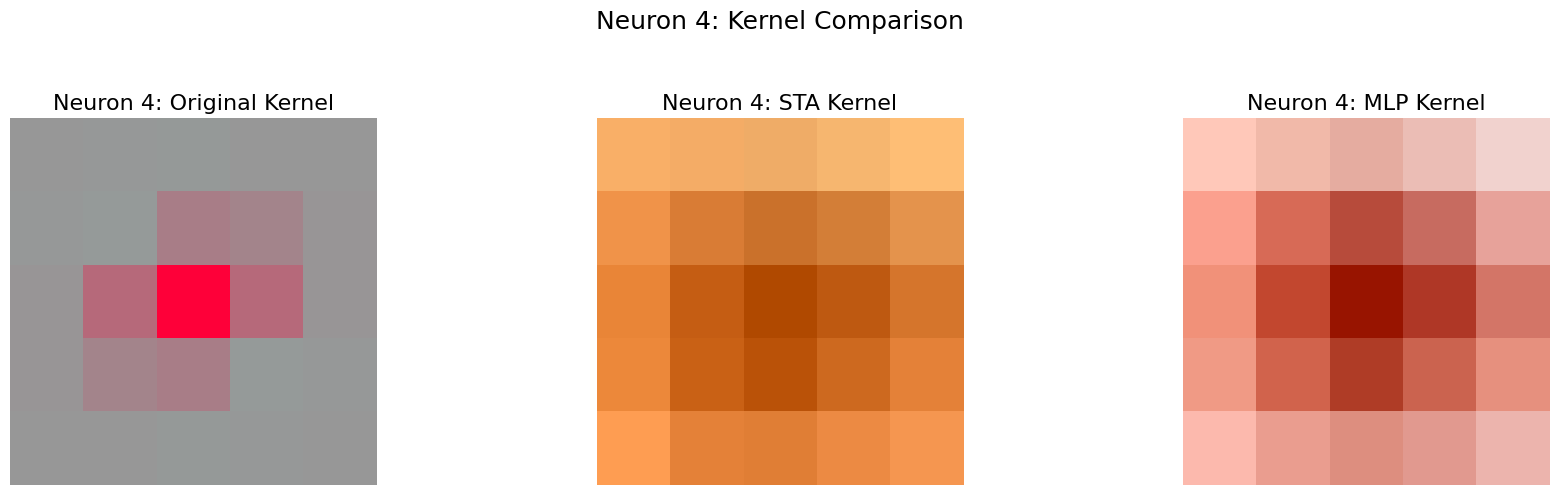

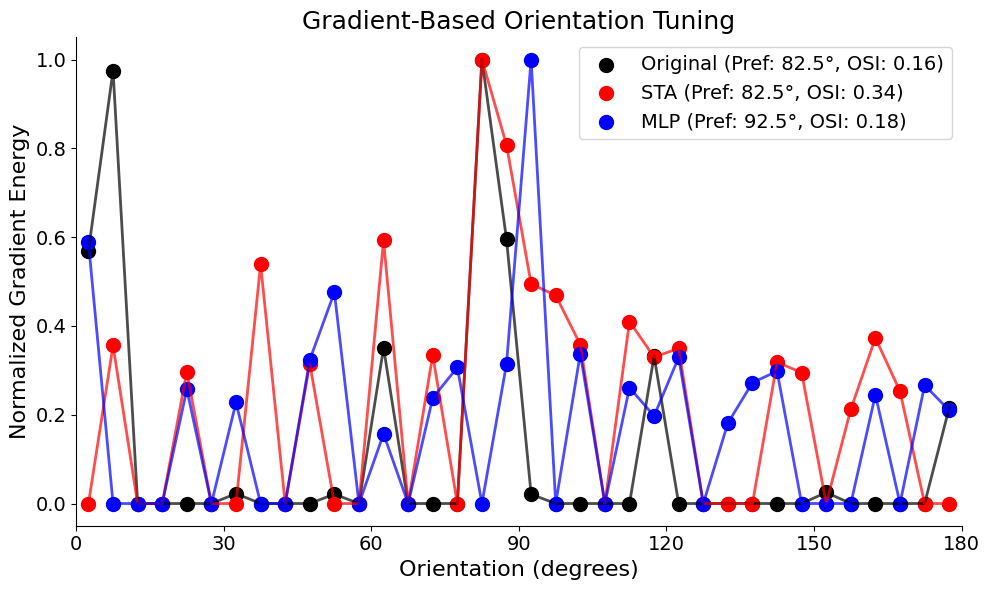


Neuron 4 Tuning Analysis Summary:
  Original: Pref Orientation = 82.5°, OSI = 0.16
  STA: Pref Orientation = 82.5°, OSI = 0.34
  MLP: Pref Orientation = 92.5°, OSI = 0.18


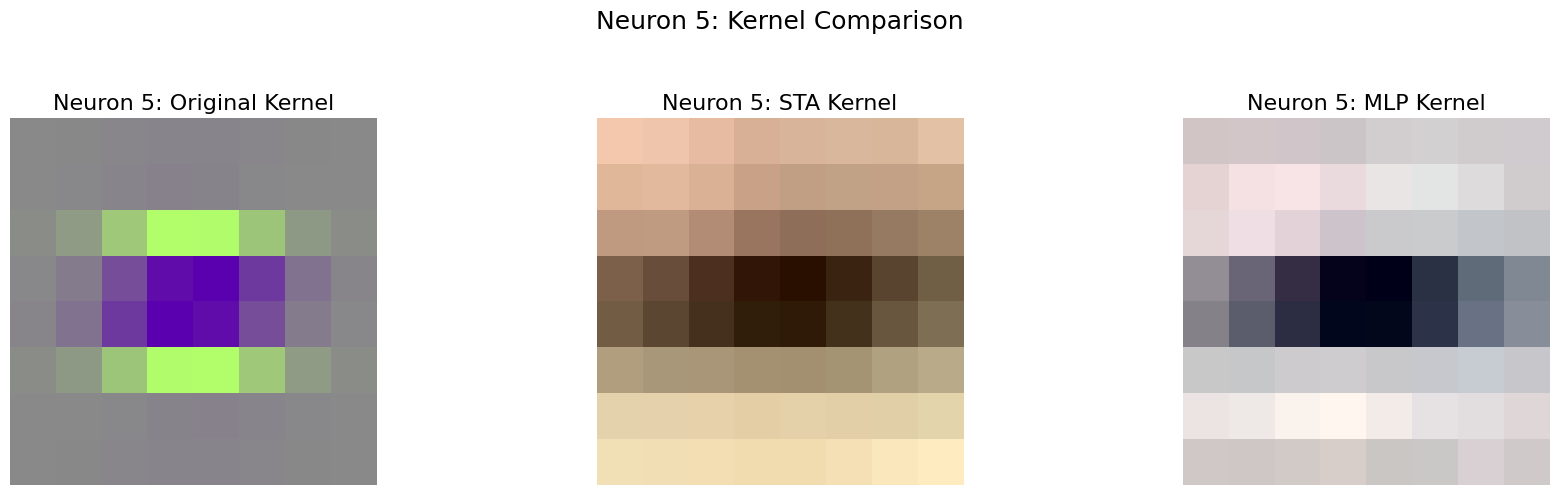

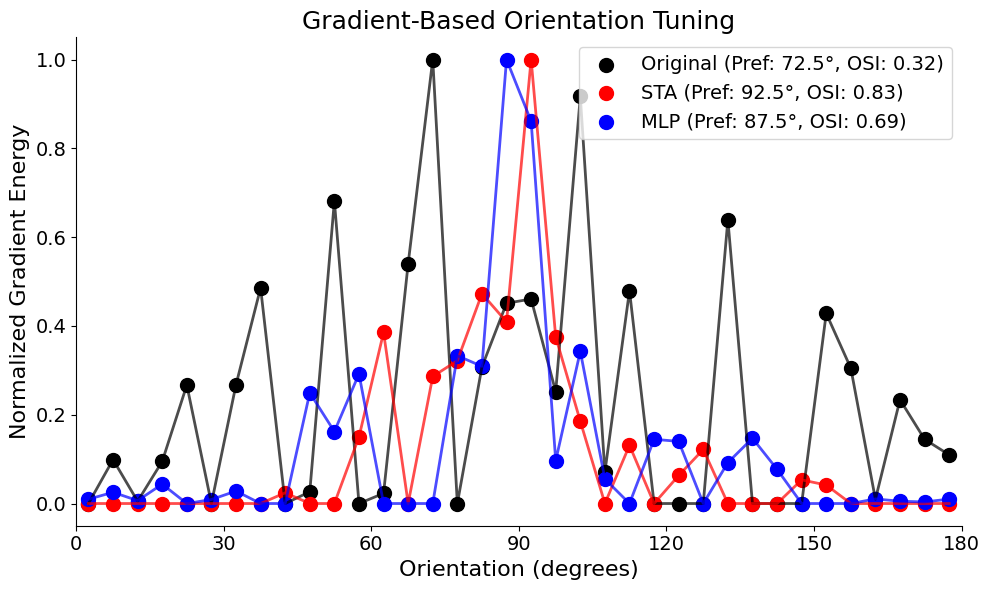


Neuron 5 Tuning Analysis Summary:
  Original: Pref Orientation = 72.5°, OSI = 0.32
  STA: Pref Orientation = 92.5°, OSI = 0.83
  MLP: Pref Orientation = 87.5°, OSI = 0.69


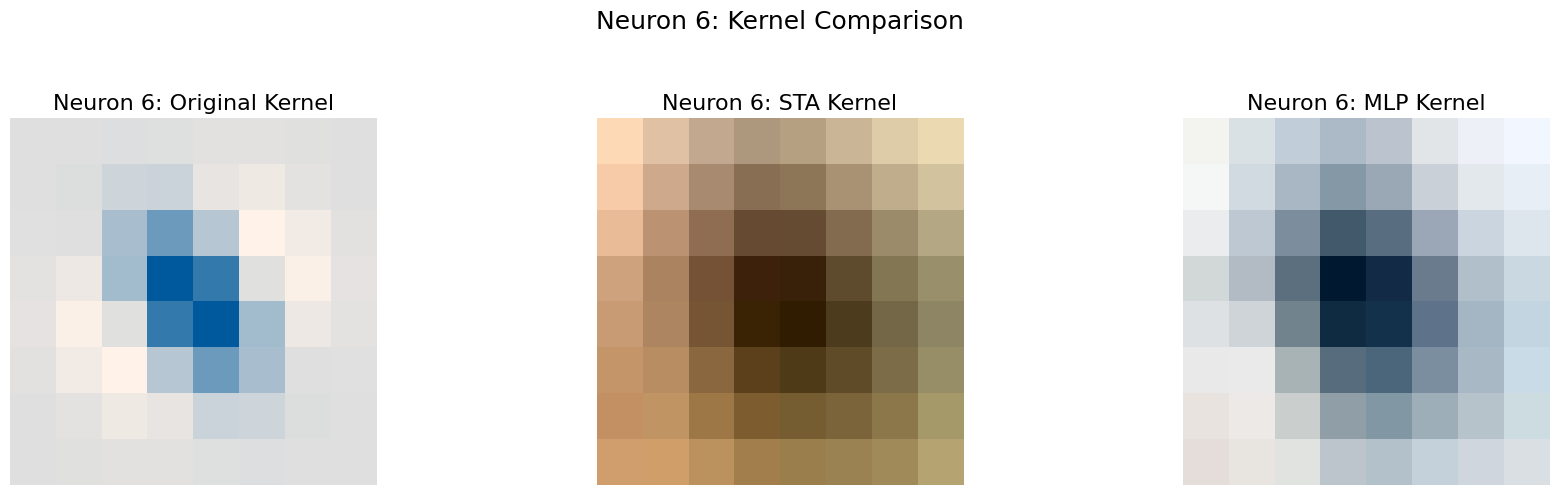

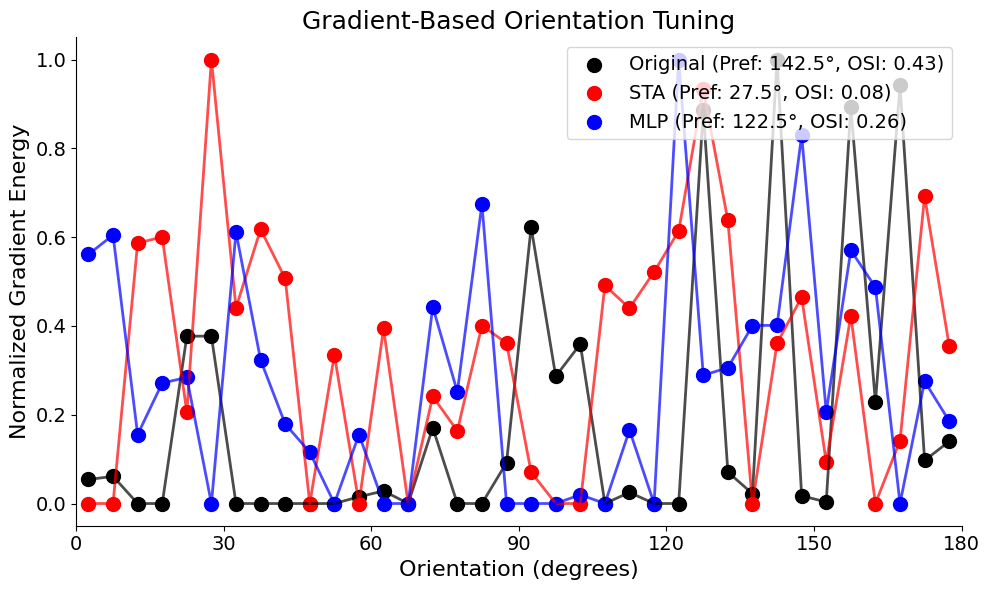


Neuron 6 Tuning Analysis Summary:
  Original: Pref Orientation = 142.5°, OSI = 0.43
  STA: Pref Orientation = 27.5°, OSI = 0.08
  MLP: Pref Orientation = 122.5°, OSI = 0.26


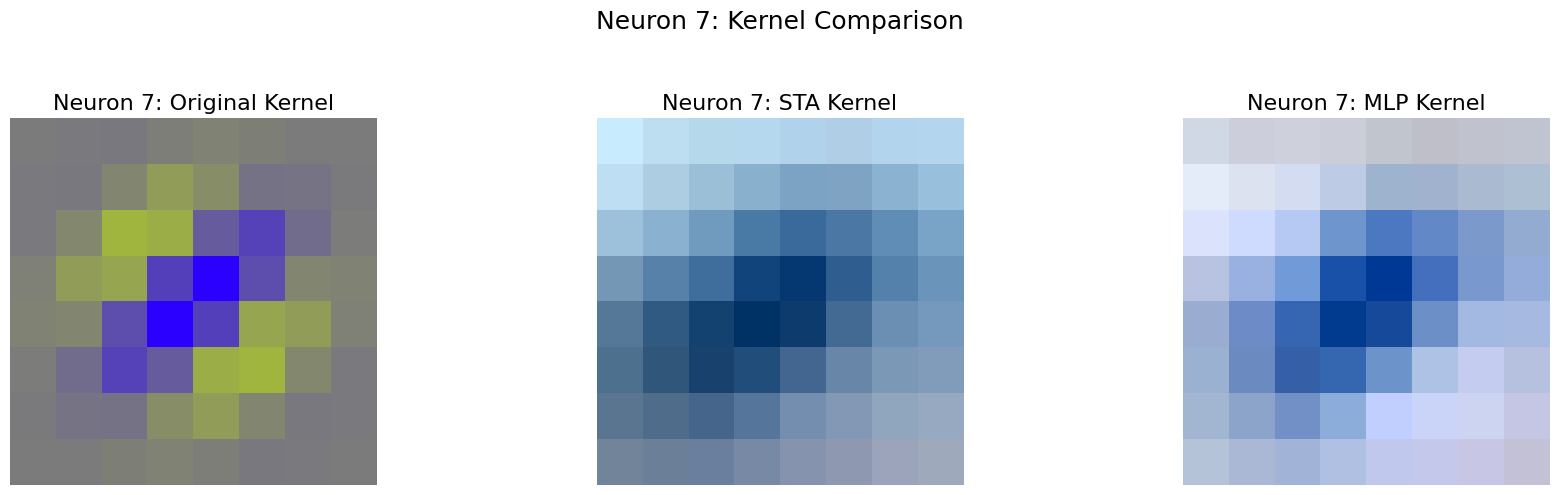

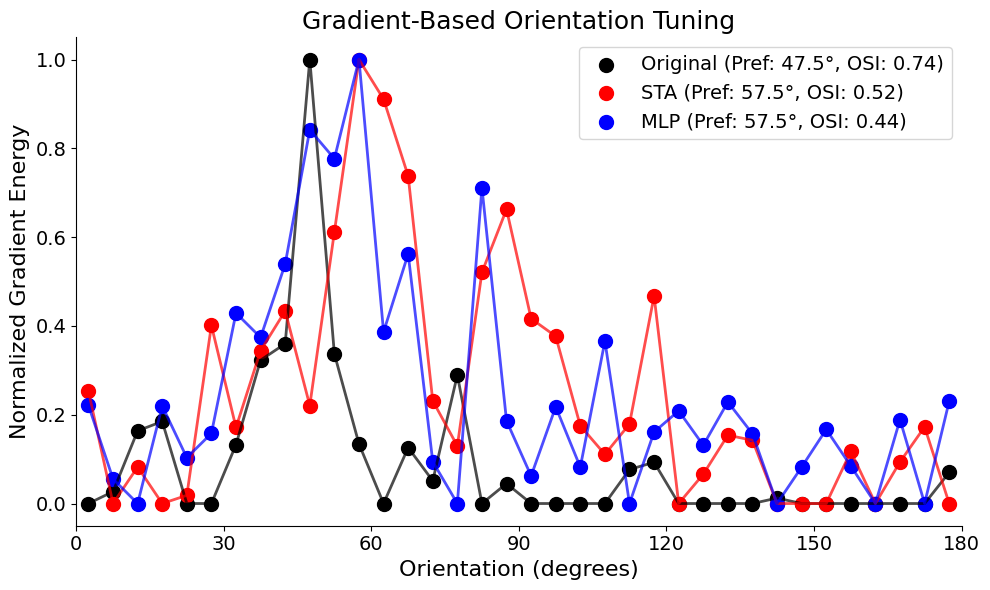


Neuron 7 Tuning Analysis Summary:
  Original: Pref Orientation = 47.5°, OSI = 0.74
  STA: Pref Orientation = 57.5°, OSI = 0.52
  MLP: Pref Orientation = 57.5°, OSI = 0.44


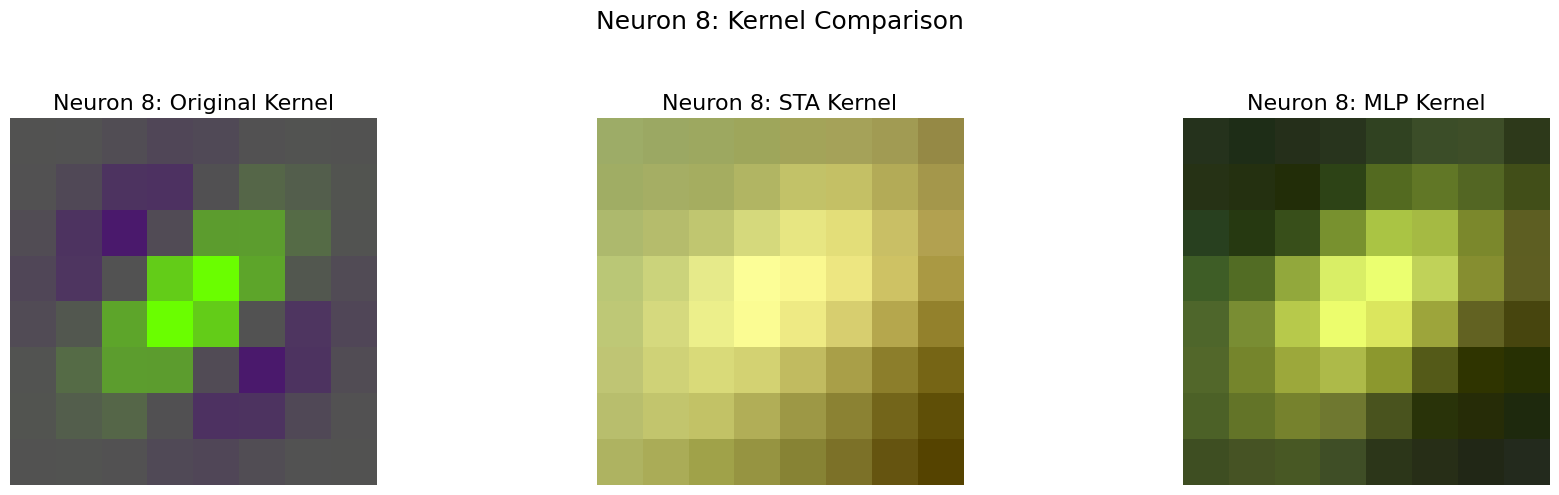

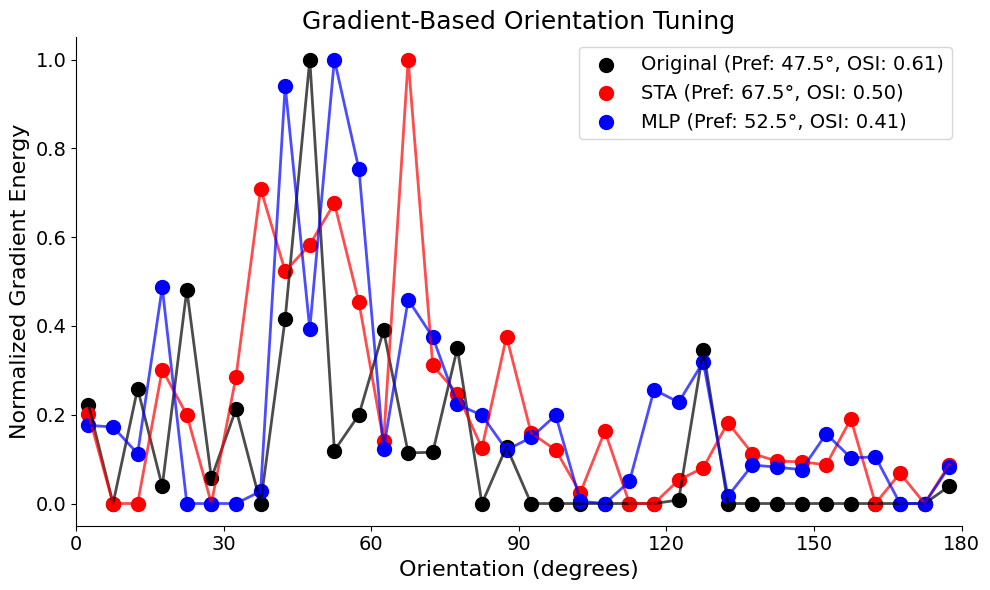


Neuron 8 Tuning Analysis Summary:
  Original: Pref Orientation = 47.5°, OSI = 0.61
  STA: Pref Orientation = 67.5°, OSI = 0.50
  MLP: Pref Orientation = 52.5°, OSI = 0.41


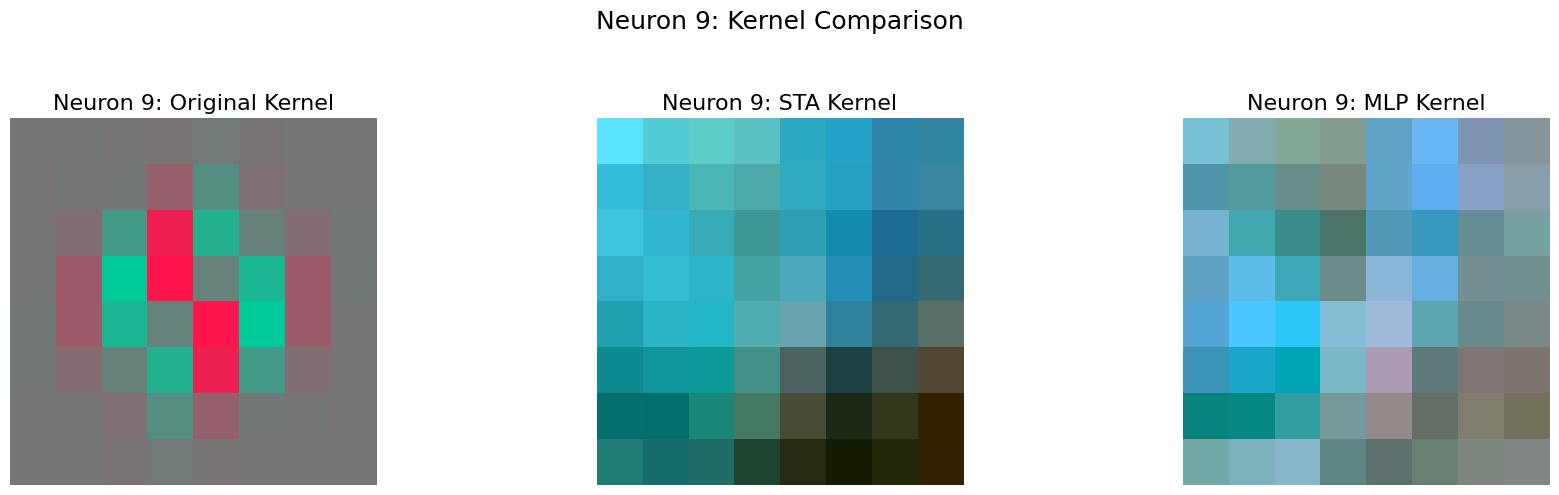

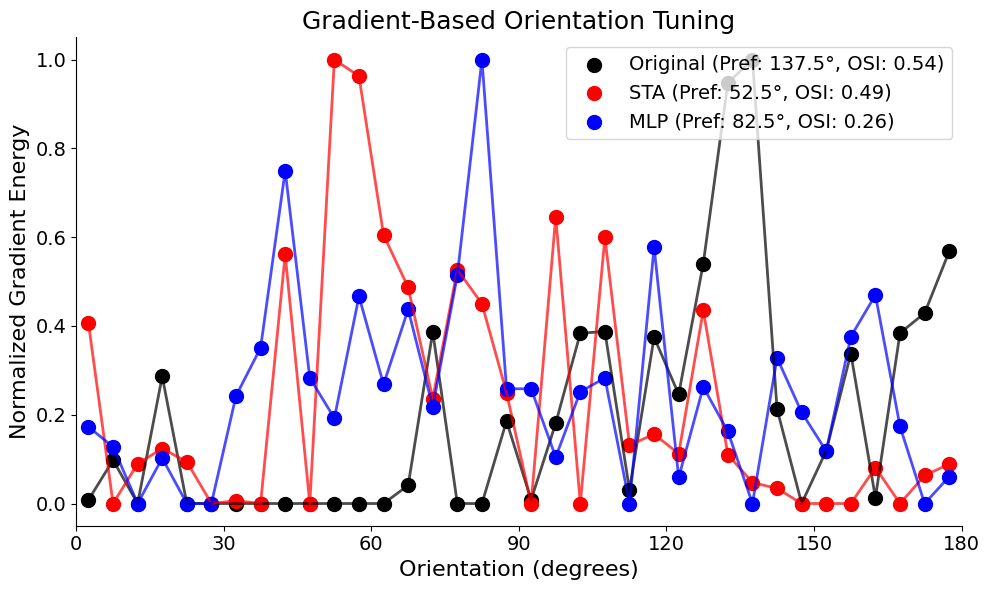


Neuron 9 Tuning Analysis Summary:
  Original: Pref Orientation = 137.5°, OSI = 0.54
  STA: Pref Orientation = 52.5°, OSI = 0.49
  MLP: Pref Orientation = 82.5°, OSI = 0.26


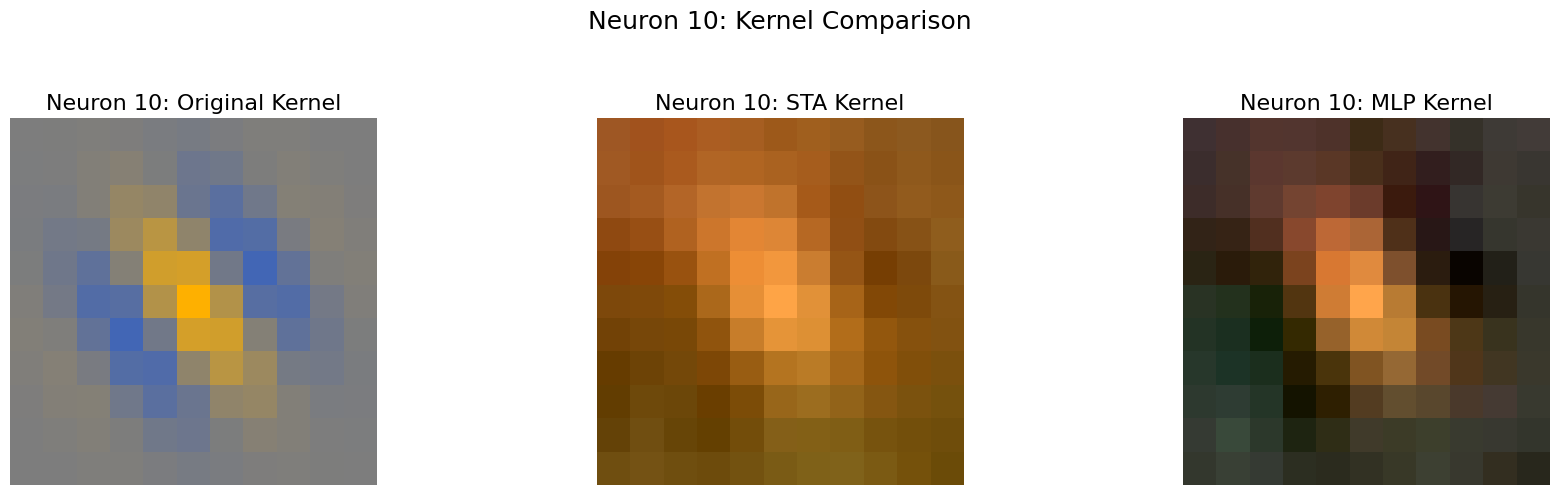

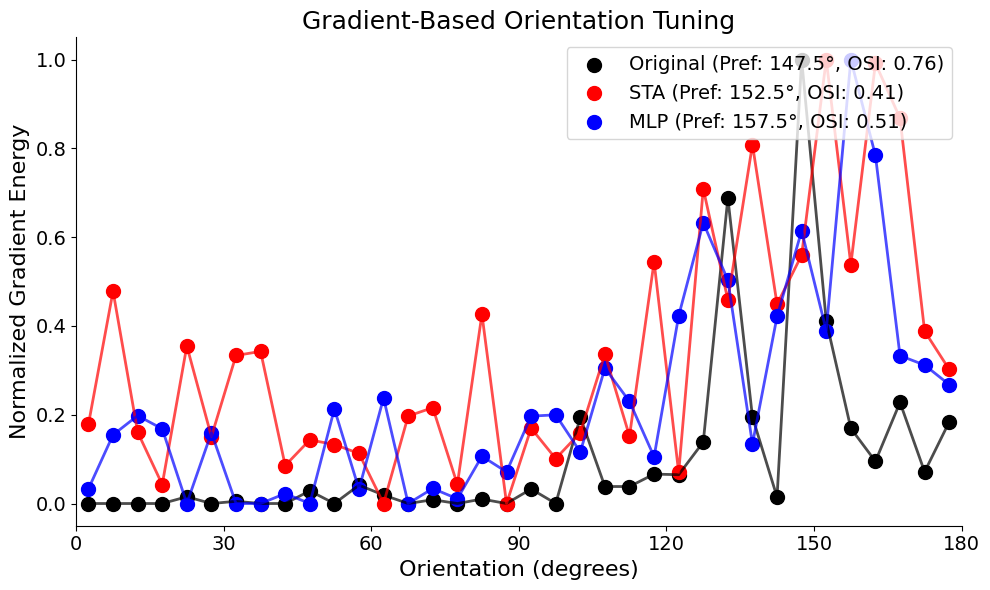


Neuron 10 Tuning Analysis Summary:
  Original: Pref Orientation = 147.5°, OSI = 0.76
  STA: Pref Orientation = 152.5°, OSI = 0.41
  MLP: Pref Orientation = 157.5°, OSI = 0.51


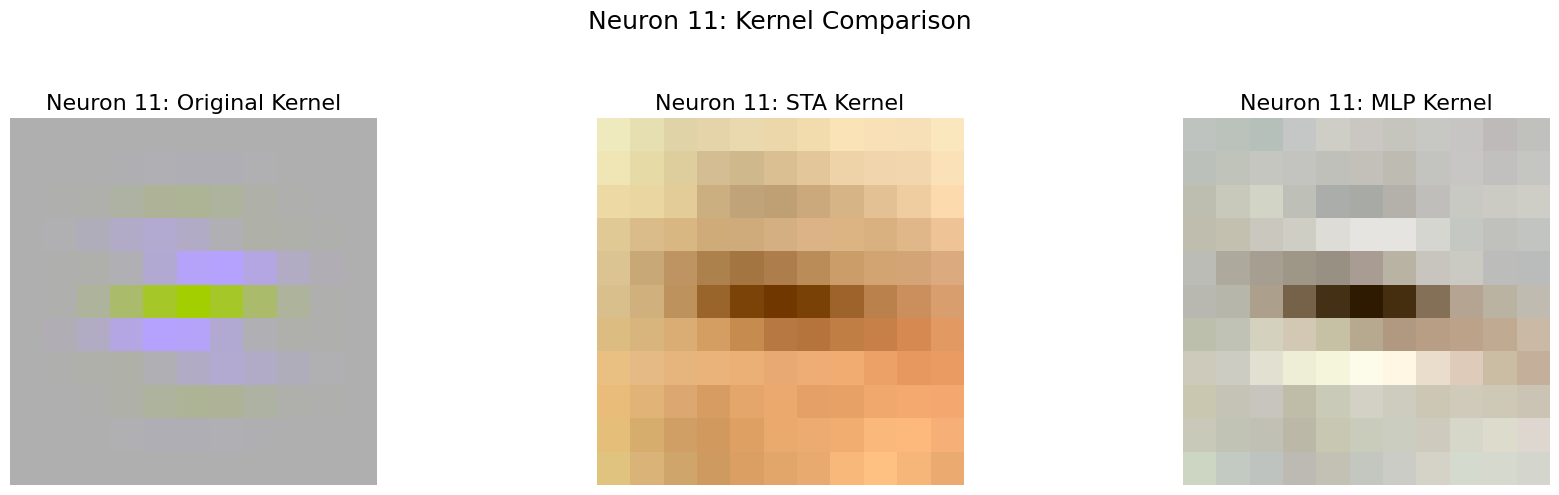

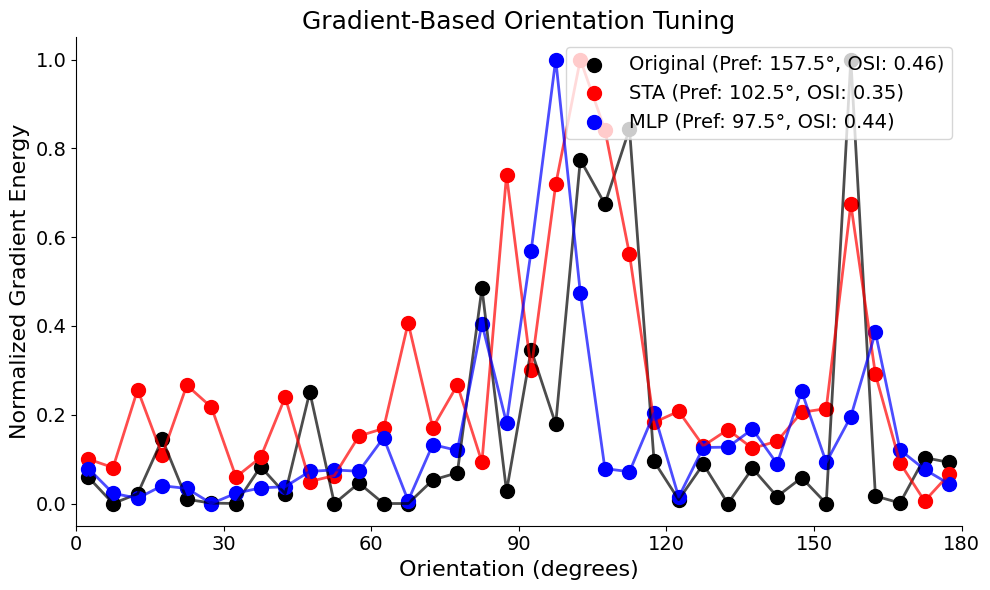


Neuron 11 Tuning Analysis Summary:
  Original: Pref Orientation = 157.5°, OSI = 0.46
  STA: Pref Orientation = 102.5°, OSI = 0.35
  MLP: Pref Orientation = 97.5°, OSI = 0.44


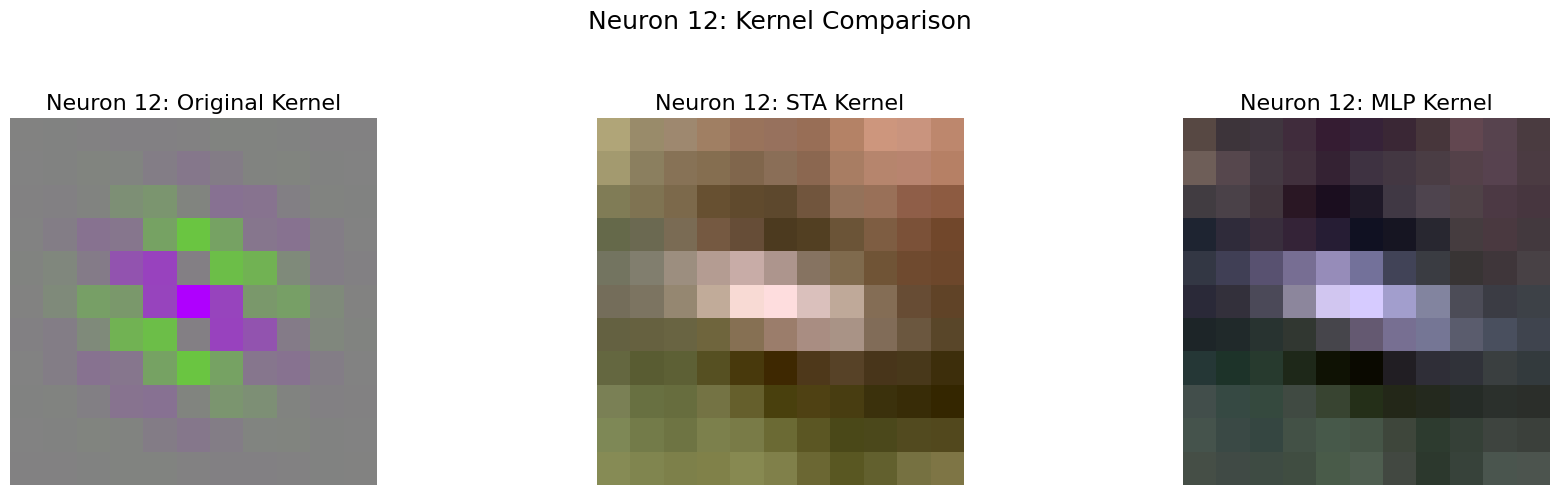

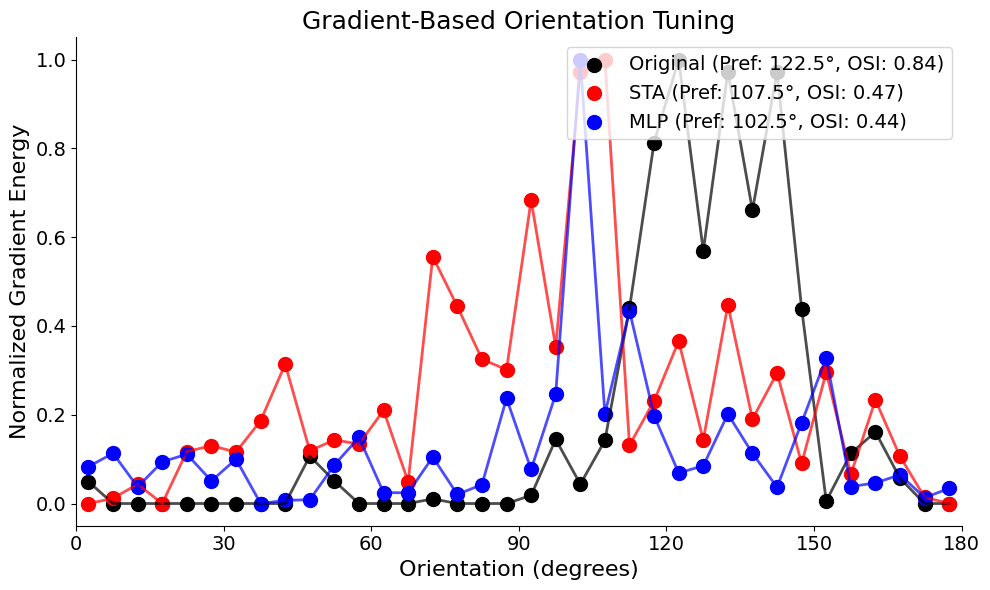


Neuron 12 Tuning Analysis Summary:
  Original: Pref Orientation = 122.5°, OSI = 0.84
  STA: Pref Orientation = 107.5°, OSI = 0.47
  MLP: Pref Orientation = 102.5°, OSI = 0.44


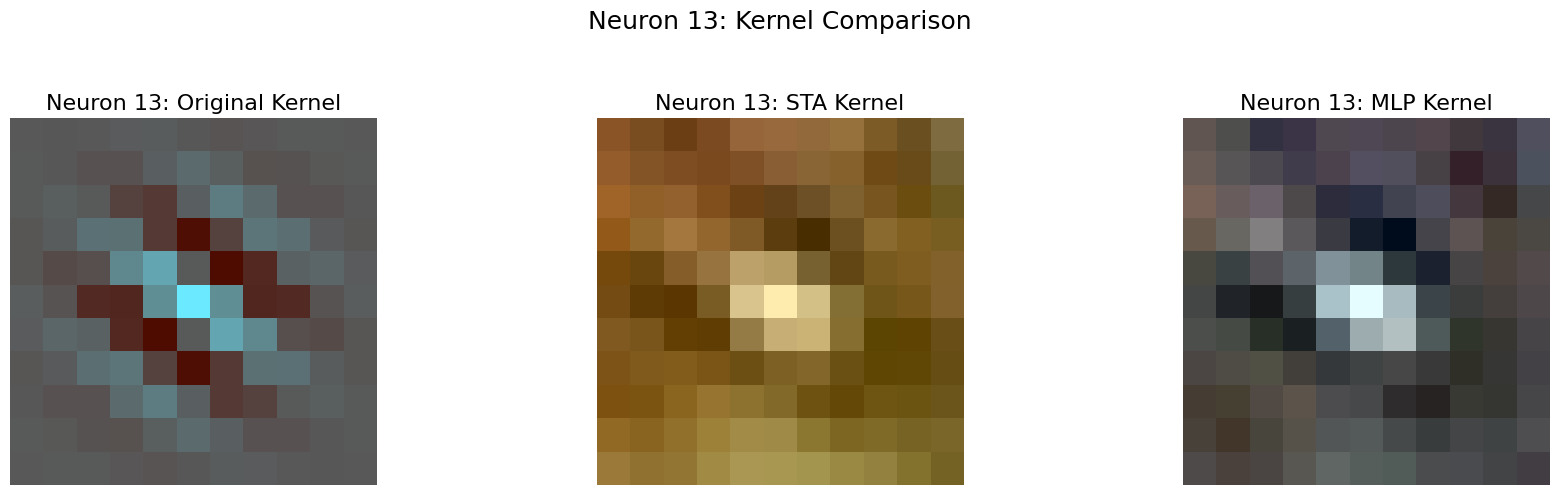

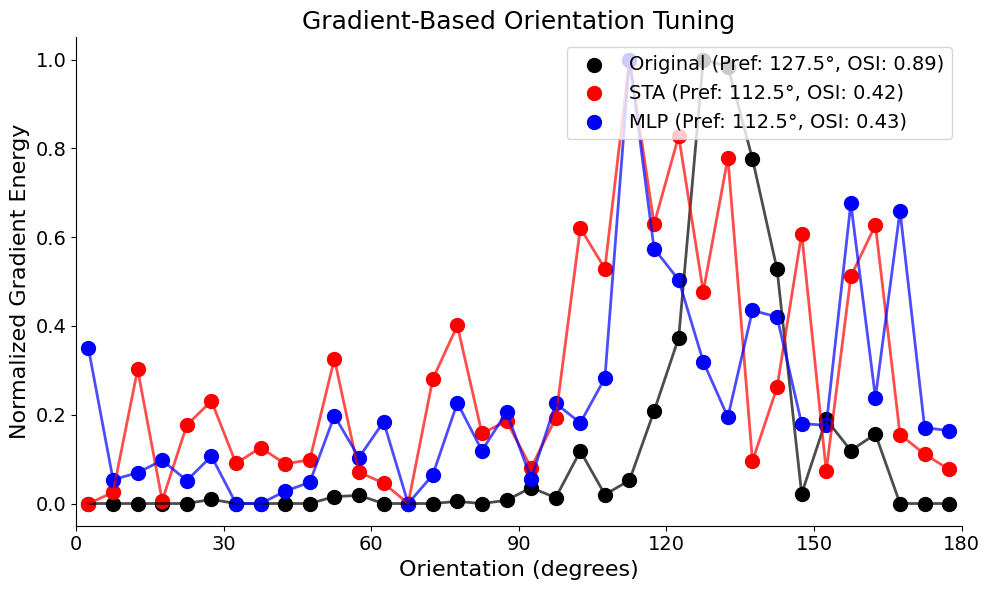


Neuron 13 Tuning Analysis Summary:
  Original: Pref Orientation = 127.5°, OSI = 0.89
  STA: Pref Orientation = 112.5°, OSI = 0.42
  MLP: Pref Orientation = 112.5°, OSI = 0.43


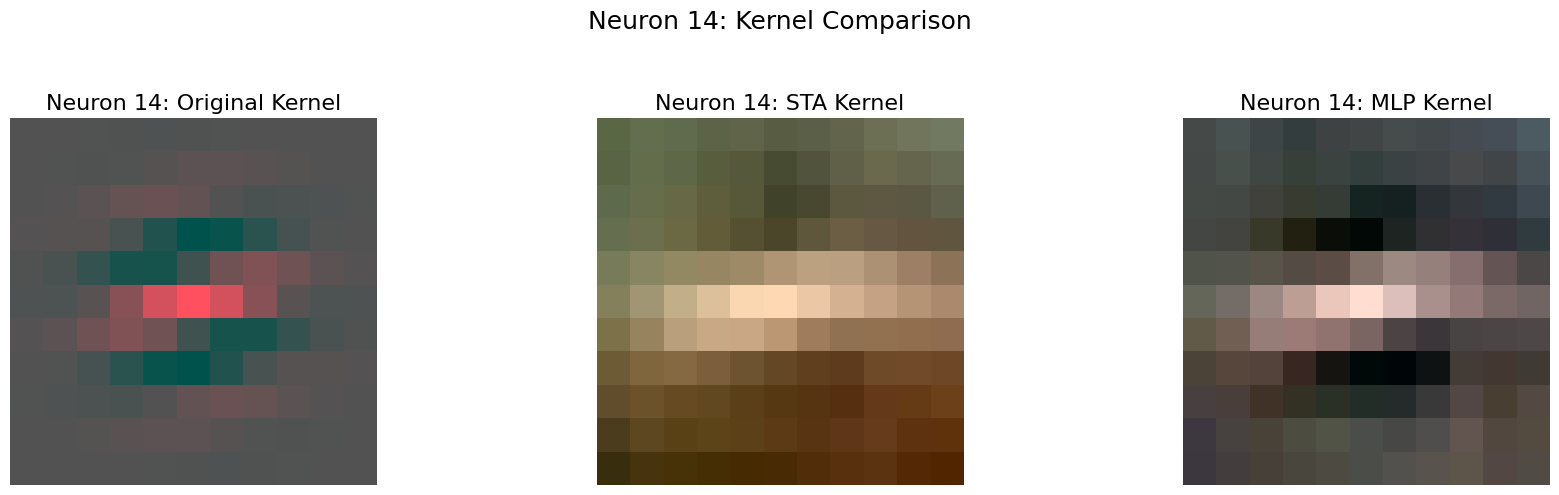

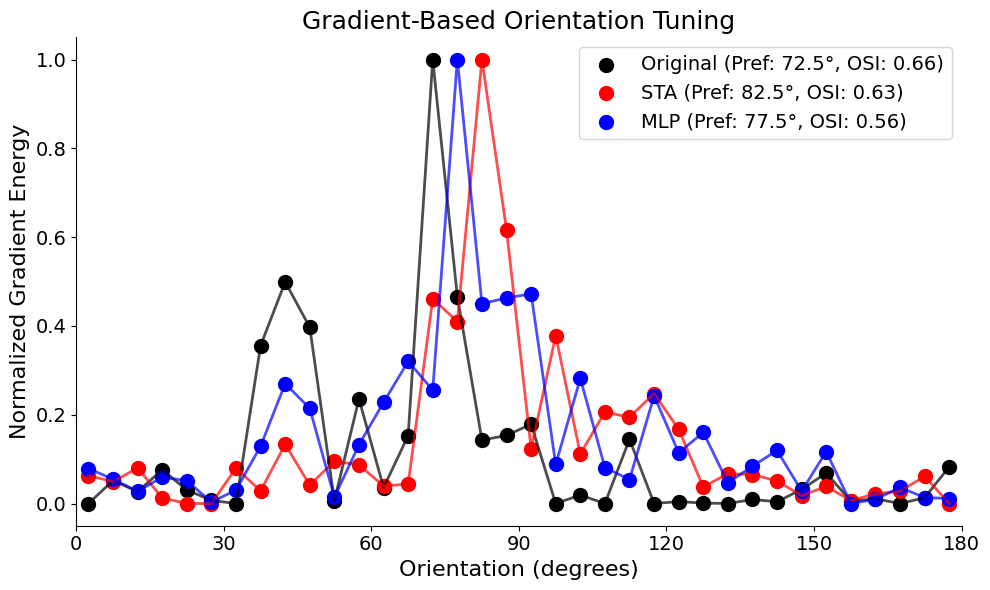


Neuron 14 Tuning Analysis Summary:
  Original: Pref Orientation = 72.5°, OSI = 0.66
  STA: Pref Orientation = 82.5°, OSI = 0.63
  MLP: Pref Orientation = 77.5°, OSI = 0.56


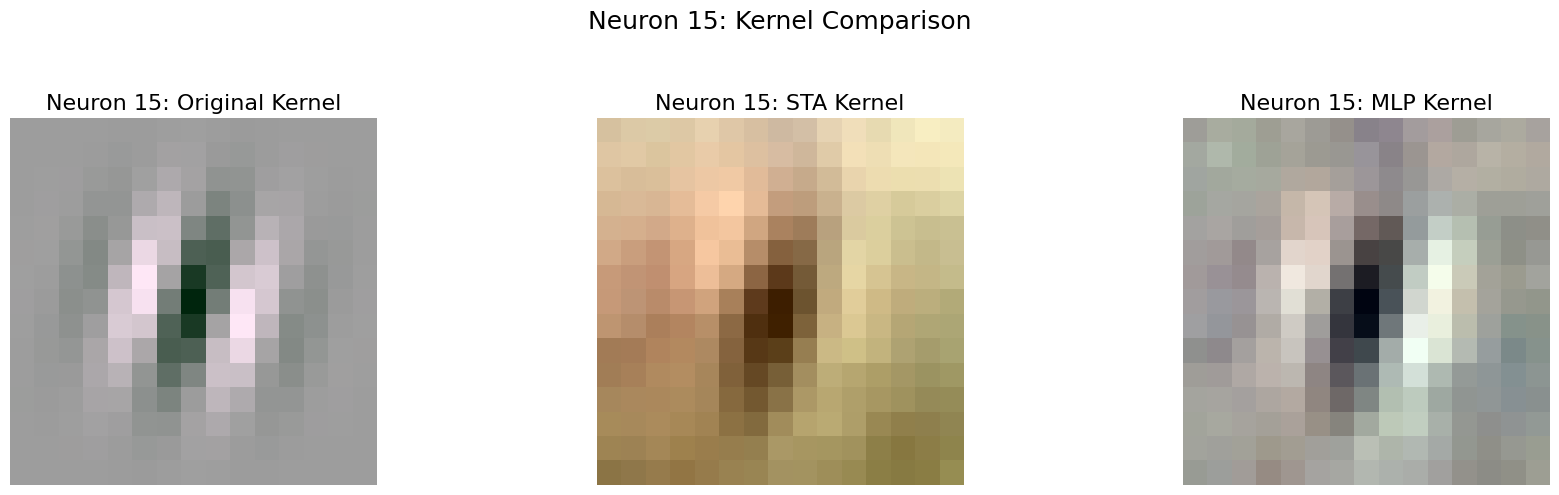

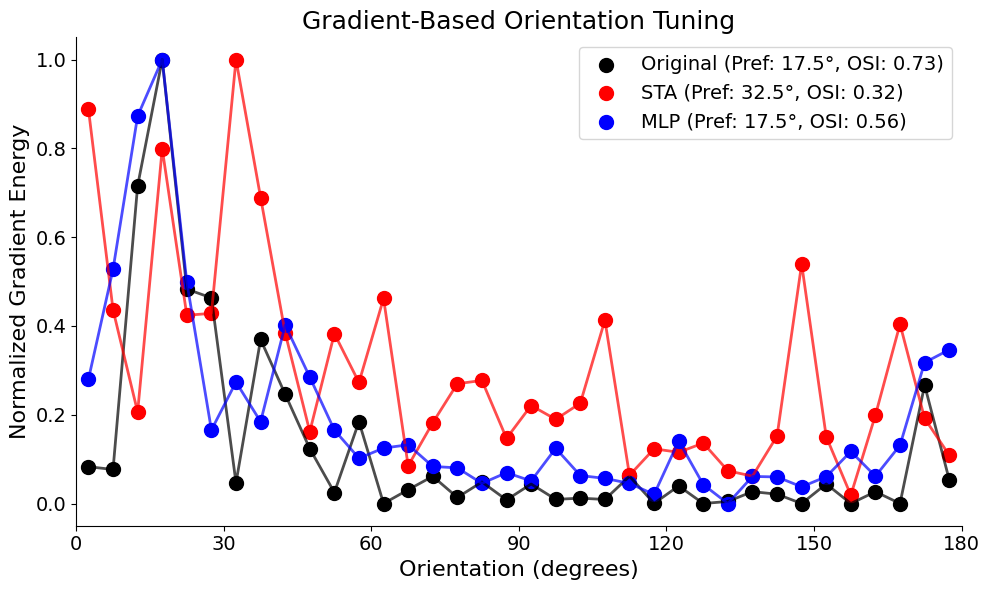


Neuron 15 Tuning Analysis Summary:
  Original: Pref Orientation = 17.5°, OSI = 0.73
  STA: Pref Orientation = 32.5°, OSI = 0.32
  MLP: Pref Orientation = 17.5°, OSI = 0.56


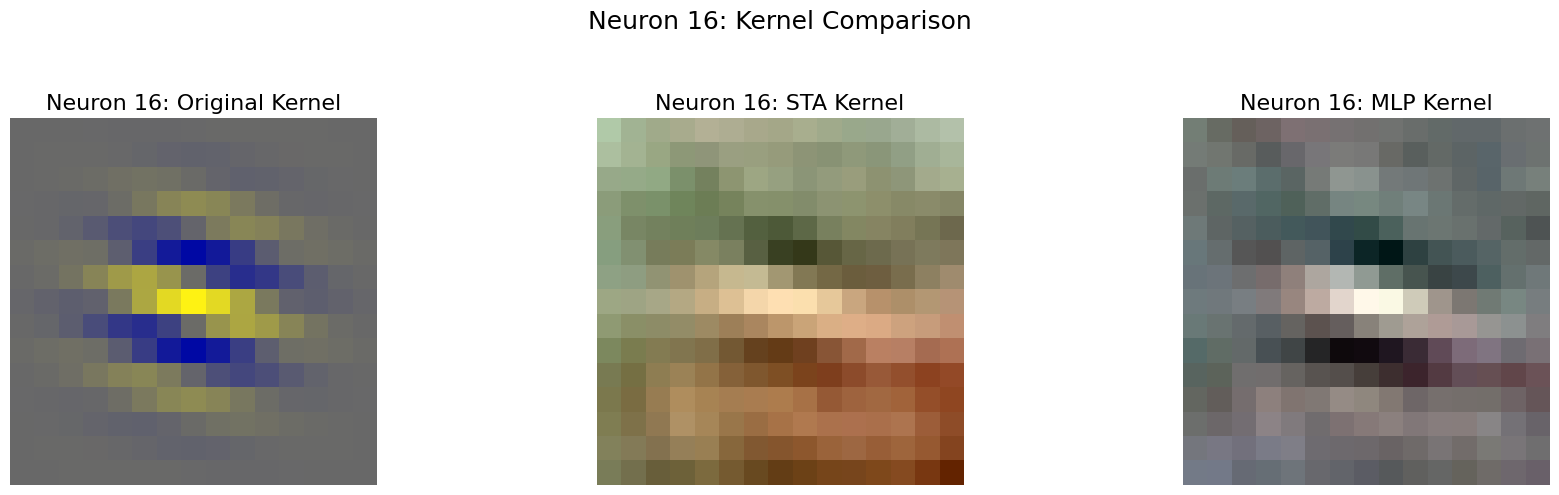

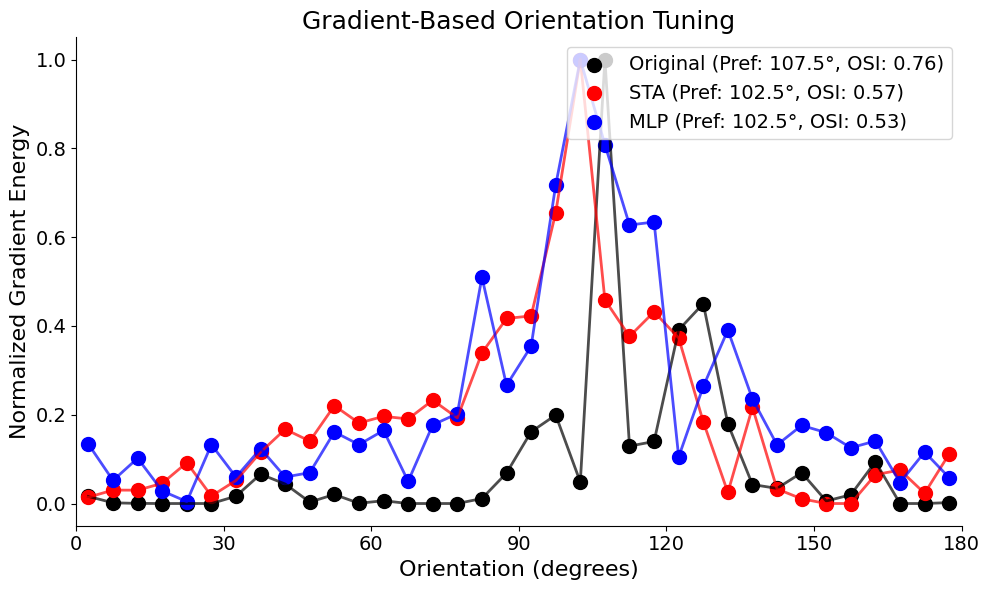


Neuron 16 Tuning Analysis Summary:
  Original: Pref Orientation = 107.5°, OSI = 0.76
  STA: Pref Orientation = 102.5°, OSI = 0.57
  MLP: Pref Orientation = 102.5°, OSI = 0.53


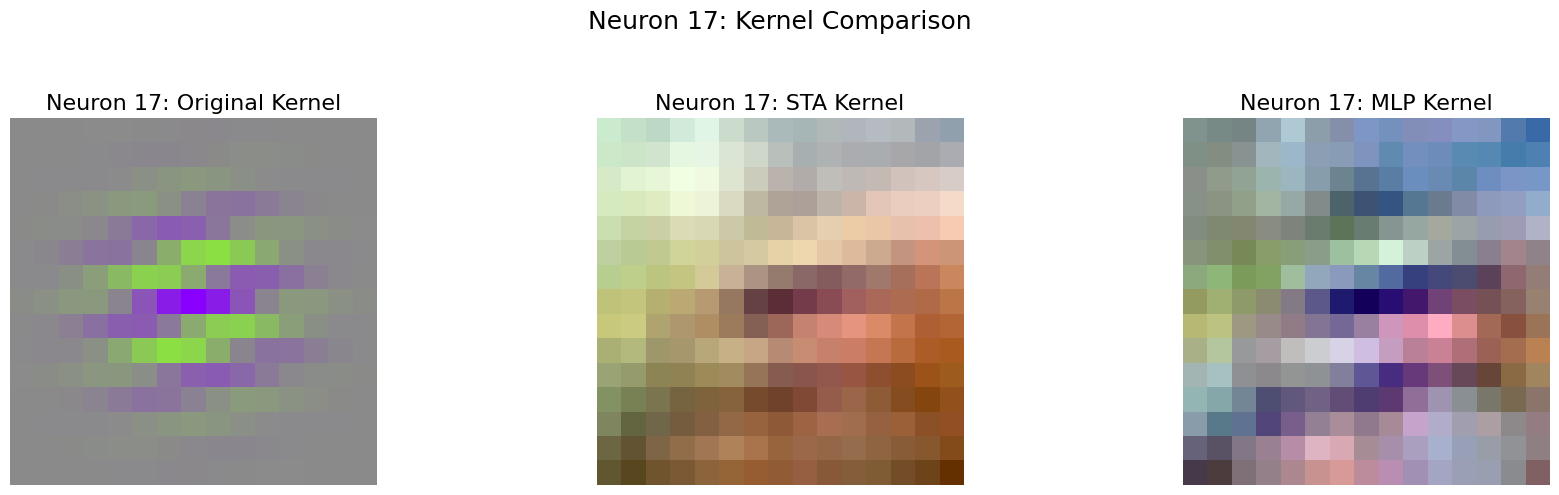

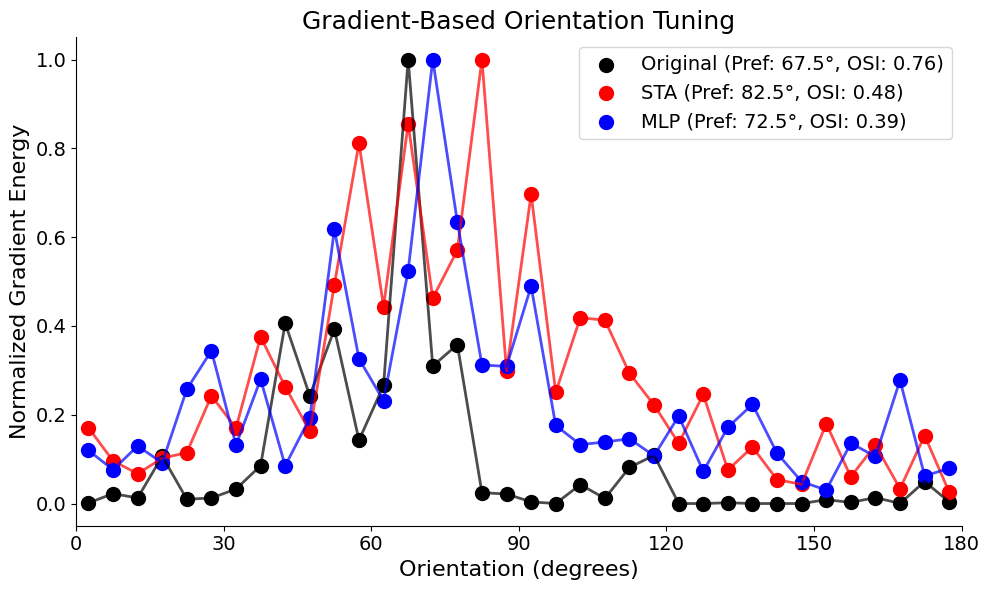


Neuron 17 Tuning Analysis Summary:
  Original: Pref Orientation = 67.5°, OSI = 0.76
  STA: Pref Orientation = 82.5°, OSI = 0.48
  MLP: Pref Orientation = 72.5°, OSI = 0.39


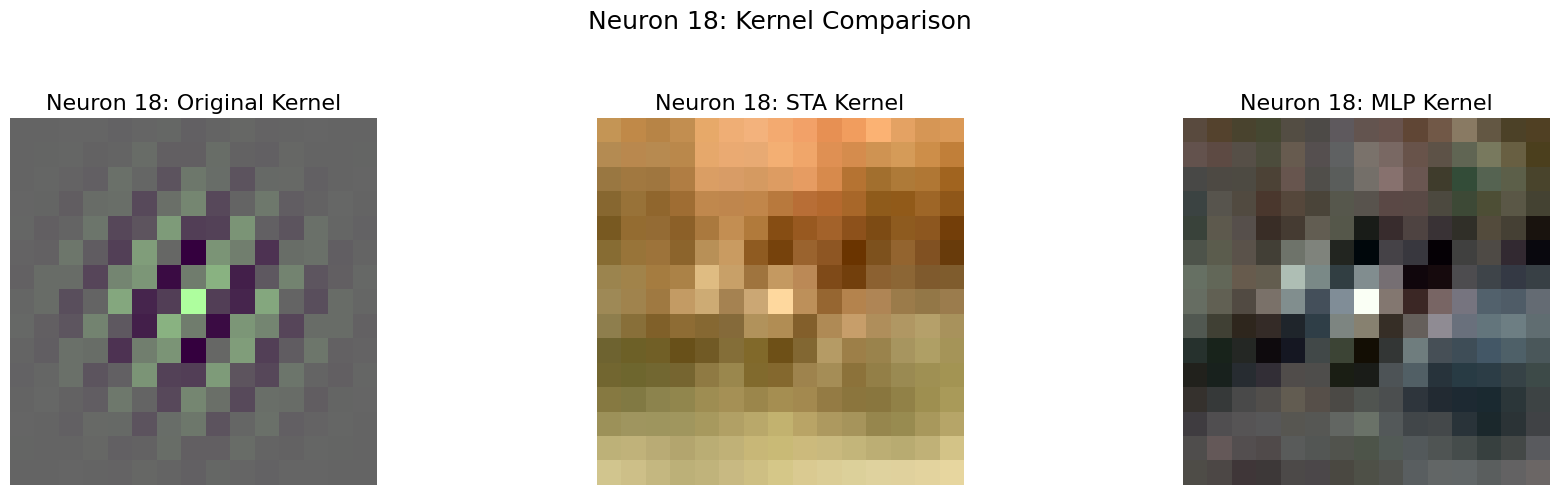

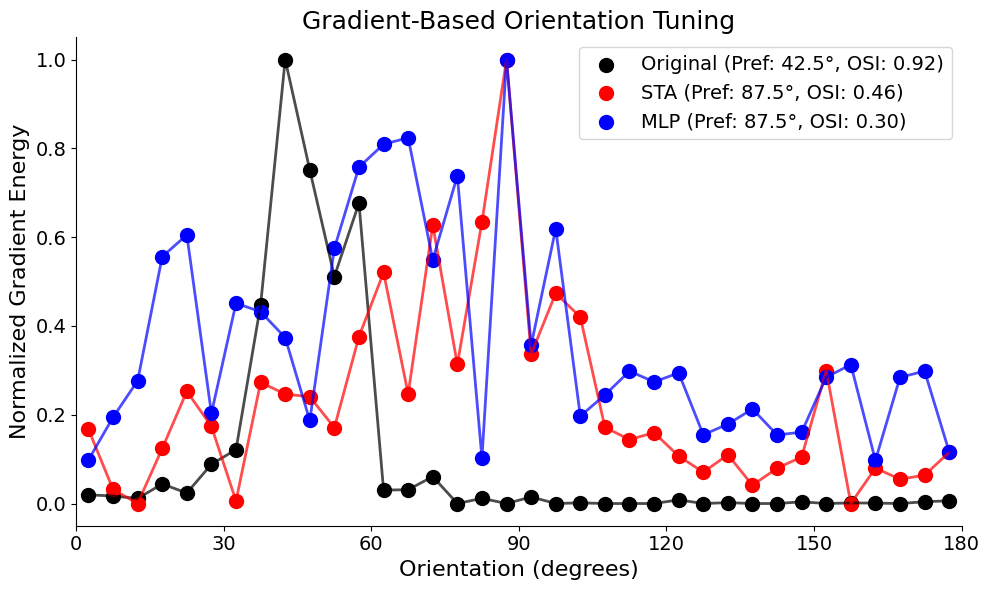


Neuron 18 Tuning Analysis Summary:
  Original: Pref Orientation = 42.5°, OSI = 0.92
  STA: Pref Orientation = 87.5°, OSI = 0.46
  MLP: Pref Orientation = 87.5°, OSI = 0.30


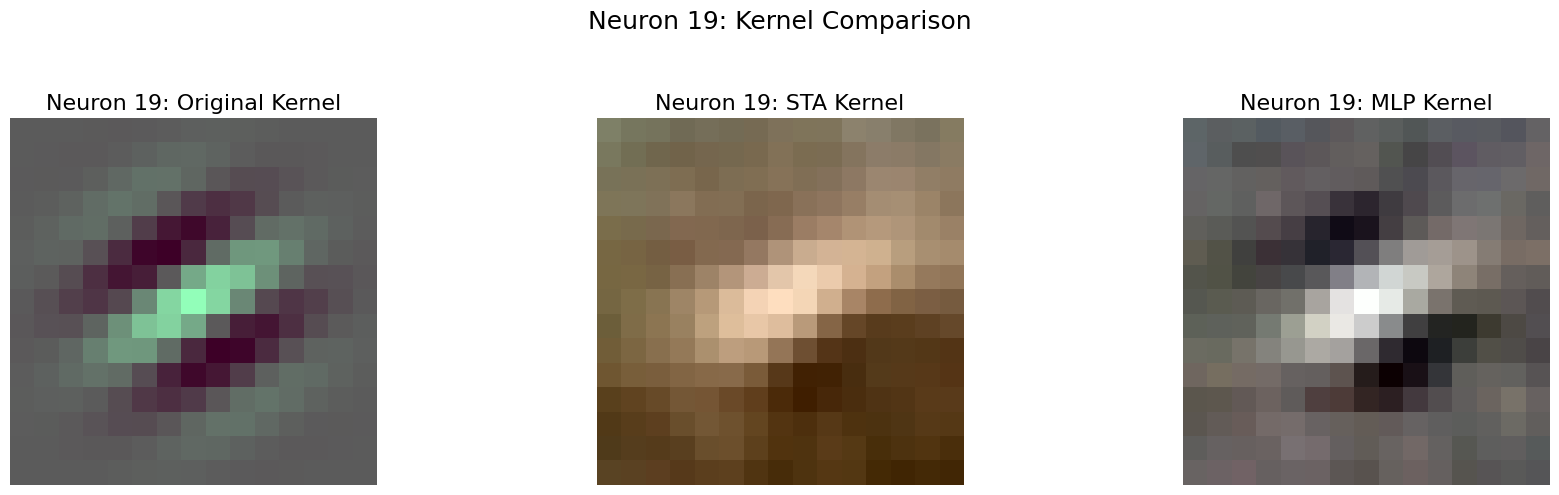

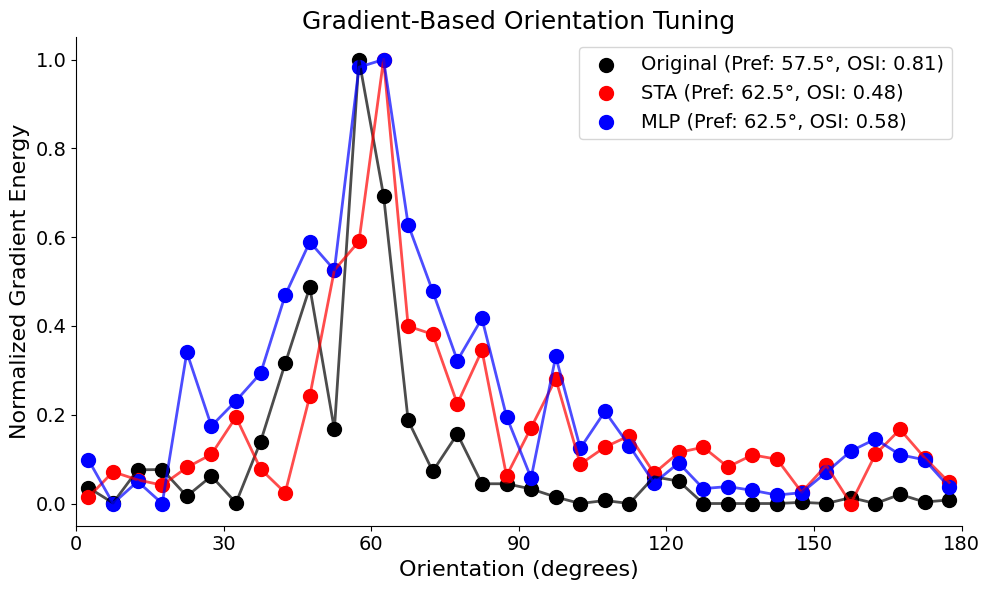


Neuron 19 Tuning Analysis Summary:
  Original: Pref Orientation = 57.5°, OSI = 0.81
  STA: Pref Orientation = 62.5°, OSI = 0.48
  MLP: Pref Orientation = 62.5°, OSI = 0.58


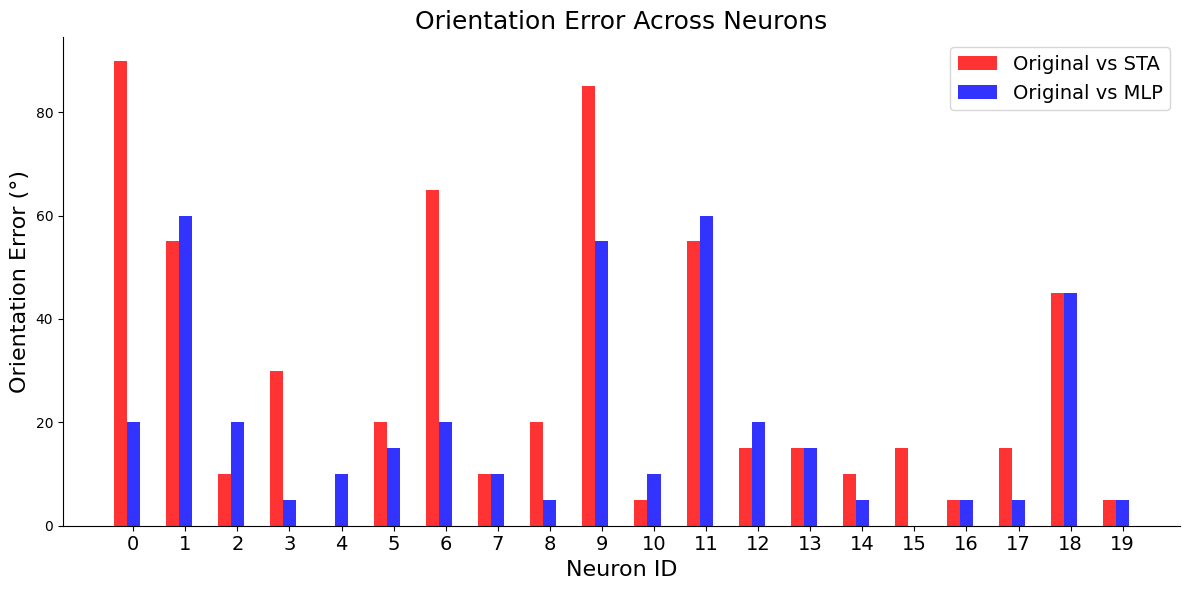

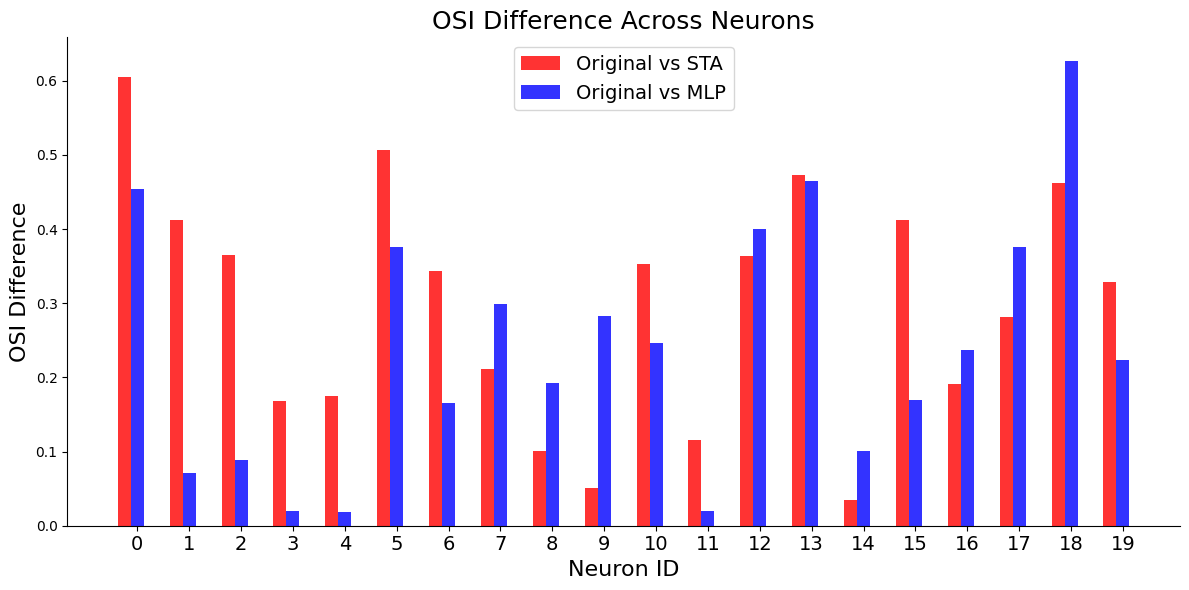

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)

def calculate_osi(tuning_curve, angles):
    """
    Calculate orientation selectivity index.
    OSI = |Σ R(θ) exp(2iθ)| / Σ R(θ)
    """
    angles_rad = np.deg2rad(angles)
    complex_sum = np.sum(tuning_curve * np.exp(2j * angles_rad))
    return np.abs(complex_sum) / (np.sum(tuning_curve) + 1e-10)

def simple_orientation_tuning_gradients(kernel, num_bins=36):
    """
    Compute a gradient-based orientation tuning curve.

    Converts the kernel to grayscale if needed, removes its DC component,
    computes its gradients, and bins the gradient magnitudes by orientation.
    """
    if kernel.ndim == 3:
        kernel = np.mean(kernel, axis=2)
    kernel = kernel - np.mean(kernel)

    # Compute gradients.
    dy, dx = np.gradient(kernel)
    mag = np.sqrt(dx**2 + dy**2)
    theta = np.rad2deg(np.arctan2(dy, dx)) % 180

    bins = np.linspace(0, 180, num_bins + 1)
    tuning, edges = np.histogram(theta, bins=bins, weights=mag)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    tuning_norm = tuning / (np.max(tuning) + 1e-10)
    preferred_angle = bin_centers[np.argmax(tuning_norm)]

    return tuning_norm, preferred_angle, bin_centers

def perform_gradient_tuning_analysis_three(neuron_id, sta_kernel, mlp_kernel, original_kernel):
    """
    Compute gradient-based orientation tuning for three kernels:
    STA, MLP, and the Original.
    """
    sta_tuning, sta_pref_angle, angle_bins = simple_orientation_tuning_gradients(sta_kernel)
    mlp_tuning, mlp_pref_angle, _ = simple_orientation_tuning_gradients(mlp_kernel)
    orig_tuning, orig_pref_angle, _ = simple_orientation_tuning_gradients(original_kernel)

    sta_osi = calculate_osi(sta_tuning, angle_bins)
    mlp_osi = calculate_osi(mlp_tuning, angle_bins)
    orig_osi = calculate_osi(orig_tuning, angle_bins)

    return {
        "neuron_id": neuron_id,
        "angles": angle_bins,
        "sta_tuning": sta_tuning,
        "mlp_tuning": mlp_tuning,
        "original_tuning": orig_tuning,
        "sta_preferred_orientation": sta_pref_angle,
        "mlp_preferred_orientation": mlp_pref_angle,
        "original_preferred_orientation": orig_pref_angle,
        "sta_osi": sta_osi,
        "mlp_osi": mlp_osi,
        "original_osi": orig_osi
    }

def plot_gradient_tuning_analysis_three(analysis_results, sta_kernel, mlp_kernel, original_kernel):
    """
    Plot the three kernels side-by-side and their corresponding
    normalized gradient energy tuning curves.
    """
    neuron_id = analysis_results["neuron_id"]

    # Display kernels in a 1x3 layout.
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].imshow(norm_img(original_kernel))
    axes[0].set_title(f"Neuron {neuron_id}: Original Kernel", fontsize=16)
    axes[0].axis('off')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    axes[1].imshow(norm_img(sta_kernel))
    axes[1].set_title(f"Neuron {neuron_id}: STA Kernel", fontsize=16)
    axes[1].axis('off')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    axes[2].imshow(norm_img(mlp_kernel))
    axes[2].set_title(f"Neuron {neuron_id}: MLP Kernel", fontsize=16)
    axes[2].axis('off')
    axes[2].spines['top'].set_visible(False)
    axes[2].spines['right'].set_visible(False)

    plt.suptitle(f"Neuron {neuron_id}: Kernel Comparison", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    # Plot the normalized gradient energy tuning curves.
    plt.figure(figsize=(10, 6))
    angles = analysis_results["angles"]

    plt.scatter(angles, analysis_results["original_tuning"], color='black', s=100,
                label=f"Original (Pref: {analysis_results['original_preferred_orientation']:.1f}°, OSI: {analysis_results['original_osi']:.2f})")
    plt.scatter(angles, analysis_results["sta_tuning"], color='red', s=100,
                label=f"STA (Pref: {analysis_results['sta_preferred_orientation']:.1f}°, OSI: {analysis_results['sta_osi']:.2f})")
    plt.scatter(angles, analysis_results["mlp_tuning"], color='blue', s=100,
                label=f"MLP (Pref: {analysis_results['mlp_preferred_orientation']:.1f}°, OSI: {analysis_results['mlp_osi']:.2f})")

    plt.plot(angles, analysis_results["original_tuning"], color='black', linewidth=2, alpha=0.7)
    plt.plot(angles, analysis_results["sta_tuning"], color='red', linewidth=2, alpha=0.7)
    plt.plot(angles, analysis_results["mlp_tuning"], color='blue', linewidth=2, alpha=0.7)

    plt.xlabel("Orientation (degrees)", fontsize=16)
    plt.ylabel("Normalized Gradient Energy", fontsize=16)
    plt.title("Gradient-Based Orientation Tuning", fontsize=18)
    plt.xlim(0, 180)
    plt.xticks(np.linspace(0, 180, 7), fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=14)

    ax = plt.gca()
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

def minimal_circular_diff(angle1, angle2):
    """Compute minimal circular difference between two angles (in degrees)."""
    diff = abs(angle1 - angle2)
    return min(diff, 180 - diff)

# === Main Analysis Loop for Orientation Tuning Across Neurons ===
analysis_results_list = []

for neuron in selected_neurons:
    # Retrieve kernels.
    # v1_cells[neuron] returns (original_kernel, freq, size, coords)
    original_kernel, freq, size, coords = v1_cells[neuron]

    # Crop the STA and MLP kernels to the receptive field.
    sta_kernel_full = sta_results[neuron]
    mlp_kernel_full = mlp_weights[neuron]

    cropped_sta = sta_kernel_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    cropped_mlp = mlp_kernel_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # (Assume original_kernel is already the correct size.)

    # Perform gradient-based orientation tuning analysis for the three kernels.
    analysis = perform_gradient_tuning_analysis_three(neuron, cropped_sta, cropped_mlp, original_kernel)
    analysis_results_list.append(analysis)

    # Plot kernels and tuning curves.
    plot_gradient_tuning_analysis_three(analysis, cropped_sta, cropped_mlp, original_kernel)

    # Print summary for this neuron.
    print(f"\nNeuron {neuron} Tuning Analysis Summary:")
    print(f"  Original: Pref Orientation = {analysis['original_preferred_orientation']:.1f}°, OSI = {analysis['original_osi']:.2f}")
    print(f"  STA: Pref Orientation = {analysis['sta_preferred_orientation']:.1f}°, OSI = {analysis['sta_osi']:.2f}")
    print(f"  MLP: Pref Orientation = {analysis['mlp_preferred_orientation']:.1f}°, OSI = {analysis['mlp_osi']:.2f}")

# === Final Summary Plot Across Neurons ===
# Compute orientation and OSI errors between the three models.
neuron_ids = [analysis["neuron_id"] for analysis in analysis_results_list]

ori_errors_ori_sta = [minimal_circular_diff(analysis["original_preferred_orientation"], analysis["sta_preferred_orientation"])
                      for analysis in analysis_results_list]
ori_errors_ori_mlp = [minimal_circular_diff(analysis["original_preferred_orientation"], analysis["mlp_preferred_orientation"])
                      for analysis in analysis_results_list]
ori_errors_sta_mlp = [minimal_circular_diff(analysis["sta_preferred_orientation"], analysis["mlp_preferred_orientation"])
                      for analysis in analysis_results_list]

osi_errors_ori_sta = [abs(analysis["original_osi"] - analysis["sta_osi"]) for analysis in analysis_results_list]
osi_errors_ori_mlp = [abs(analysis["original_osi"] - analysis["mlp_osi"]) for analysis in analysis_results_list]
osi_errors_sta_mlp = [abs(analysis["sta_osi"] - analysis["mlp_osi"]) for analysis in analysis_results_list]

# Plot orientation errors.
x = np.arange(len(neuron_ids))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, ori_errors_ori_sta, width, label='Original vs STA', color='red', alpha=0.8)
ax.bar(x, ori_errors_ori_mlp, width, label='Original vs MLP', color='blue', alpha=0.8)
#ax.bar(x + width, ori_errors_sta_mlp, width, label='STA vs MLP', color='gray', alpha=0.8)

ax.set_xlabel("Neuron ID", fontsize=16)
ax.set_ylabel("Orientation Error (°)", fontsize=16)
ax.set_title("Orientation Error Across Neurons", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(neuron_ids, fontsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Plot OSI errors.
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, osi_errors_ori_sta, width, label='Original vs STA', color='red', alpha=0.8)
ax.bar(x, osi_errors_ori_mlp, width, label='Original vs MLP', color='blue', alpha=0.8)
#ax.bar(x + width, osi_errors_sta_mlp, width, label='STA vs MLP', color='gray', alpha=0.8)

ax.set_xlabel("Neuron ID", fontsize=16)
ax.set_ylabel("OSI Difference", fontsize=16)
ax.set_title("OSI Difference Across Neurons", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(neuron_ids, fontsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


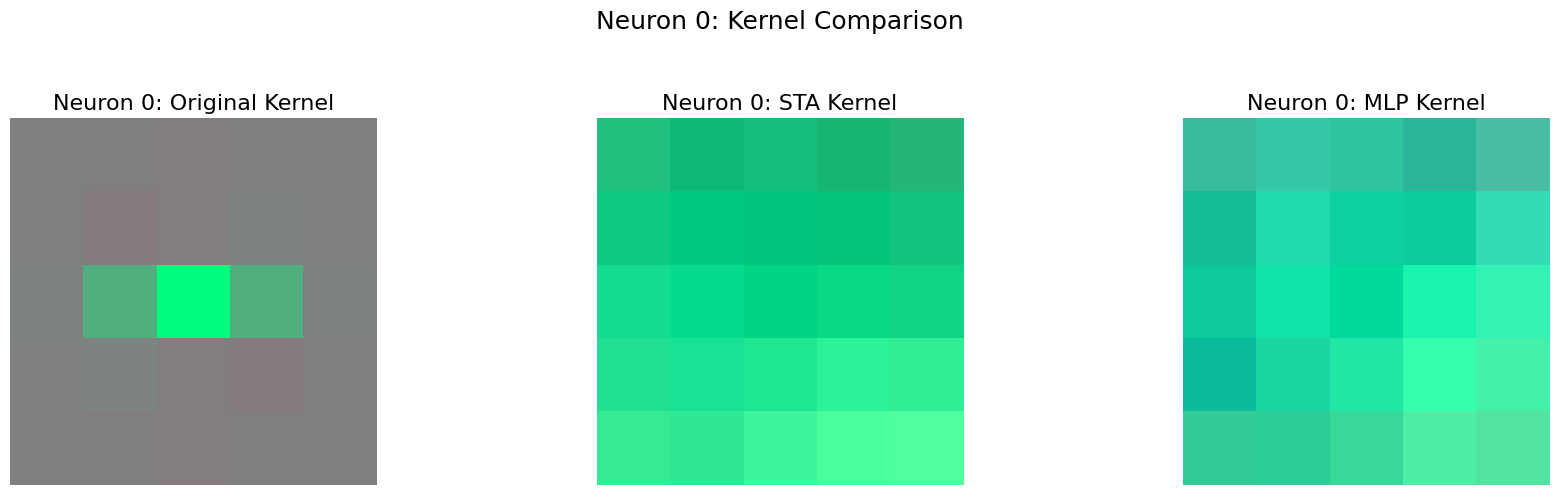

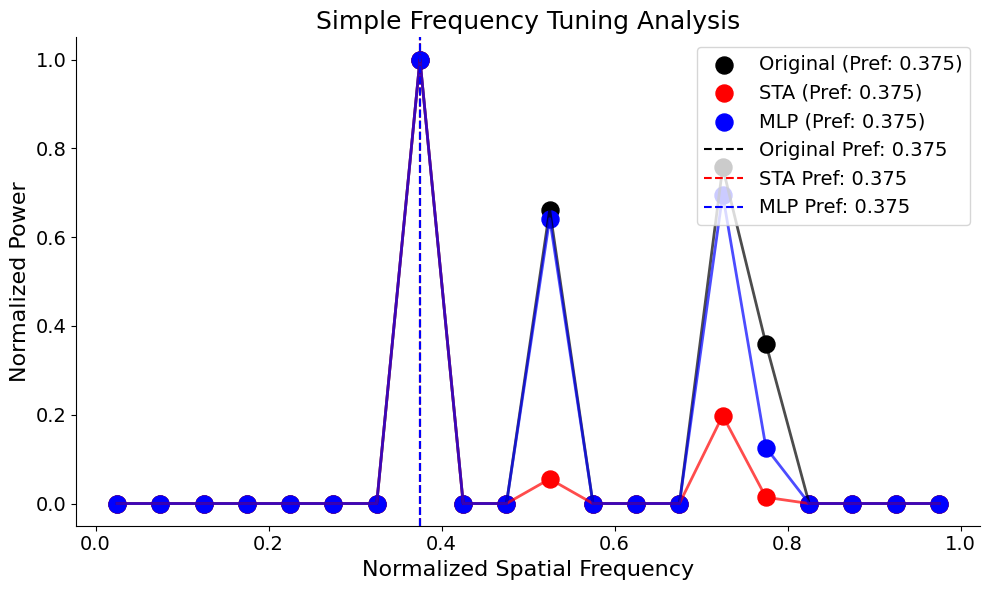

Neuron 0 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.375
  STA Preferred Frequency: 0.375
  MLP Preferred Frequency: 0.375


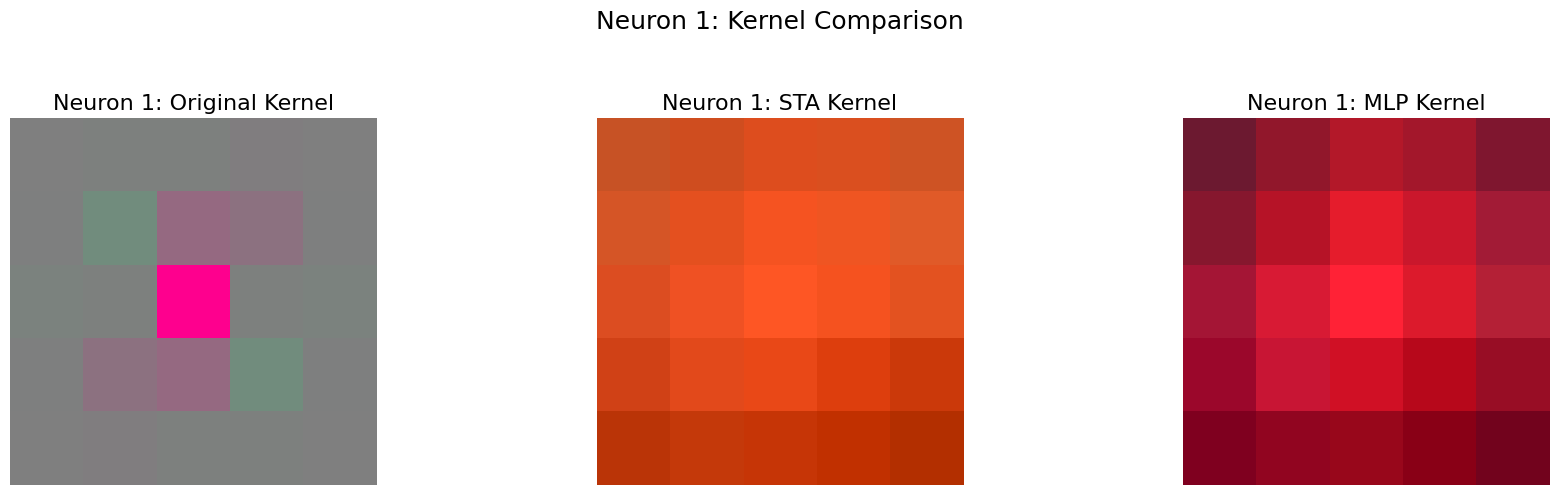

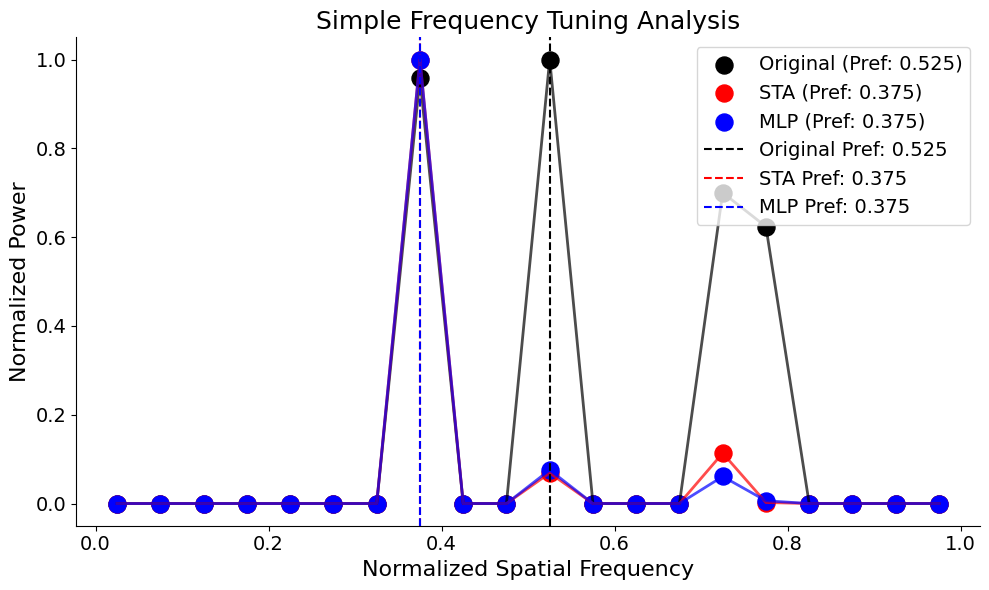

Neuron 1 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.525
  STA Preferred Frequency: 0.375
  MLP Preferred Frequency: 0.375


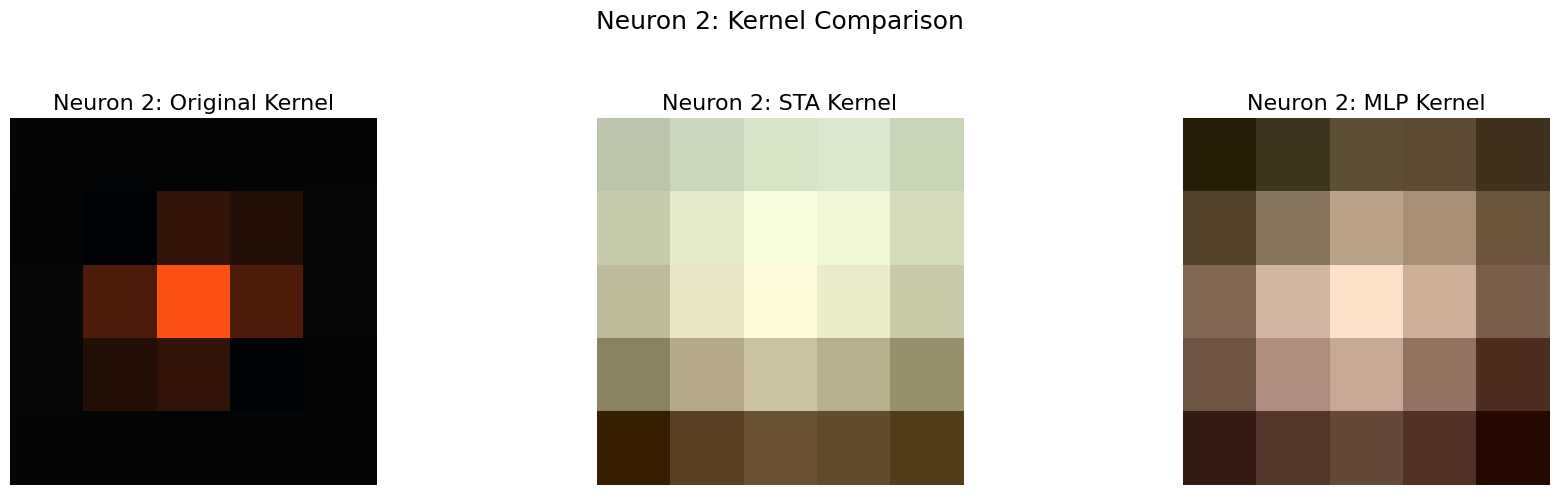

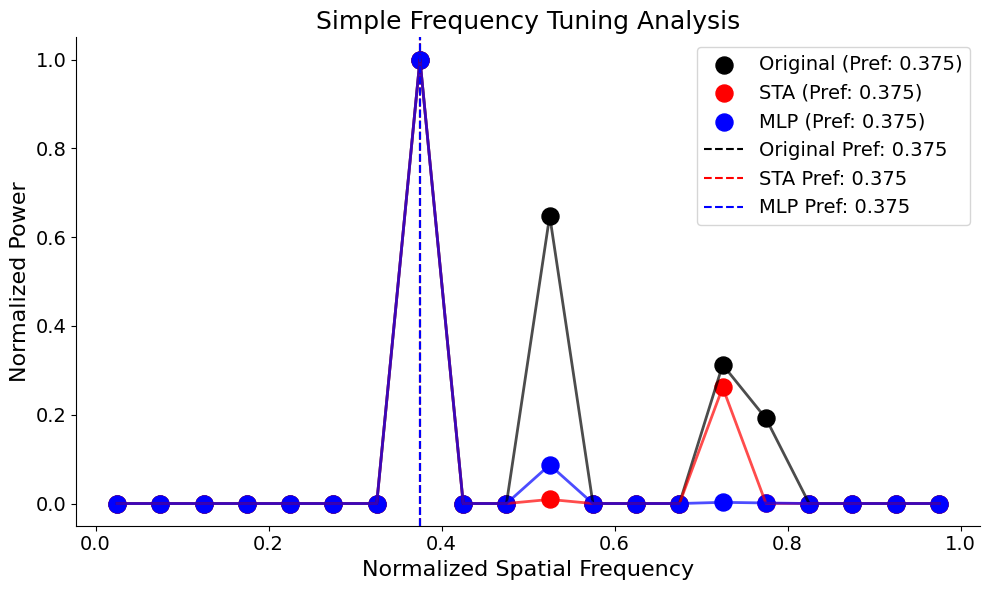

Neuron 2 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.375
  STA Preferred Frequency: 0.375
  MLP Preferred Frequency: 0.375


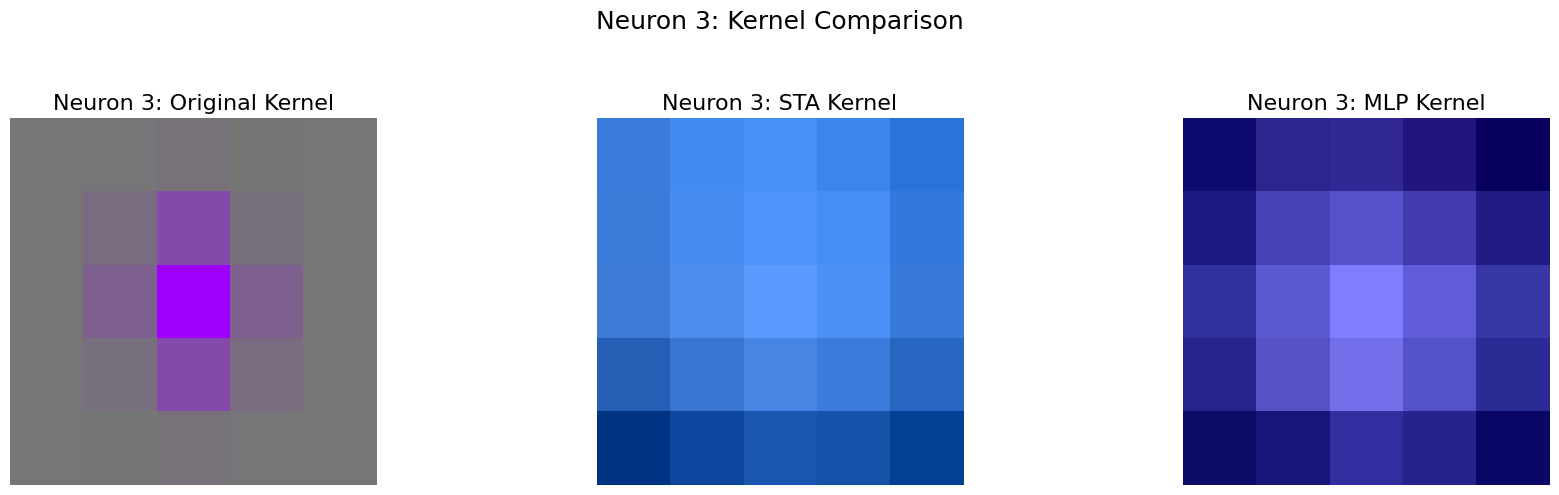

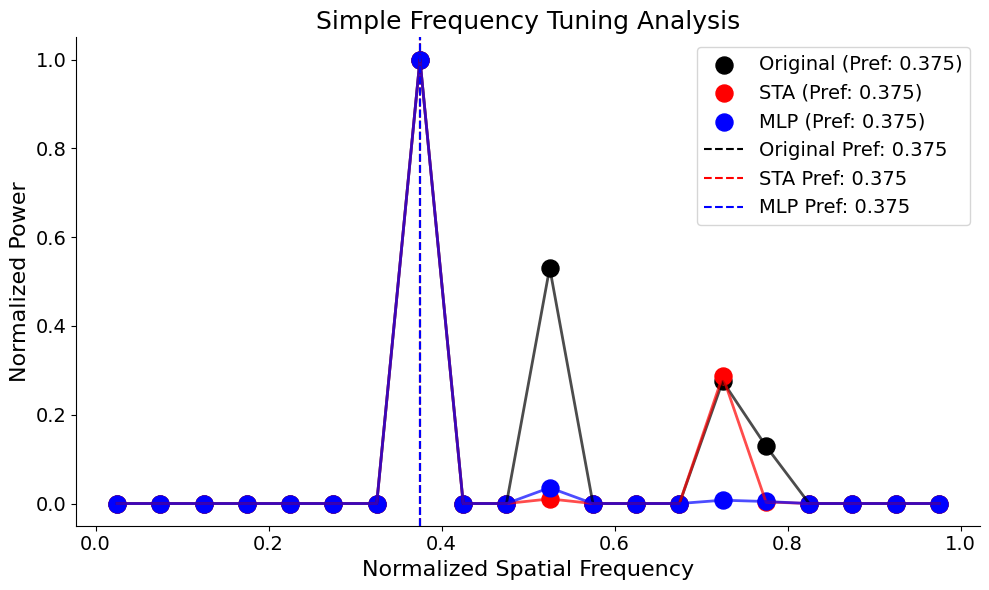

Neuron 3 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.375
  STA Preferred Frequency: 0.375
  MLP Preferred Frequency: 0.375


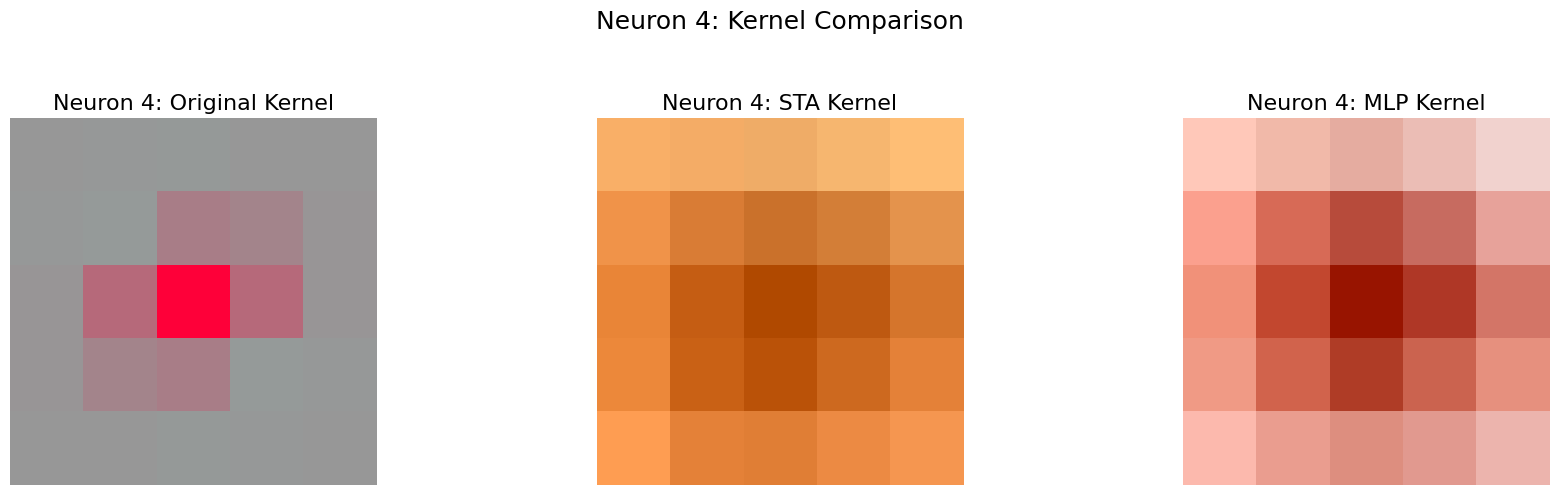

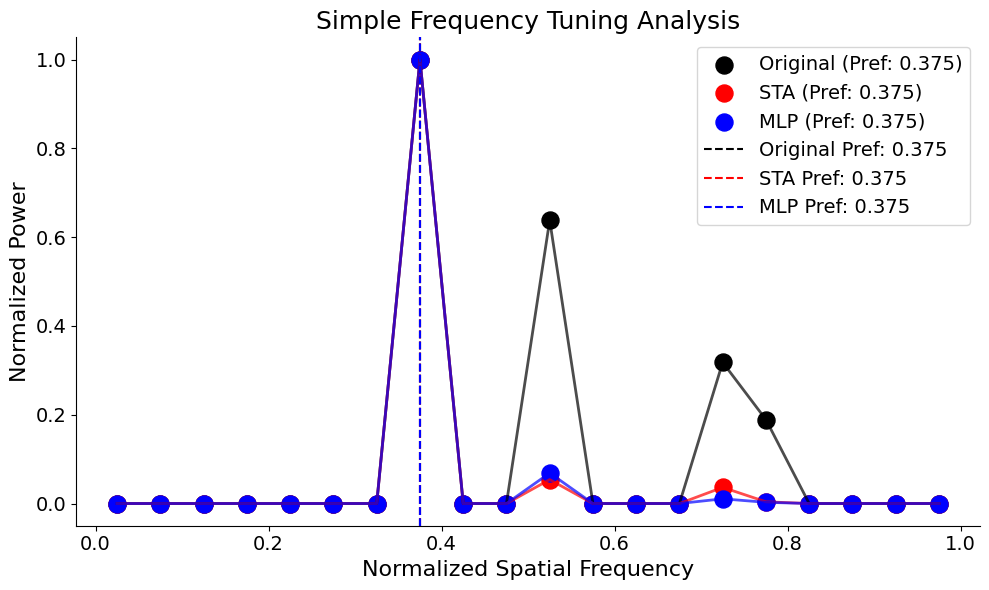

Neuron 4 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.375
  STA Preferred Frequency: 0.375
  MLP Preferred Frequency: 0.375


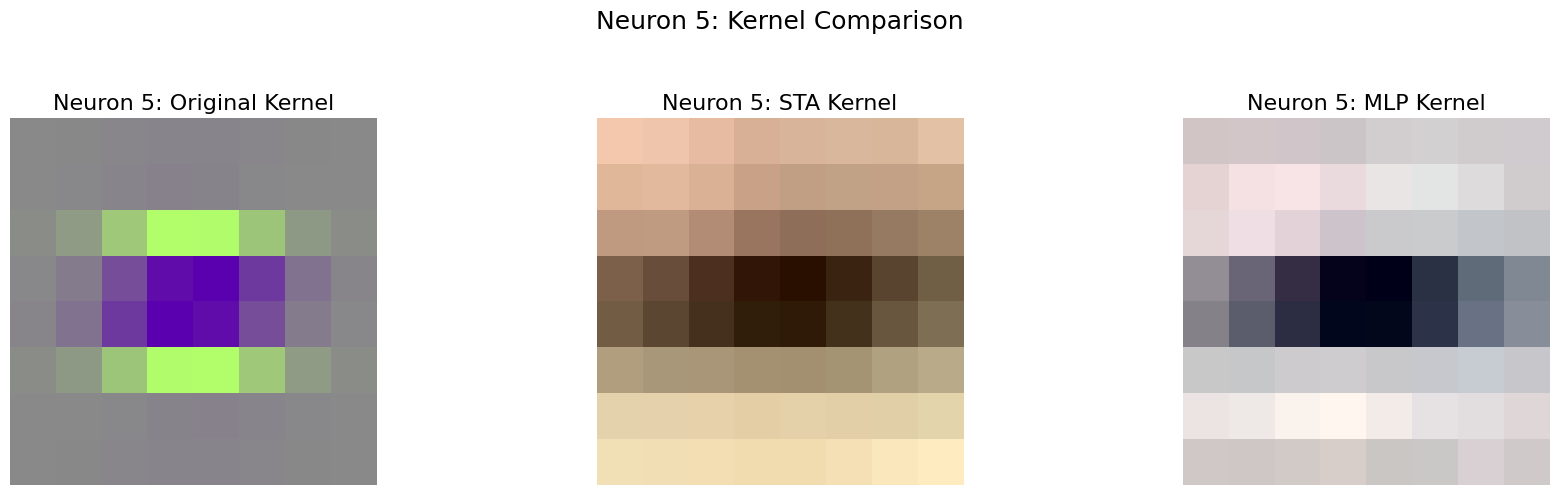

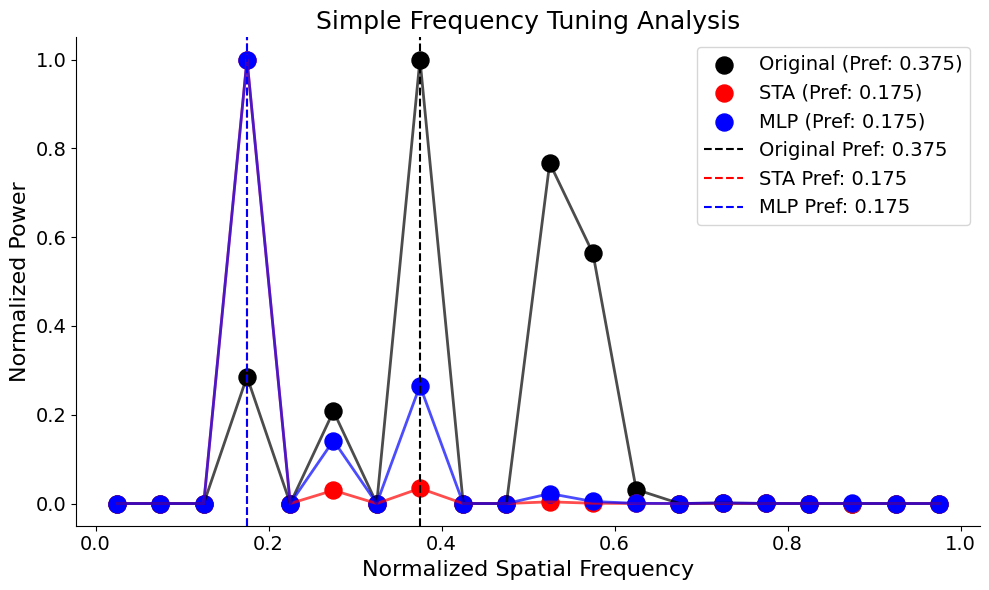

Neuron 5 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.375
  STA Preferred Frequency: 0.175
  MLP Preferred Frequency: 0.175


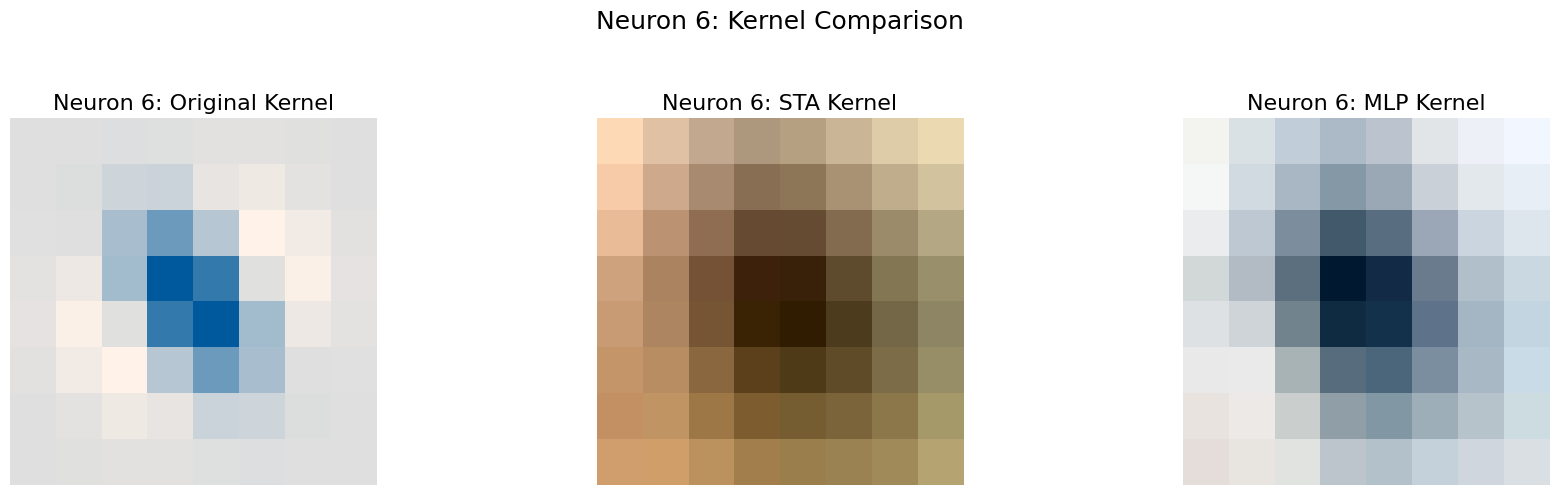

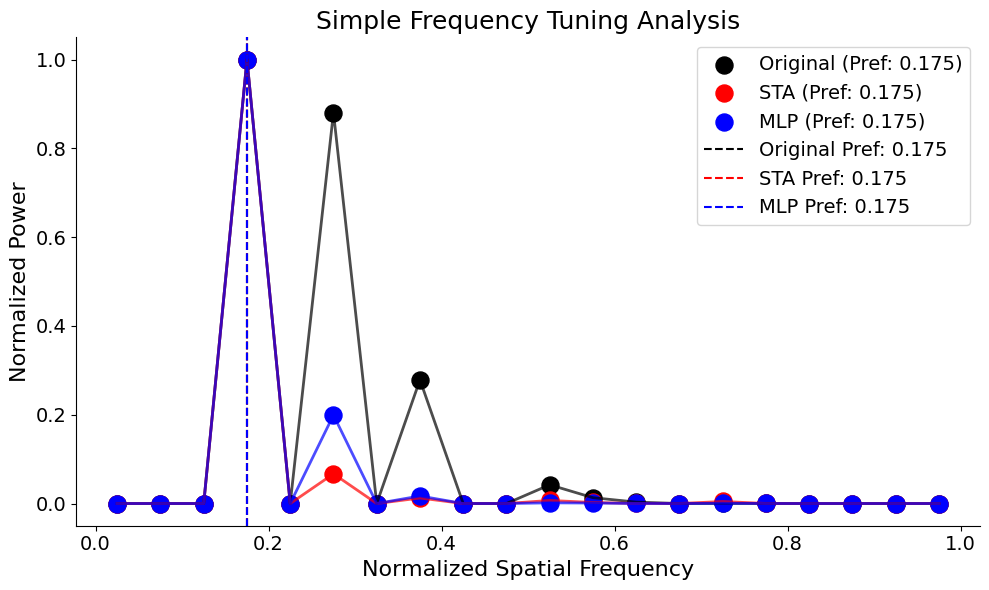

Neuron 6 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.175
  STA Preferred Frequency: 0.175
  MLP Preferred Frequency: 0.175


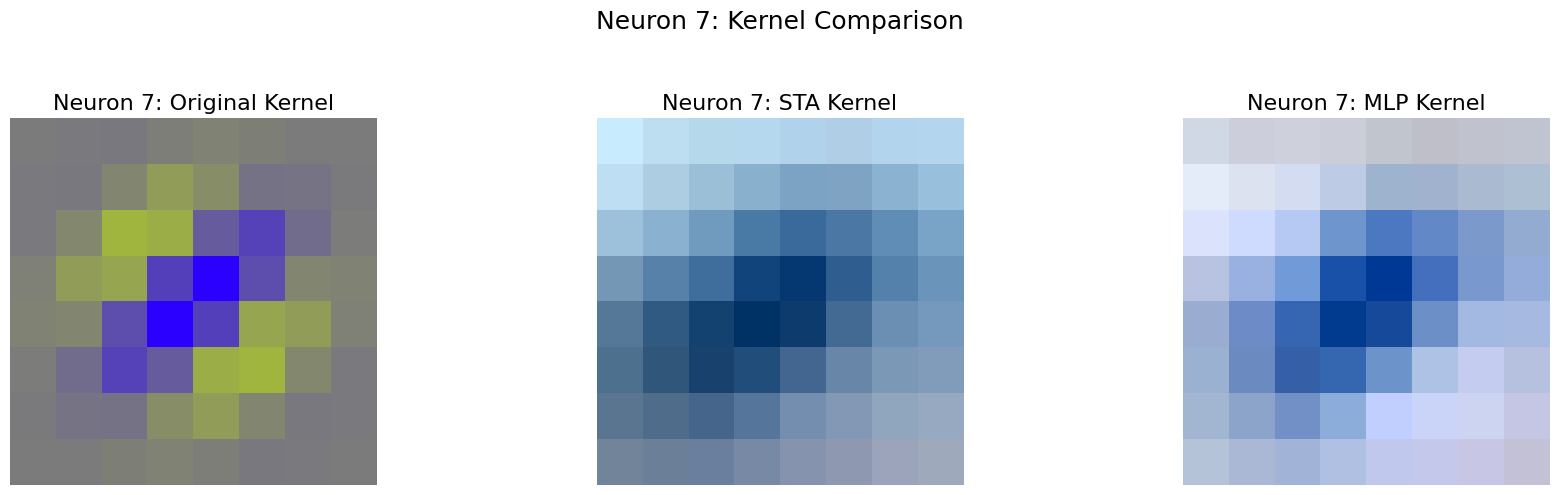

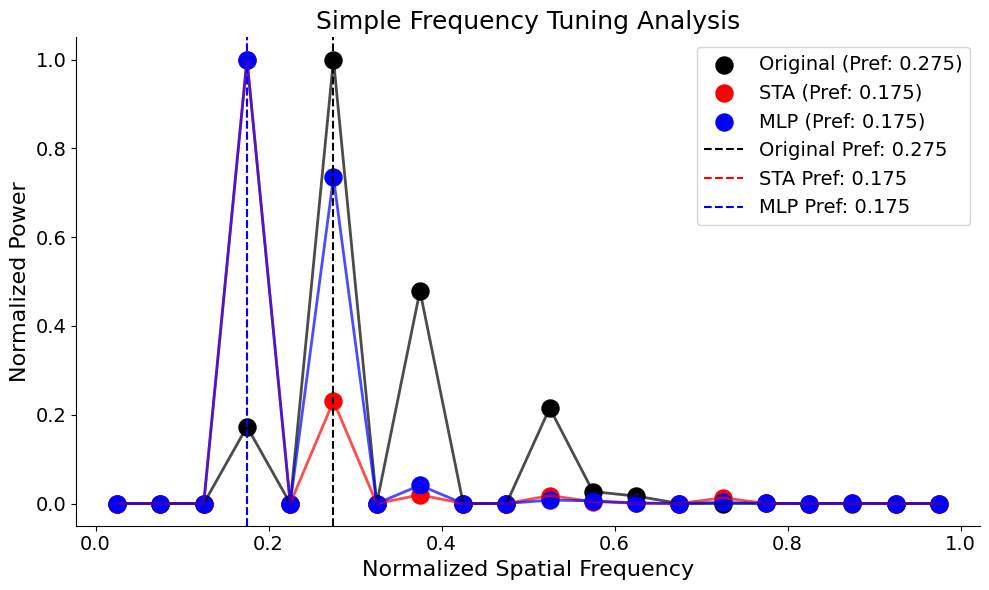

Neuron 7 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.275
  STA Preferred Frequency: 0.175
  MLP Preferred Frequency: 0.175


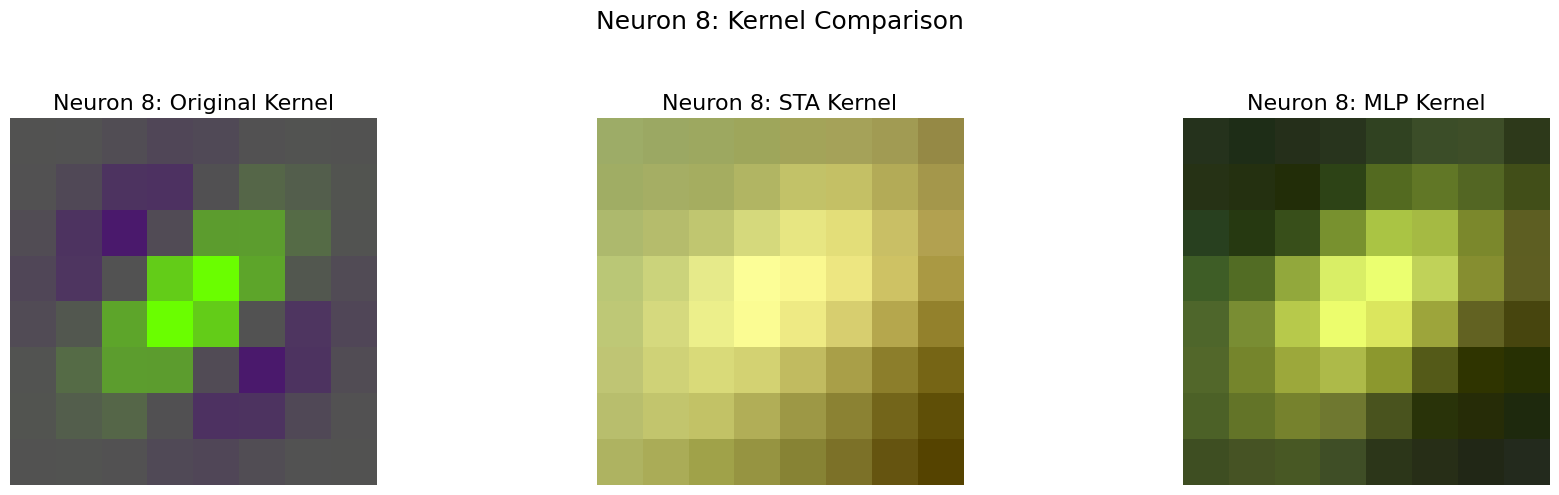

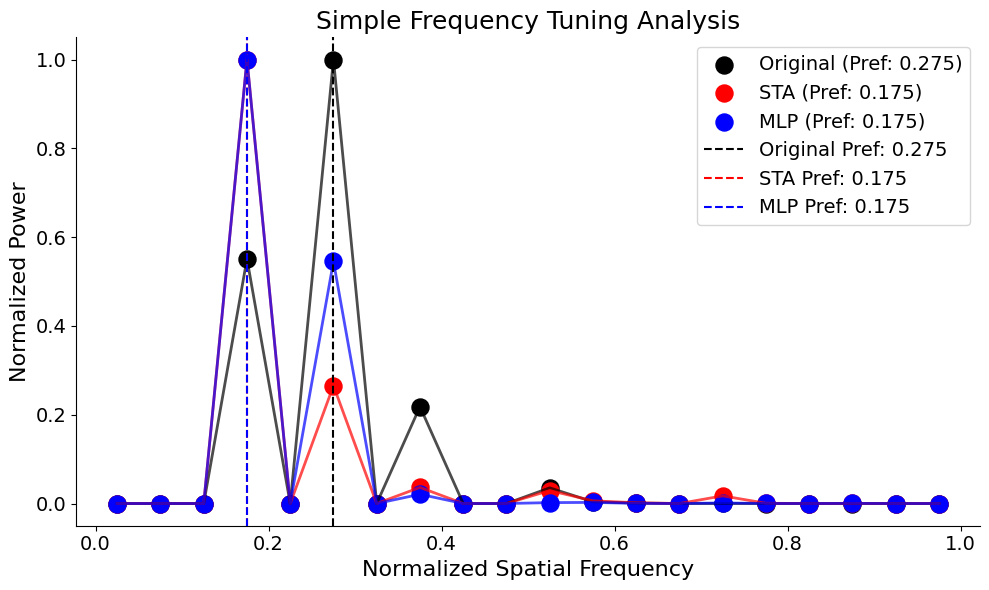

Neuron 8 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.275
  STA Preferred Frequency: 0.175
  MLP Preferred Frequency: 0.175


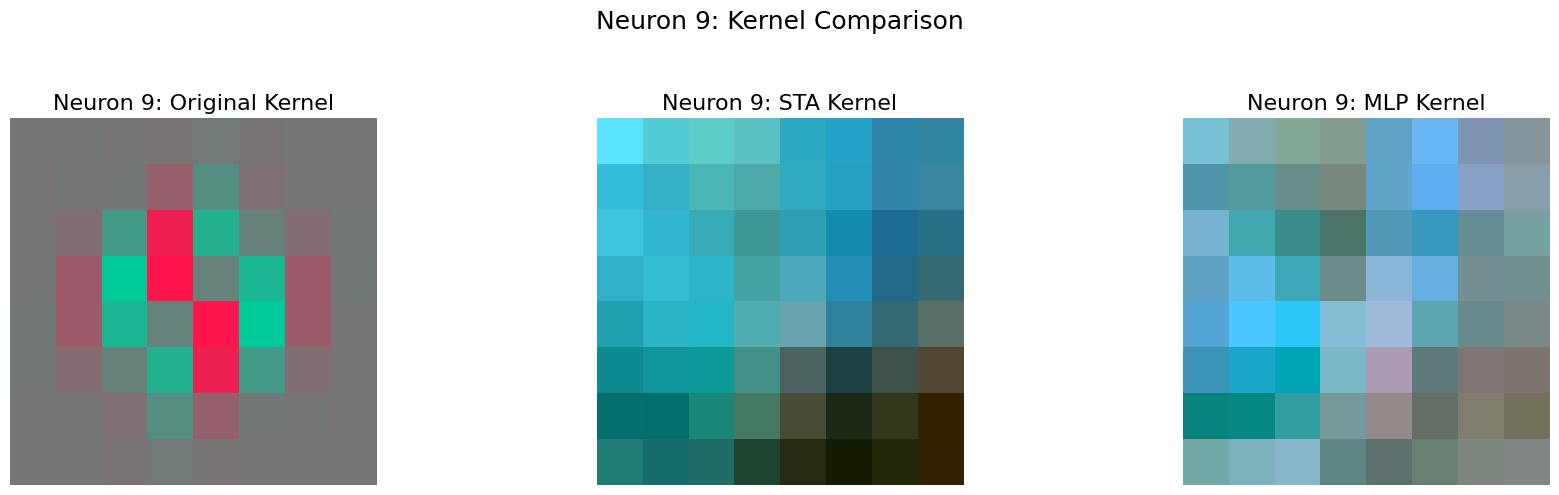

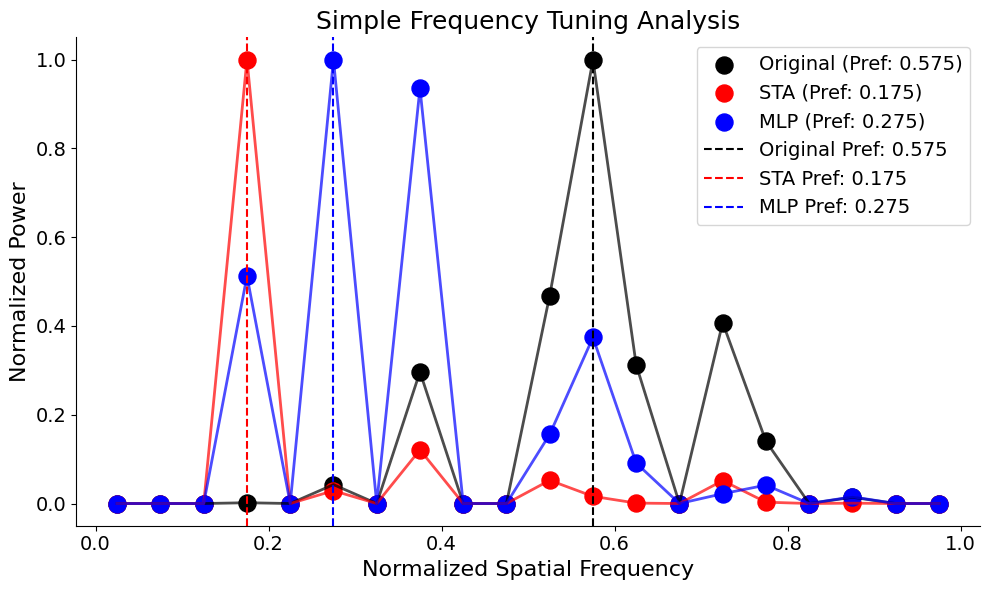

Neuron 9 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.575
  STA Preferred Frequency: 0.175
  MLP Preferred Frequency: 0.275


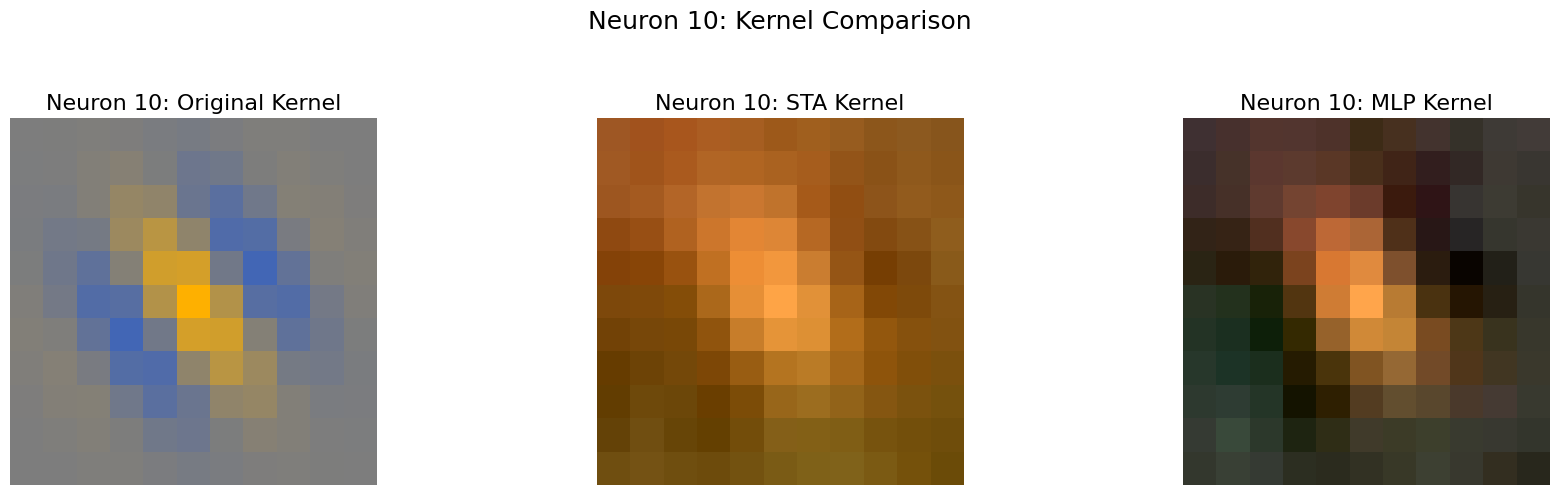

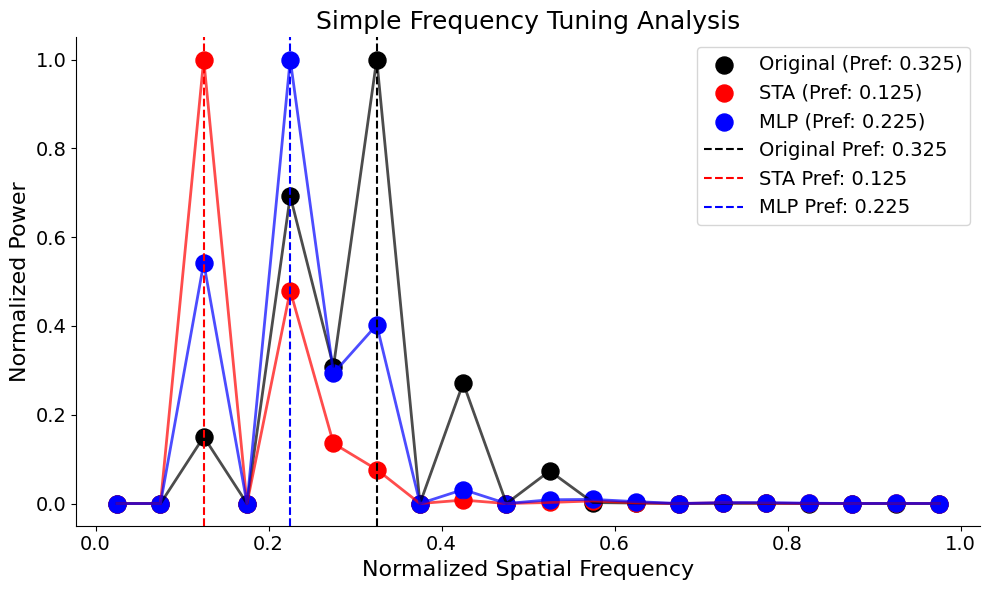

Neuron 10 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.325
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.225


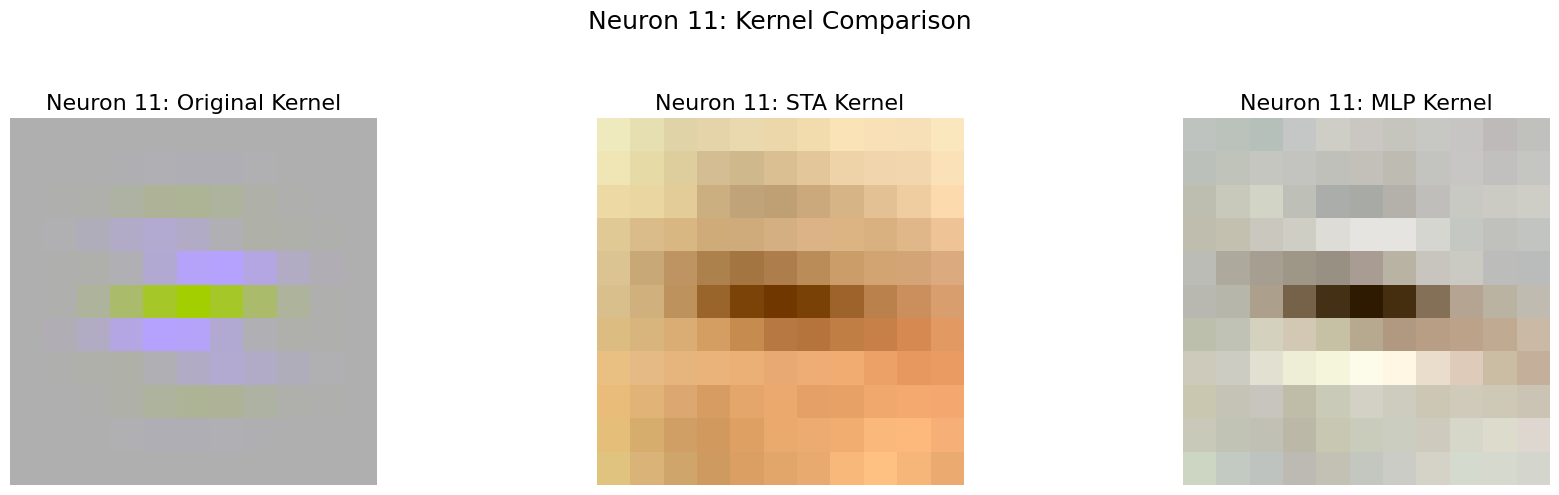

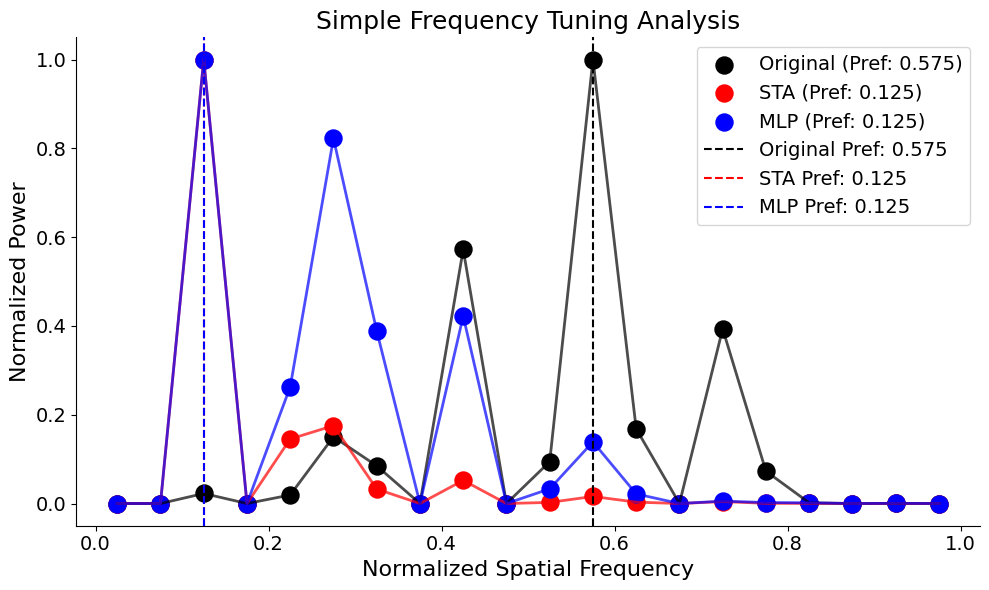

Neuron 11 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.575
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.125


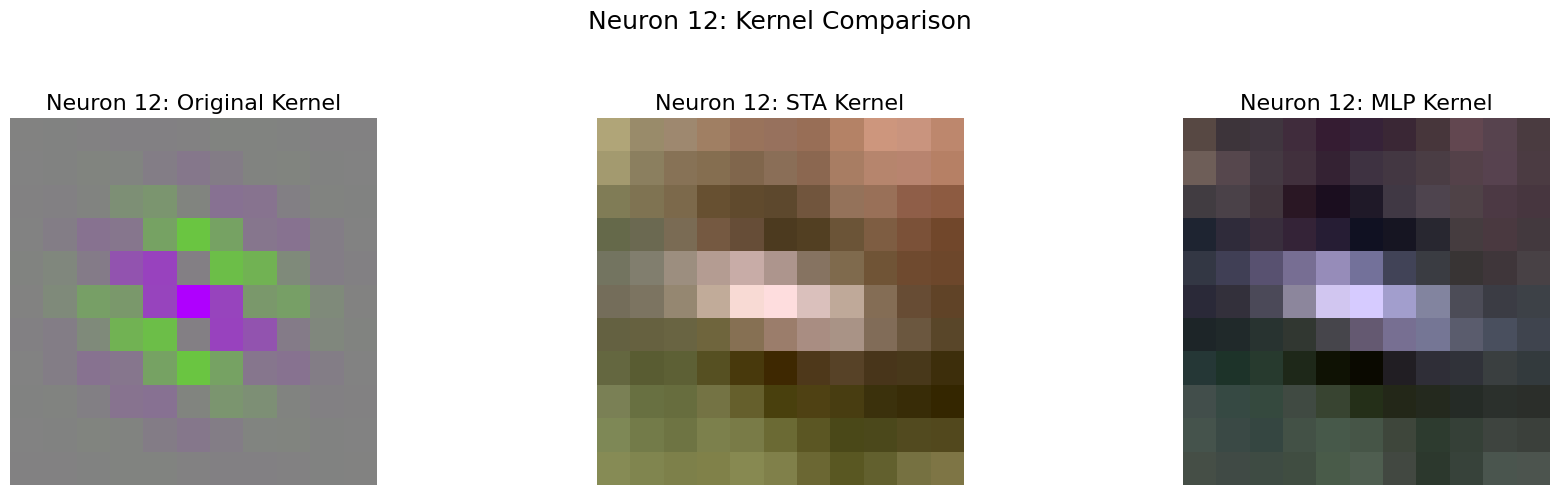

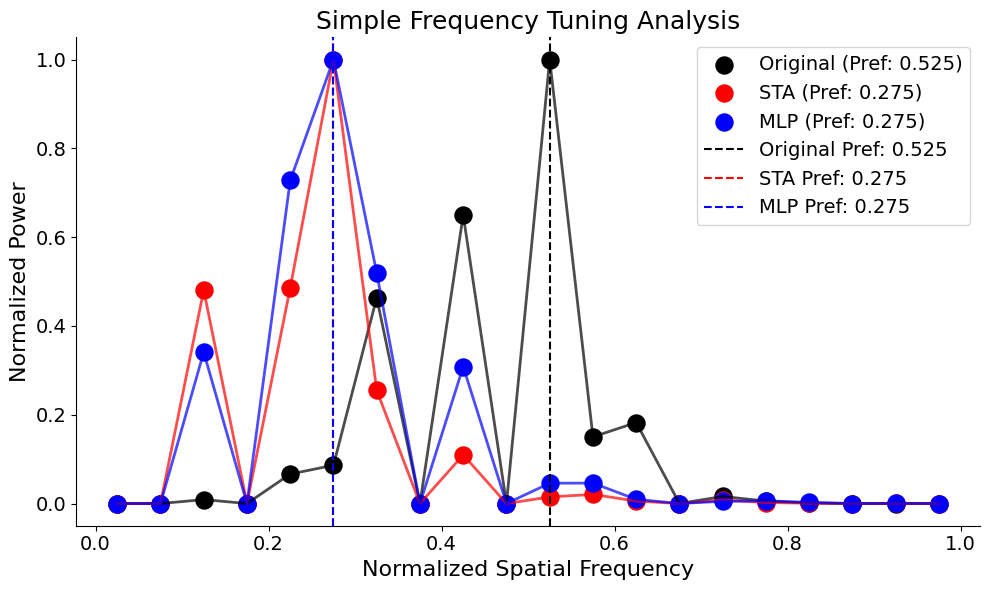

Neuron 12 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.525
  STA Preferred Frequency: 0.275
  MLP Preferred Frequency: 0.275


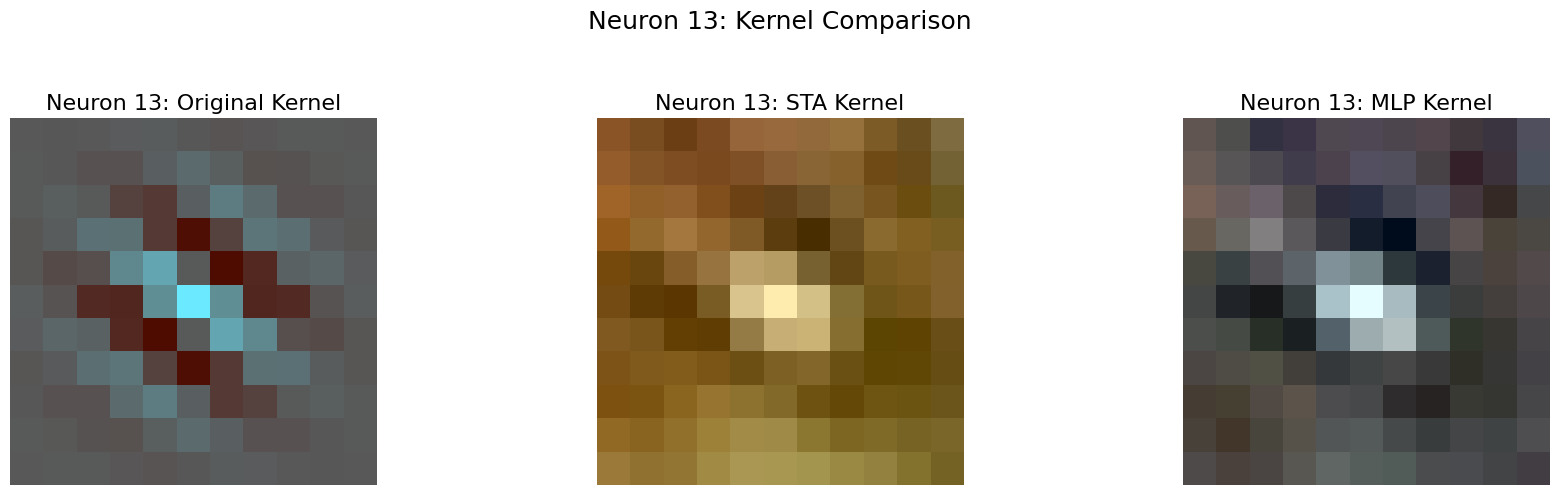

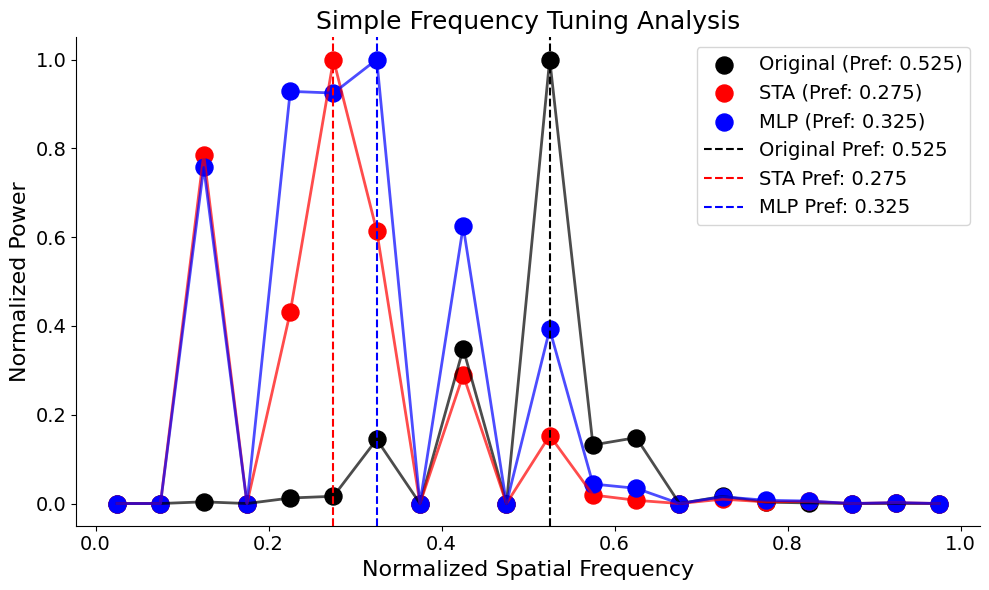

Neuron 13 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.525
  STA Preferred Frequency: 0.275
  MLP Preferred Frequency: 0.325


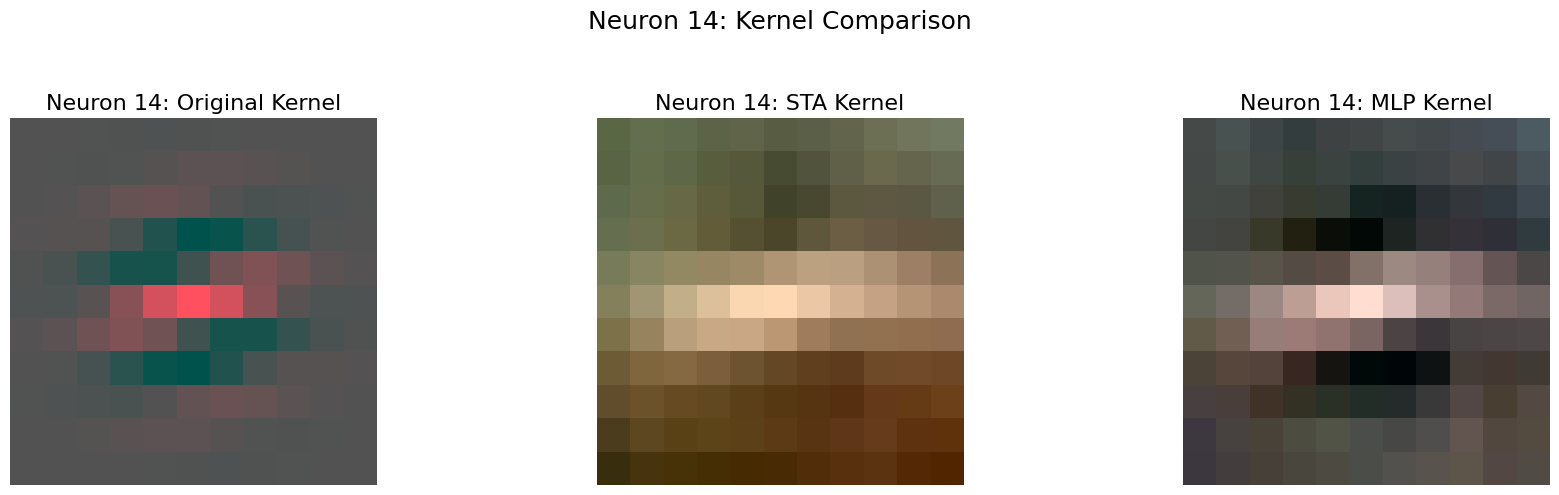

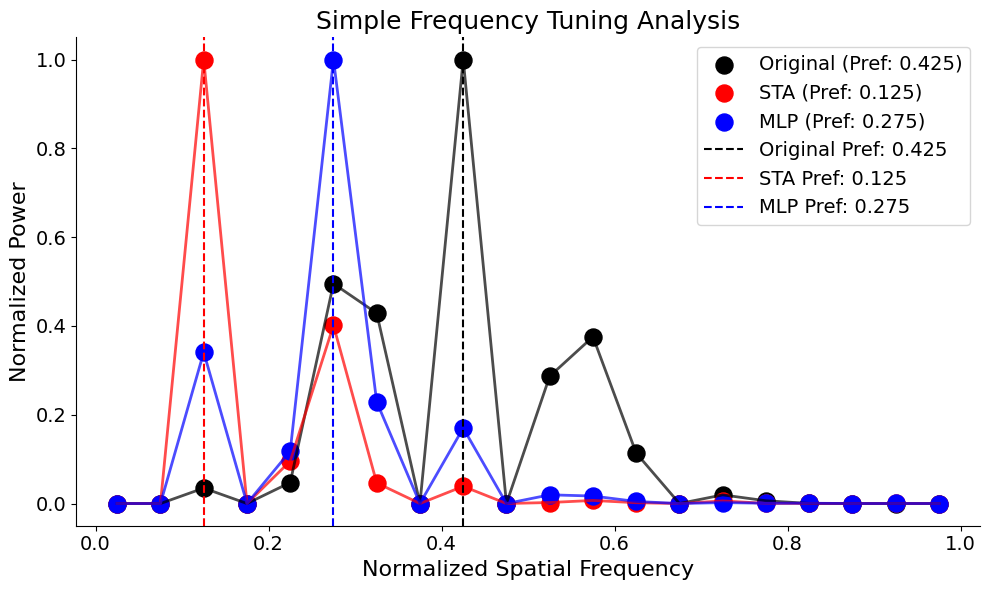

Neuron 14 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.425
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.275


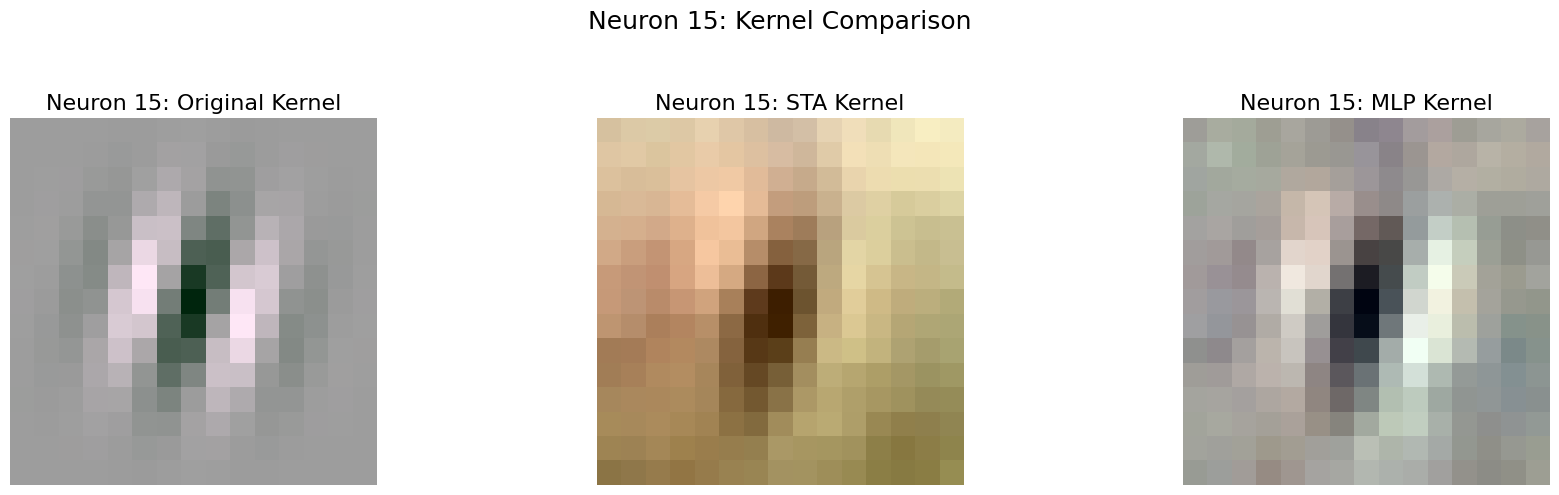

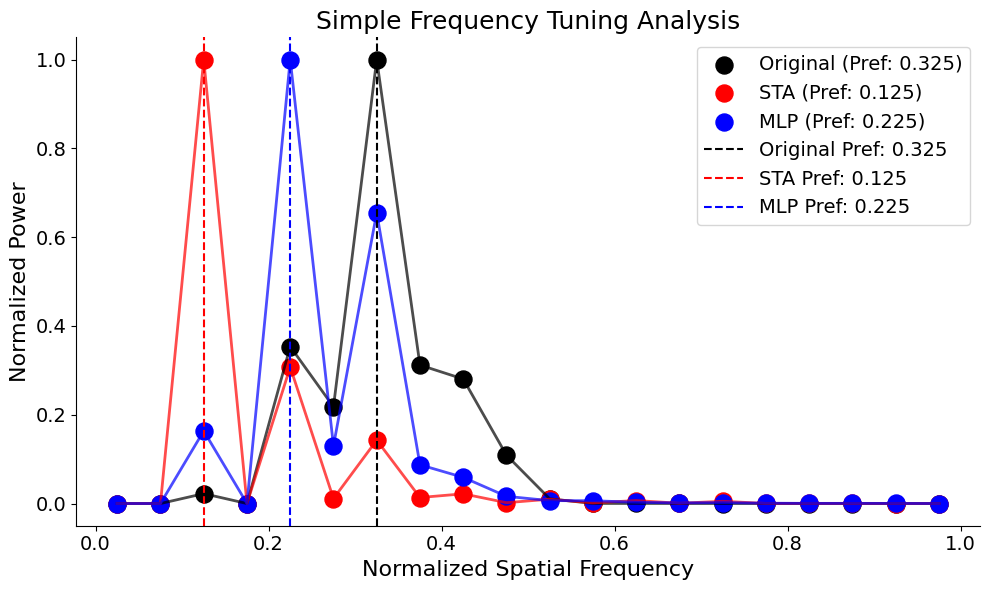

Neuron 15 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.325
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.225


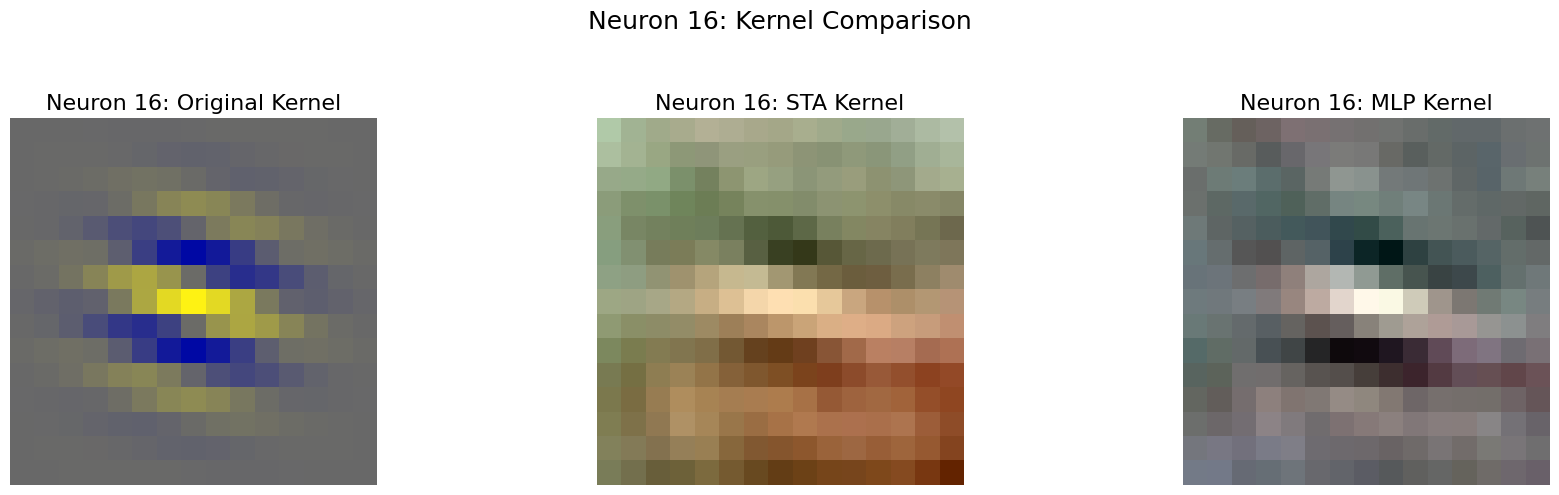

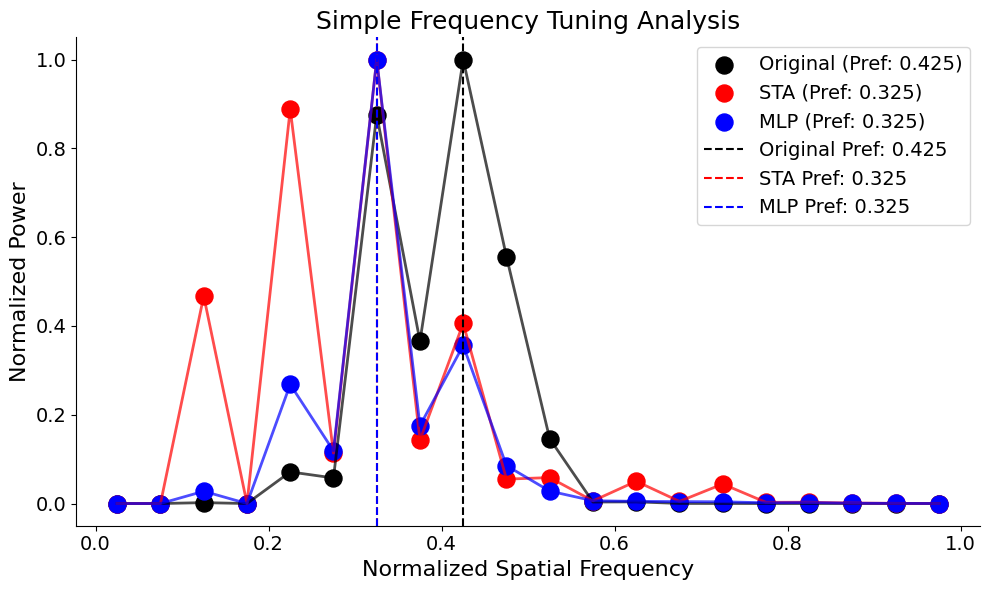

Neuron 16 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.425
  STA Preferred Frequency: 0.325
  MLP Preferred Frequency: 0.325


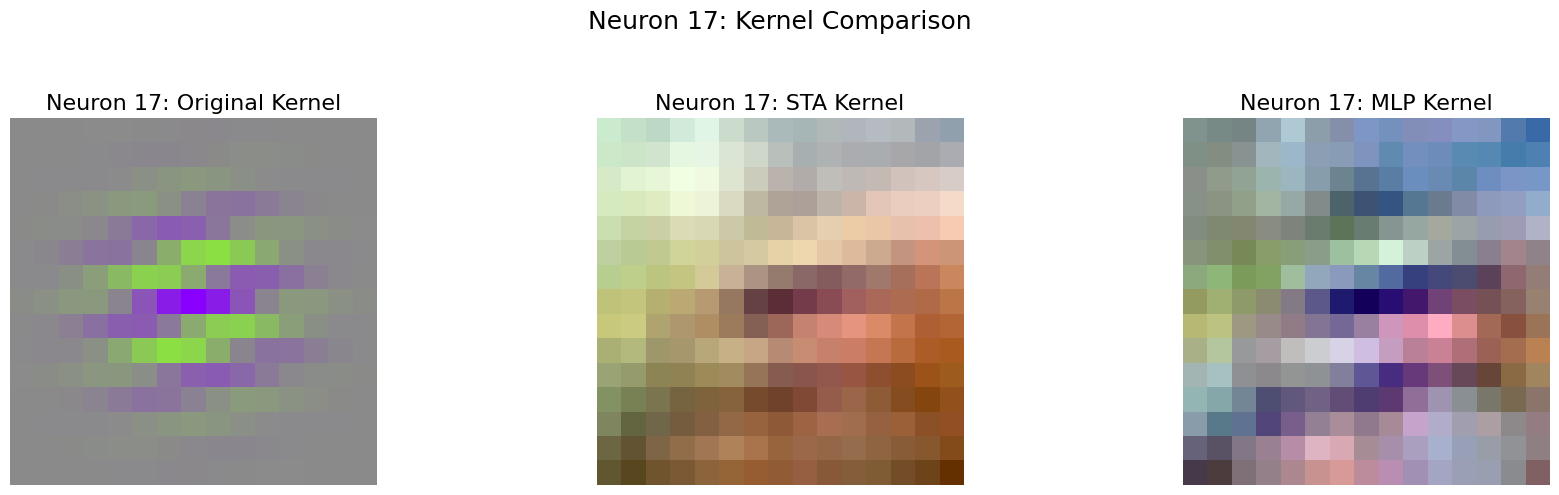

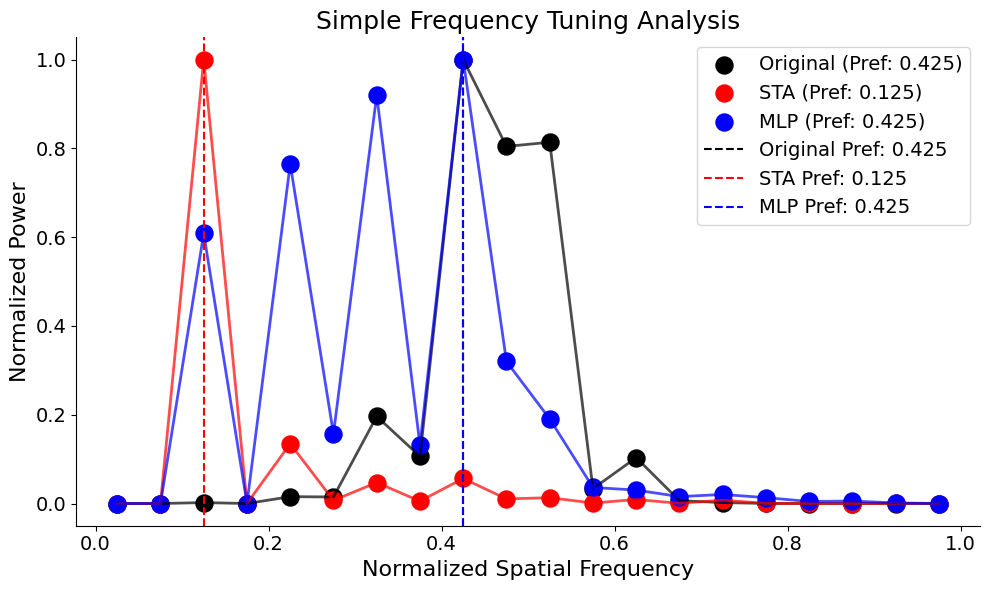

Neuron 17 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.425
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.425


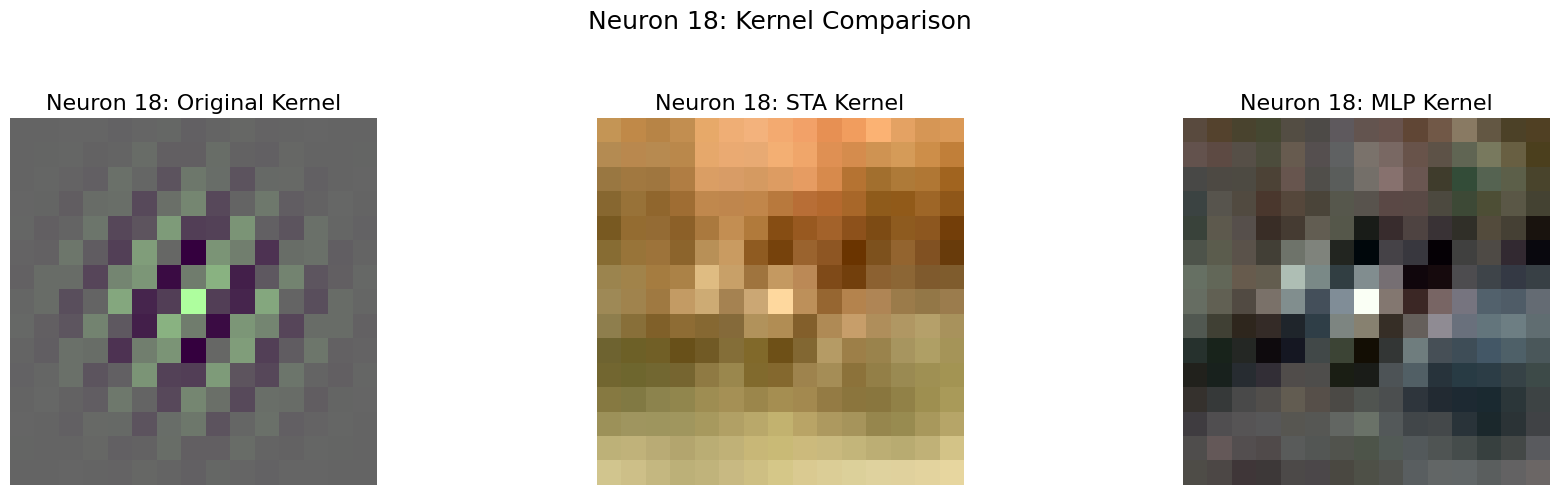

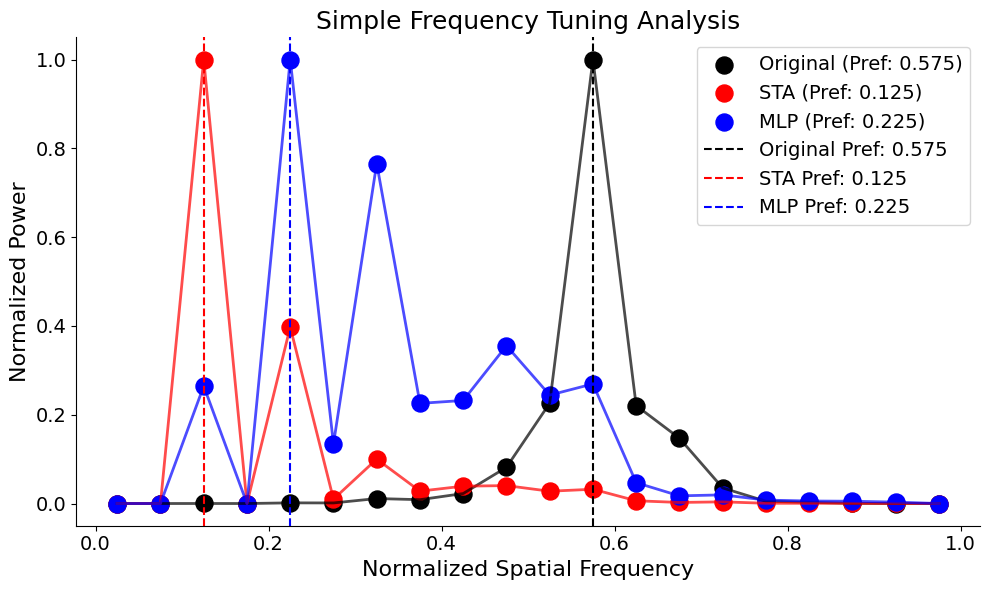

Neuron 18 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.575
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.225


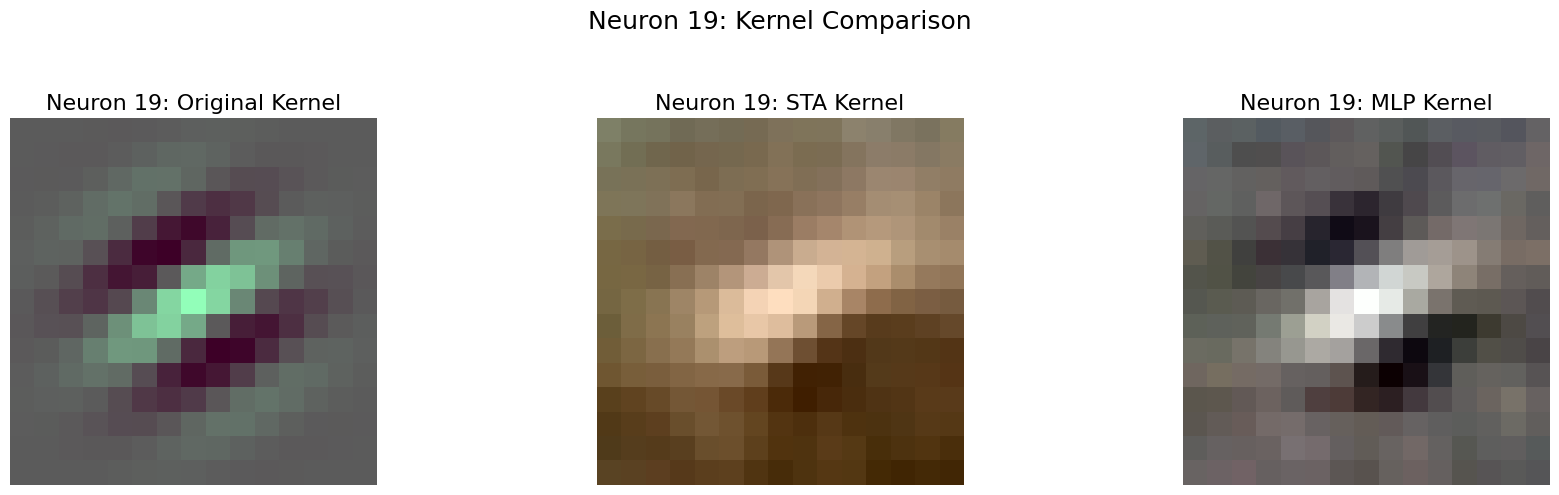

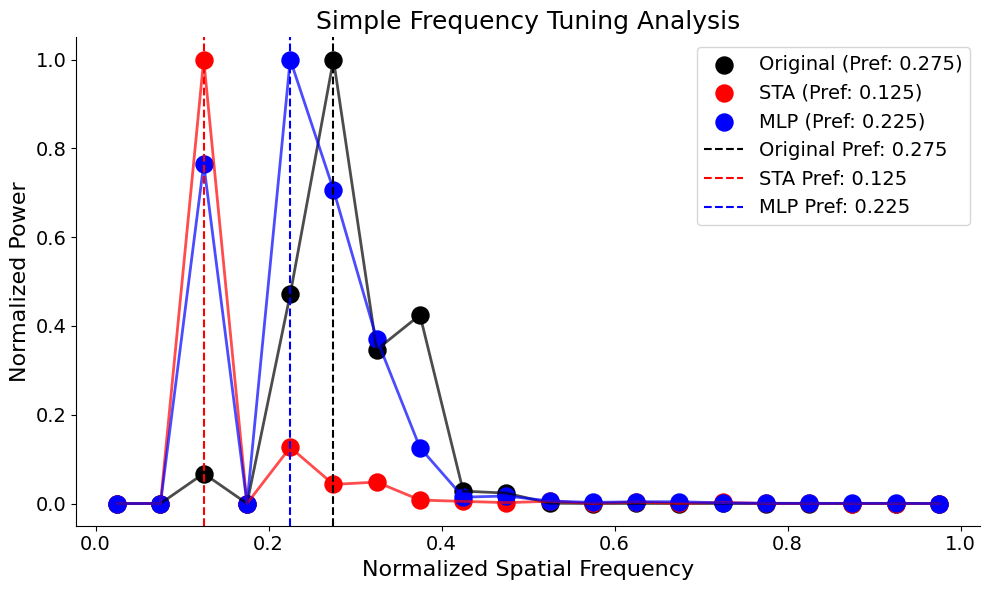

Neuron 19 Frequency Tuning Analysis Summary:
  Original Preferred Frequency: 0.275
  STA Preferred Frequency: 0.125
  MLP Preferred Frequency: 0.225


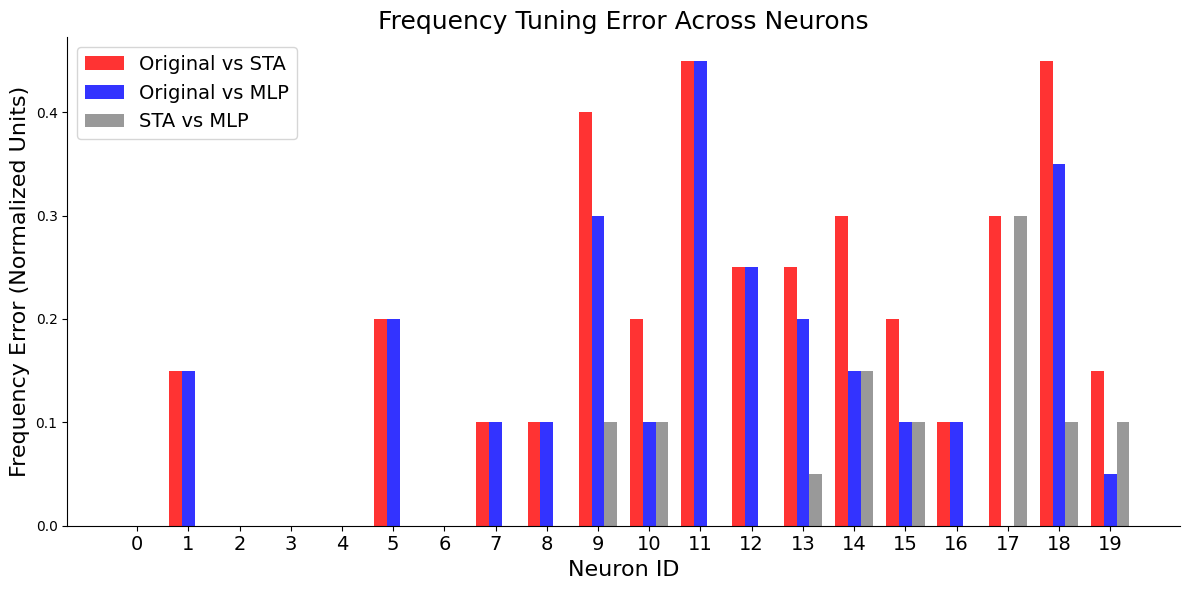

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)

def simple_frequency_tuning(kernel, num_bins=20):
    """
    Compute a simple frequency tuning curve using a radial average of the FFT power spectrum.

    Parameters:
      kernel : 2D or 3D ndarray
        The input kernel (if RGB, it is converted to grayscale).
      num_bins : int
        Number of bins for the radial profile.

    Returns:
      tuning_norm : 1D array
        Normalized frequency tuning curve.
      preferred_freq : float
        Frequency corresponding to the maximum response (in normalized units).
      freq_axis : 1D array
        The frequency bins (normalized spatial frequency).
    """
    if kernel.ndim == 3:
        kernel = np.mean(kernel, axis=2)
    kernel = kernel - np.mean(kernel)

    F = fftshift(fft2(kernel))
    power = np.abs(F)**2

    ny, nx = kernel.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_r = np.max(r)

    bins = np.linspace(0, max_r, num_bins + 1)
    tuning = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (r >= bins[i]) & (r < bins[i+1])
        tuning[i] = np.mean(power[mask]) if np.any(mask) else 0
    tuning_norm = tuning / (np.max(tuning) + 1e-10)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    freq_axis = bin_centers / max_r
    pref_idx = np.argmax(tuning_norm)
    preferred_freq = freq_axis[pref_idx]
    return tuning_norm, preferred_freq, freq_axis

def perform_frequency_tuning_analysis_three(neuron_id, sta_kernel, mlp_kernel, original_kernel, num_bins=20):
    """
    Compute simple frequency tuning analysis for three kernels:
    STA, MLP, and Original.
    """
    sta_tuning, sta_pref_freq, freq_axis = simple_frequency_tuning(sta_kernel, num_bins)
    mlp_tuning, mlp_pref_freq, _ = simple_frequency_tuning(mlp_kernel, num_bins)
    orig_tuning, orig_pref_freq, _ = simple_frequency_tuning(original_kernel, num_bins)

    return {
        "neuron_id": neuron_id,
        "freq_axis": freq_axis,
        "sta_freq_tuning": sta_tuning,
        "mlp_freq_tuning": mlp_tuning,
        "orig_freq_tuning": orig_tuning,
        "sta_pref_freq": sta_pref_freq,
        "mlp_pref_freq": mlp_pref_freq,
        "orig_pref_freq": orig_pref_freq
    }

def plot_frequency_tuning_analysis_three(analysis_results, sta_kernel, mlp_kernel, original_kernel):
    """
    Plot the three kernels side-by-side and their normalized frequency tuning curves.
    """
    neuron_id = analysis_results["neuron_id"]

    # Display kernels in a 1x3 layout.
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].imshow(norm_img(original_kernel))
    axes[0].set_title(f"Neuron {neuron_id}: Original Kernel", fontsize=16)
    axes[0].axis('off')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    axes[1].imshow(norm_img(sta_kernel))
    axes[1].set_title(f"Neuron {neuron_id}: STA Kernel", fontsize=16)
    axes[1].axis('off')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    axes[2].imshow(norm_img(mlp_kernel))
    axes[2].set_title(f"Neuron {neuron_id}: MLP Kernel", fontsize=16)
    axes[2].axis('off')
    axes[2].spines['top'].set_visible(False)
    axes[2].spines['right'].set_visible(False)

    plt.suptitle(f"Neuron {neuron_id}: Kernel Comparison", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    # Plot frequency tuning curves.
    plt.figure(figsize=(10, 6))
    freq_axis = analysis_results["freq_axis"]

    plt.scatter(freq_axis, analysis_results["orig_freq_tuning"], color='black', s=150,
                label=f"Original (Pref: {analysis_results['orig_pref_freq']:.3f})")
    plt.scatter(freq_axis, analysis_results["sta_freq_tuning"], color='red', s=150,
                label=f"STA (Pref: {analysis_results['sta_pref_freq']:.3f})")
    plt.scatter(freq_axis, analysis_results["mlp_freq_tuning"], color='blue', s=150,
                label=f"MLP (Pref: {analysis_results['mlp_pref_freq']:.3f})")

    plt.plot(freq_axis, analysis_results["orig_freq_tuning"], color='black', linewidth=2, alpha=0.7)
    plt.plot(freq_axis, analysis_results["sta_freq_tuning"], color='red', linewidth=2, alpha=0.7)
    plt.plot(freq_axis, analysis_results["mlp_freq_tuning"], color='blue', linewidth=2, alpha=0.7)

    # Add vertical lines for preferred frequencies.
    plt.axvline(x=analysis_results["orig_pref_freq"], color='black', linestyle='--',
                label=f"Original Pref: {analysis_results['orig_pref_freq']:.3f}")
    plt.axvline(x=analysis_results["sta_pref_freq"], color='red', linestyle='--',
                label=f"STA Pref: {analysis_results['sta_pref_freq']:.3f}")
    plt.axvline(x=analysis_results["mlp_pref_freq"], color='blue', linestyle='--',
                label=f"MLP Pref: {analysis_results['mlp_pref_freq']:.3f}")

    plt.xlabel("Normalized Spatial Frequency", fontsize=16)
    plt.ylabel("Normalized Power", fontsize=16)
    plt.title("Simple Frequency Tuning Analysis", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=14)

    ax = plt.gca()
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

# === Main Analysis Loop for Frequency Tuning Across Neurons ===
analysis_results_list = []

for neuron in selected_neurons:
    # Retrieve kernels.
    # v1_cells[neuron] returns (original_kernel, freq, size, coords)
    original_kernel, freq, size, coords = v1_cells[neuron]

    # Retrieve STA and MLP kernels.
    sta_kernel_full = sta_results[neuron]
    mlp_kernel_full = mlp_weights[neuron]

    # Crop STA and MLP kernels to the receptive field.
    cropped_sta = sta_kernel_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    cropped_mlp = mlp_kernel_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # (Assume original_kernel is already the correct size.)

    # Perform frequency tuning analysis for the three kernels.
    analysis = perform_frequency_tuning_analysis_three(neuron, cropped_sta, cropped_mlp, original_kernel, num_bins=20)
    analysis_results_list.append(analysis)

    # Plot kernels and tuning curves.
    plot_frequency_tuning_analysis_three(analysis, cropped_sta, cropped_mlp, original_kernel)

    # Print summary.
    print(f"Neuron {neuron} Frequency Tuning Analysis Summary:")
    print(f"  Original Preferred Frequency: {analysis['orig_pref_freq']:.3f}")
    print(f"  STA Preferred Frequency: {analysis['sta_pref_freq']:.3f}")
    print(f"  MLP Preferred Frequency: {analysis['mlp_pref_freq']:.3f}")

# === Final Summary Plots Across Neurons ===
# Compute frequency errors (absolute differences) for each pair.
neuron_ids = [res["neuron_id"] for res in analysis_results_list]
err_orig_sta = [abs(res["orig_pref_freq"] - res["sta_pref_freq"]) for res in analysis_results_list]
err_orig_mlp = [abs(res["orig_pref_freq"] - res["mlp_pref_freq"]) for res in analysis_results_list]
err_sta_mlp = [abs(res["sta_pref_freq"] - res["mlp_pref_freq"]) for res in analysis_results_list]

x = np.arange(len(neuron_ids))
width = 0.25

# Plot frequency errors.
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, err_orig_sta, width, label='Original vs STA', color='red', alpha=0.8)
ax.bar(x, err_orig_mlp, width, label='Original vs MLP', color='blue', alpha=0.8)
ax.bar(x + width, err_sta_mlp, width, label='STA vs MLP', color='gray', alpha=0.8)

ax.set_xlabel("Neuron ID", fontsize=16)
ax.set_ylabel("Frequency Error (Normalized Units)", fontsize=16)
ax.set_title("Frequency Tuning Error Across Neurons", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(neuron_ids, fontsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


# Color tuning

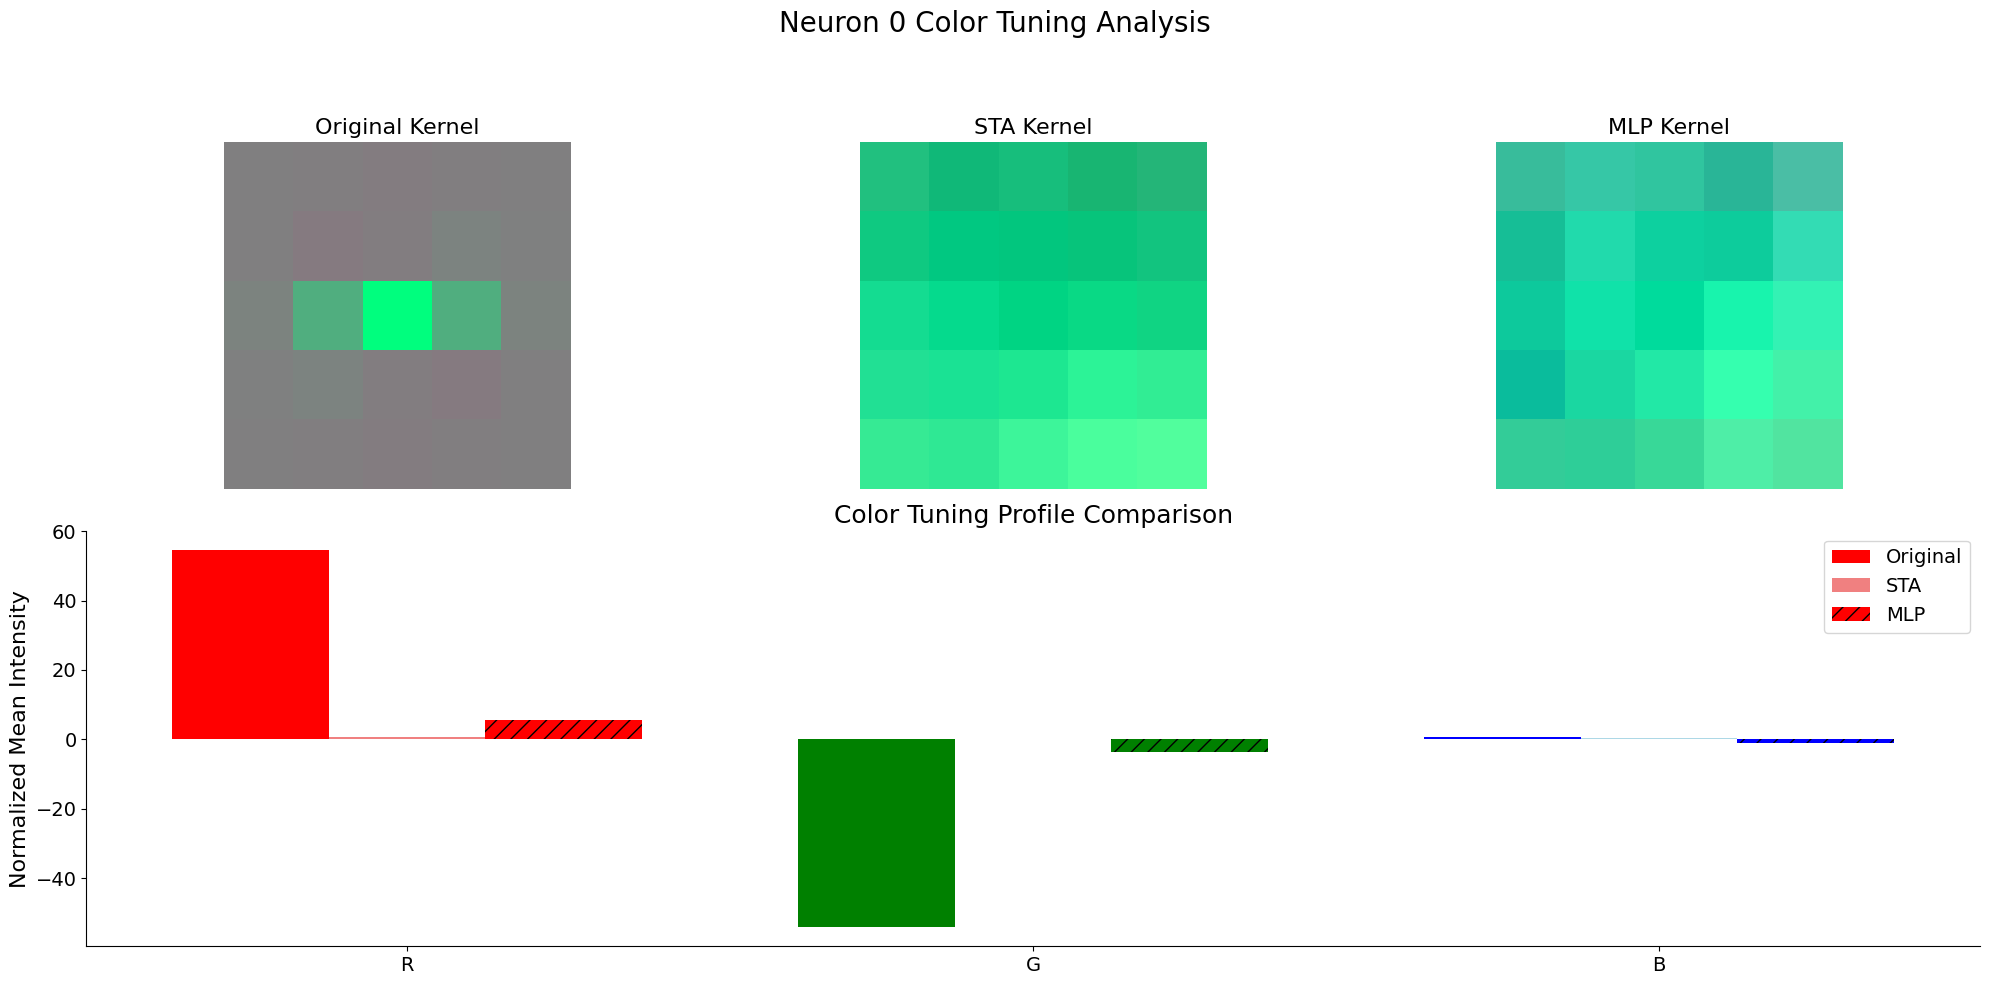

Neuron 0 Color Profiles:
  Original: [ 54.65648956 -54.20084044   0.54435197]
  STA:      [0.59388159 0.09947619 0.30664222]
  MLP:      [ 5.555619  -3.6479075 -0.9077114]


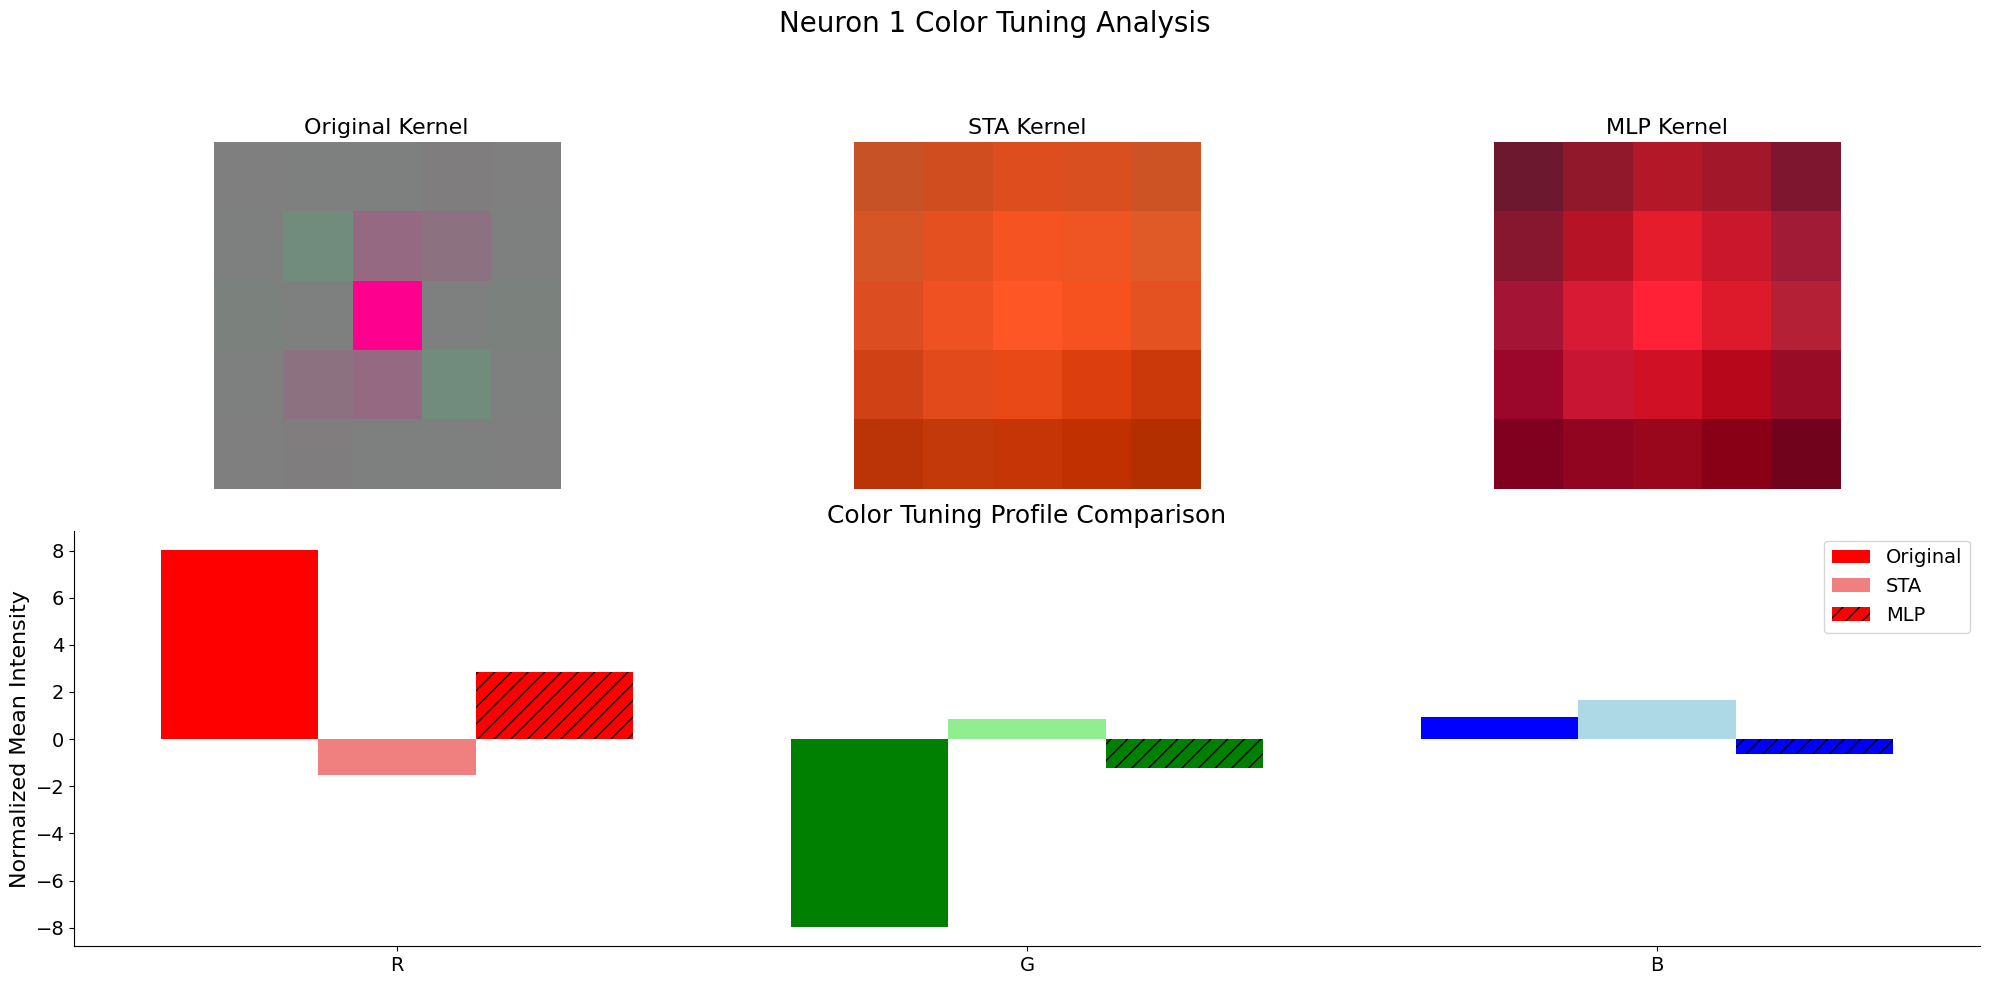

Neuron 1 Color Profiles:
  Original: [ 8.03344298 -7.9845524   0.9511093 ]
  STA:      [-1.51524177  0.86463564  1.65060613]
  MLP:      [ 2.8525517 -1.2429988 -0.6095528]


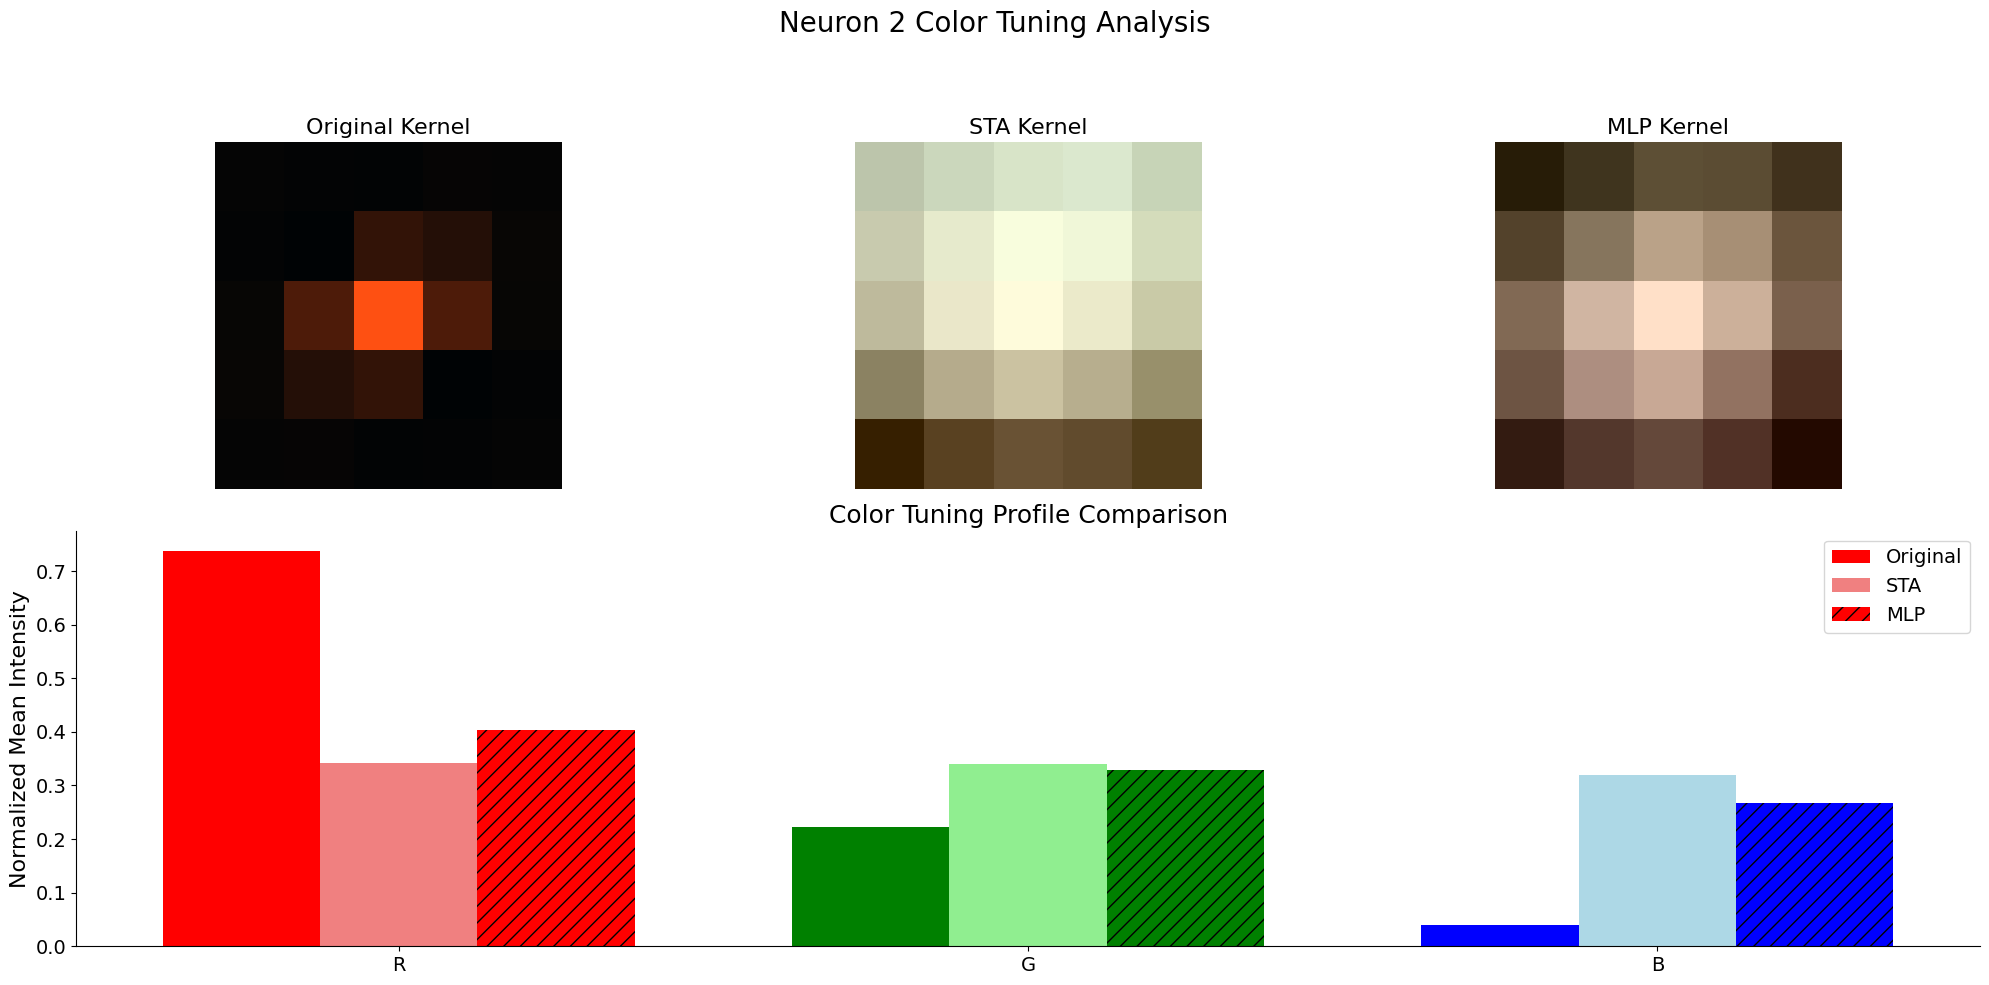

Neuron 2 Color Profiles:
  Original: [0.73803503 0.22296792 0.03899704]
  STA:      [0.34143015 0.33924183 0.31932803]
  MLP:      [0.40336066 0.32875437 0.26788494]


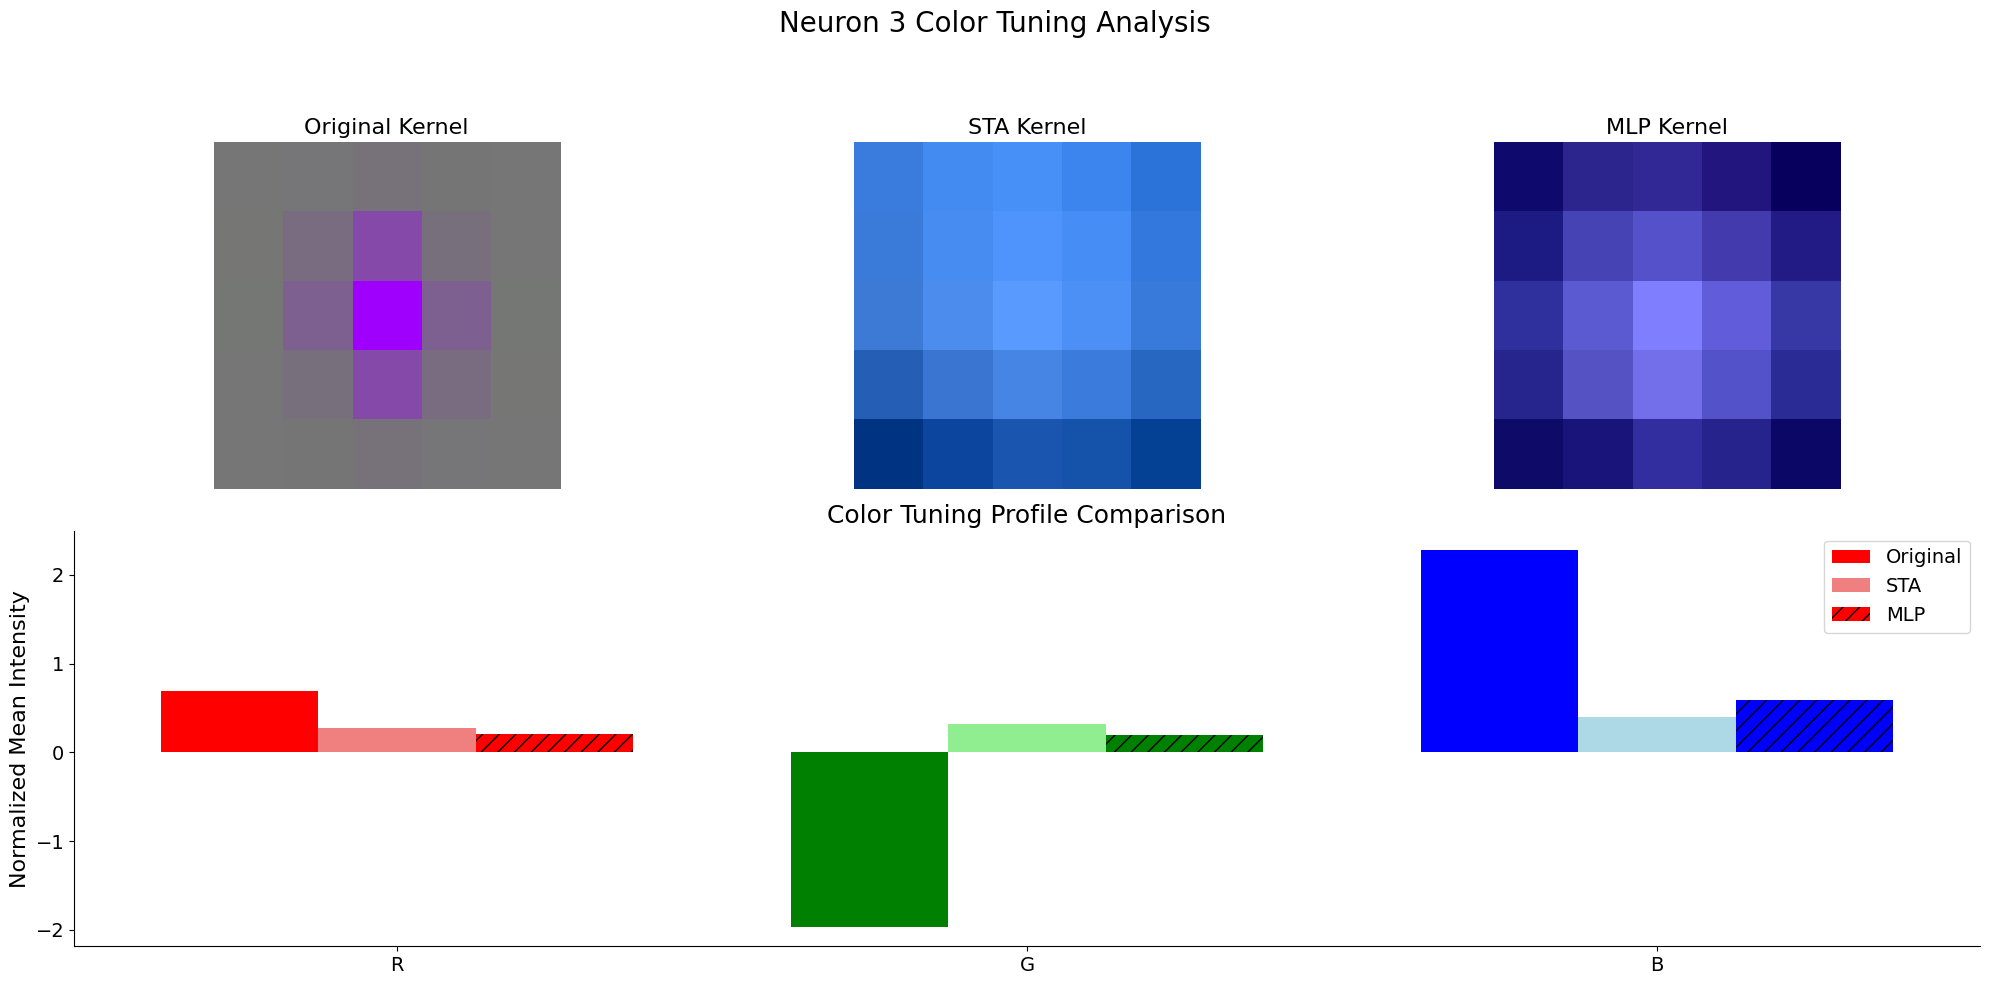

Neuron 3 Color Profiles:
  Original: [ 0.68917068 -1.97077656  2.28160587]
  STA:      [0.27291534 0.32504774 0.40203692]
  MLP:      [0.2116904  0.19780679 0.5905028 ]


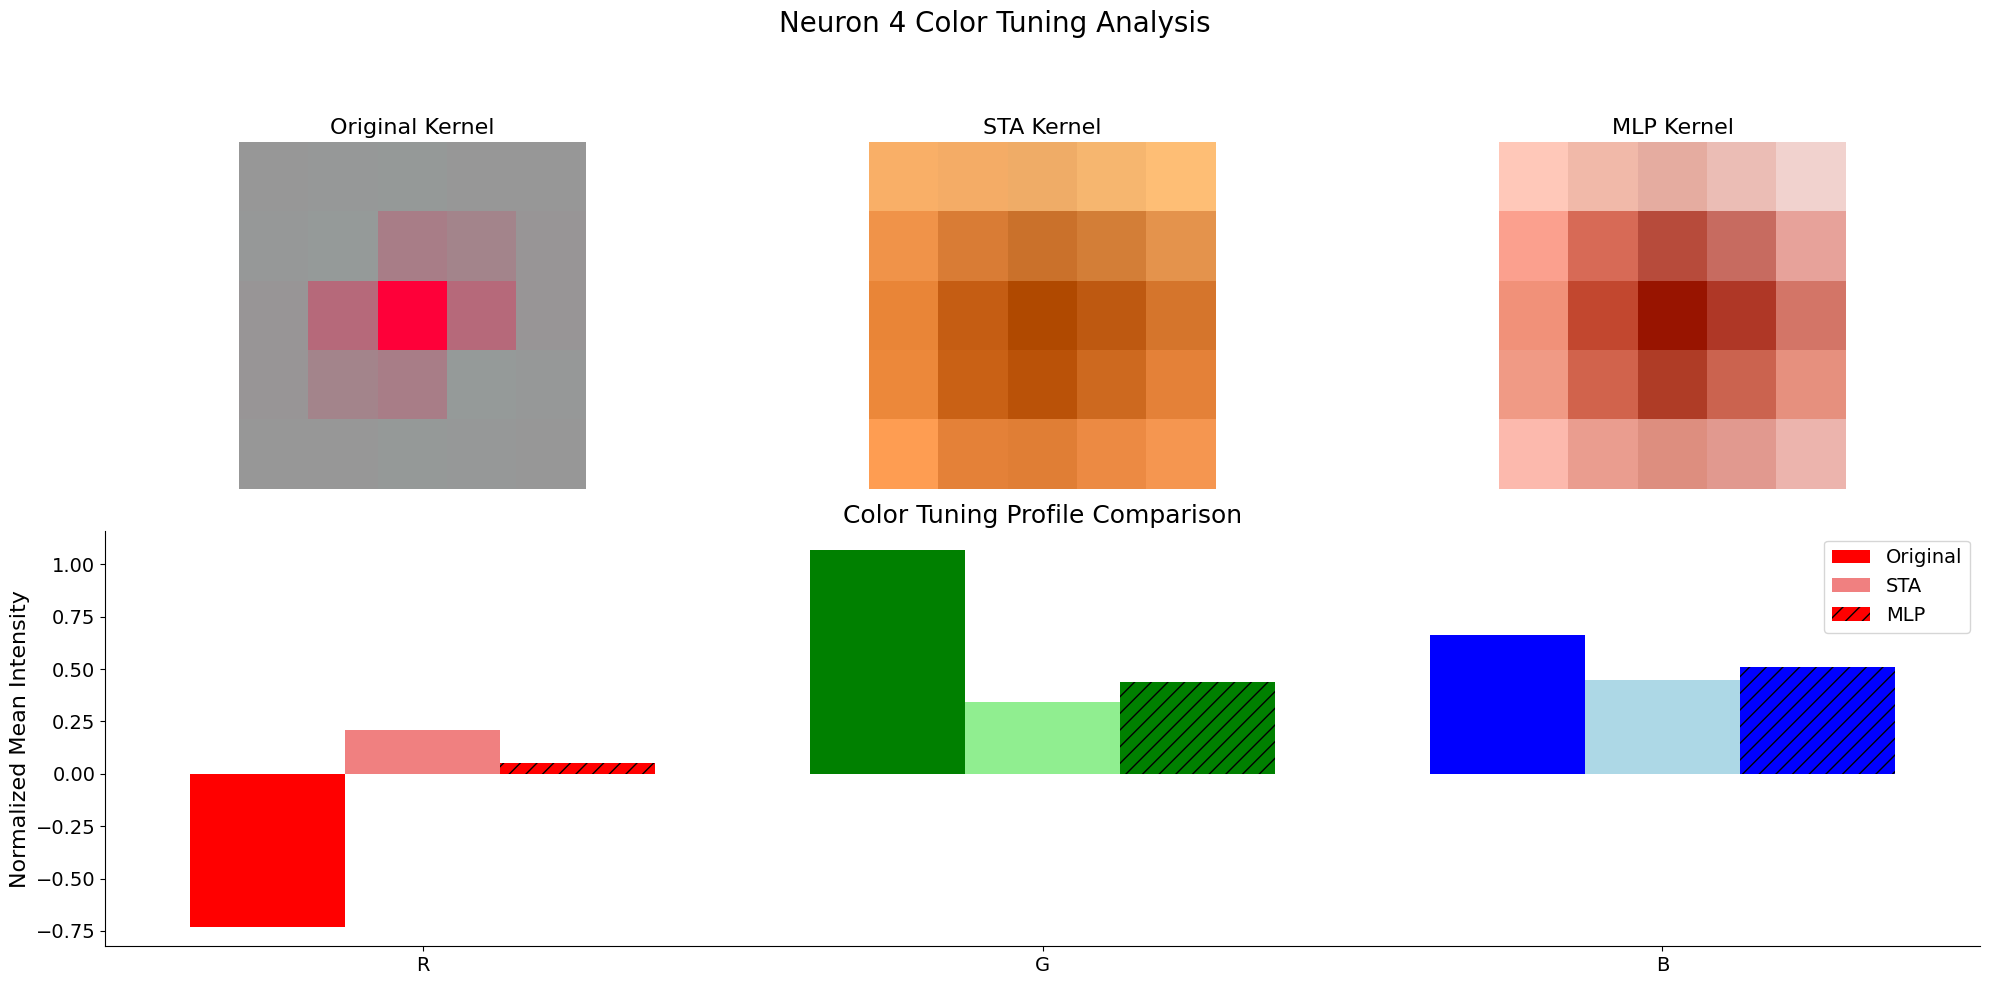

Neuron 4 Color Profiles:
  Original: [-0.73335117  1.07025095  0.66310027]
  STA:      [0.21076801 0.34220937 0.44702262]
  MLP:      [0.05265824 0.43838555 0.5089562 ]


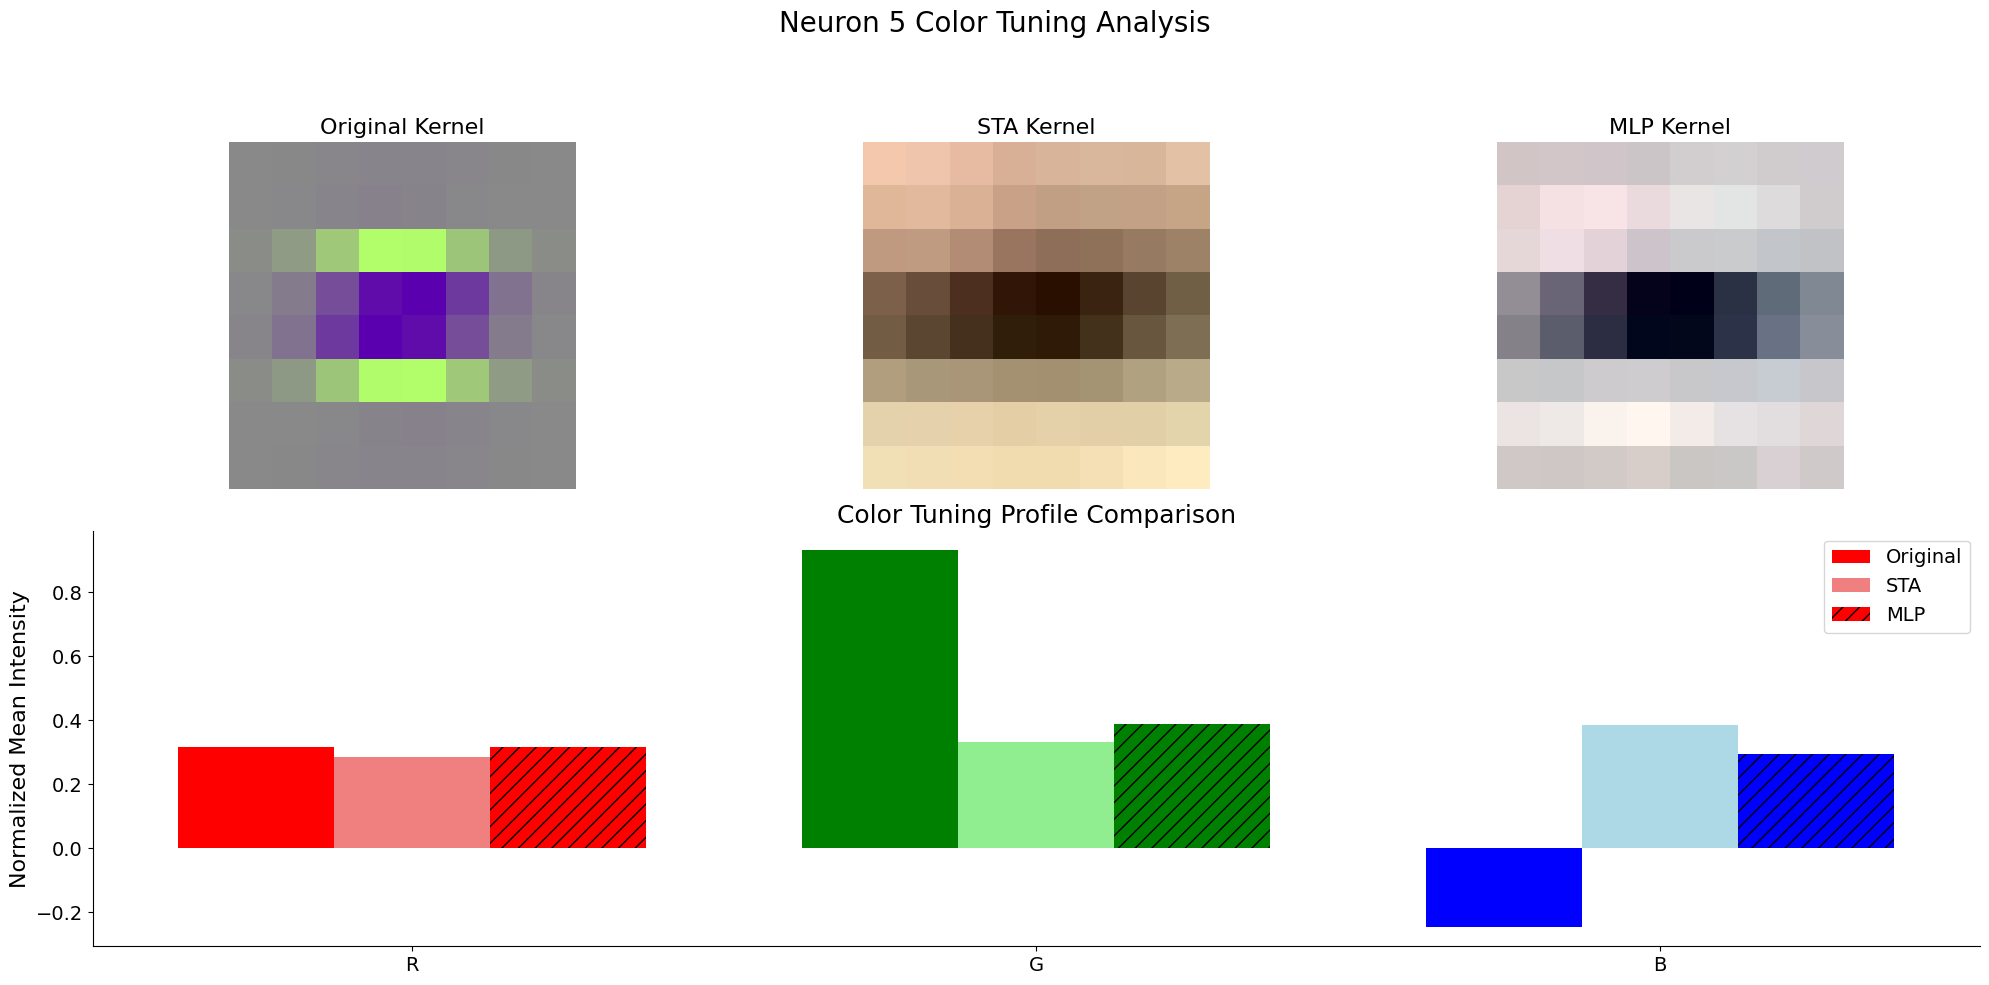

Neuron 5 Color Profiles:
  Original: [ 0.31544855  0.93260284 -0.24805112]
  STA:      [0.28419429 0.33149555 0.38431016]
  MLP:      [0.31696638 0.38764286 0.29539075]


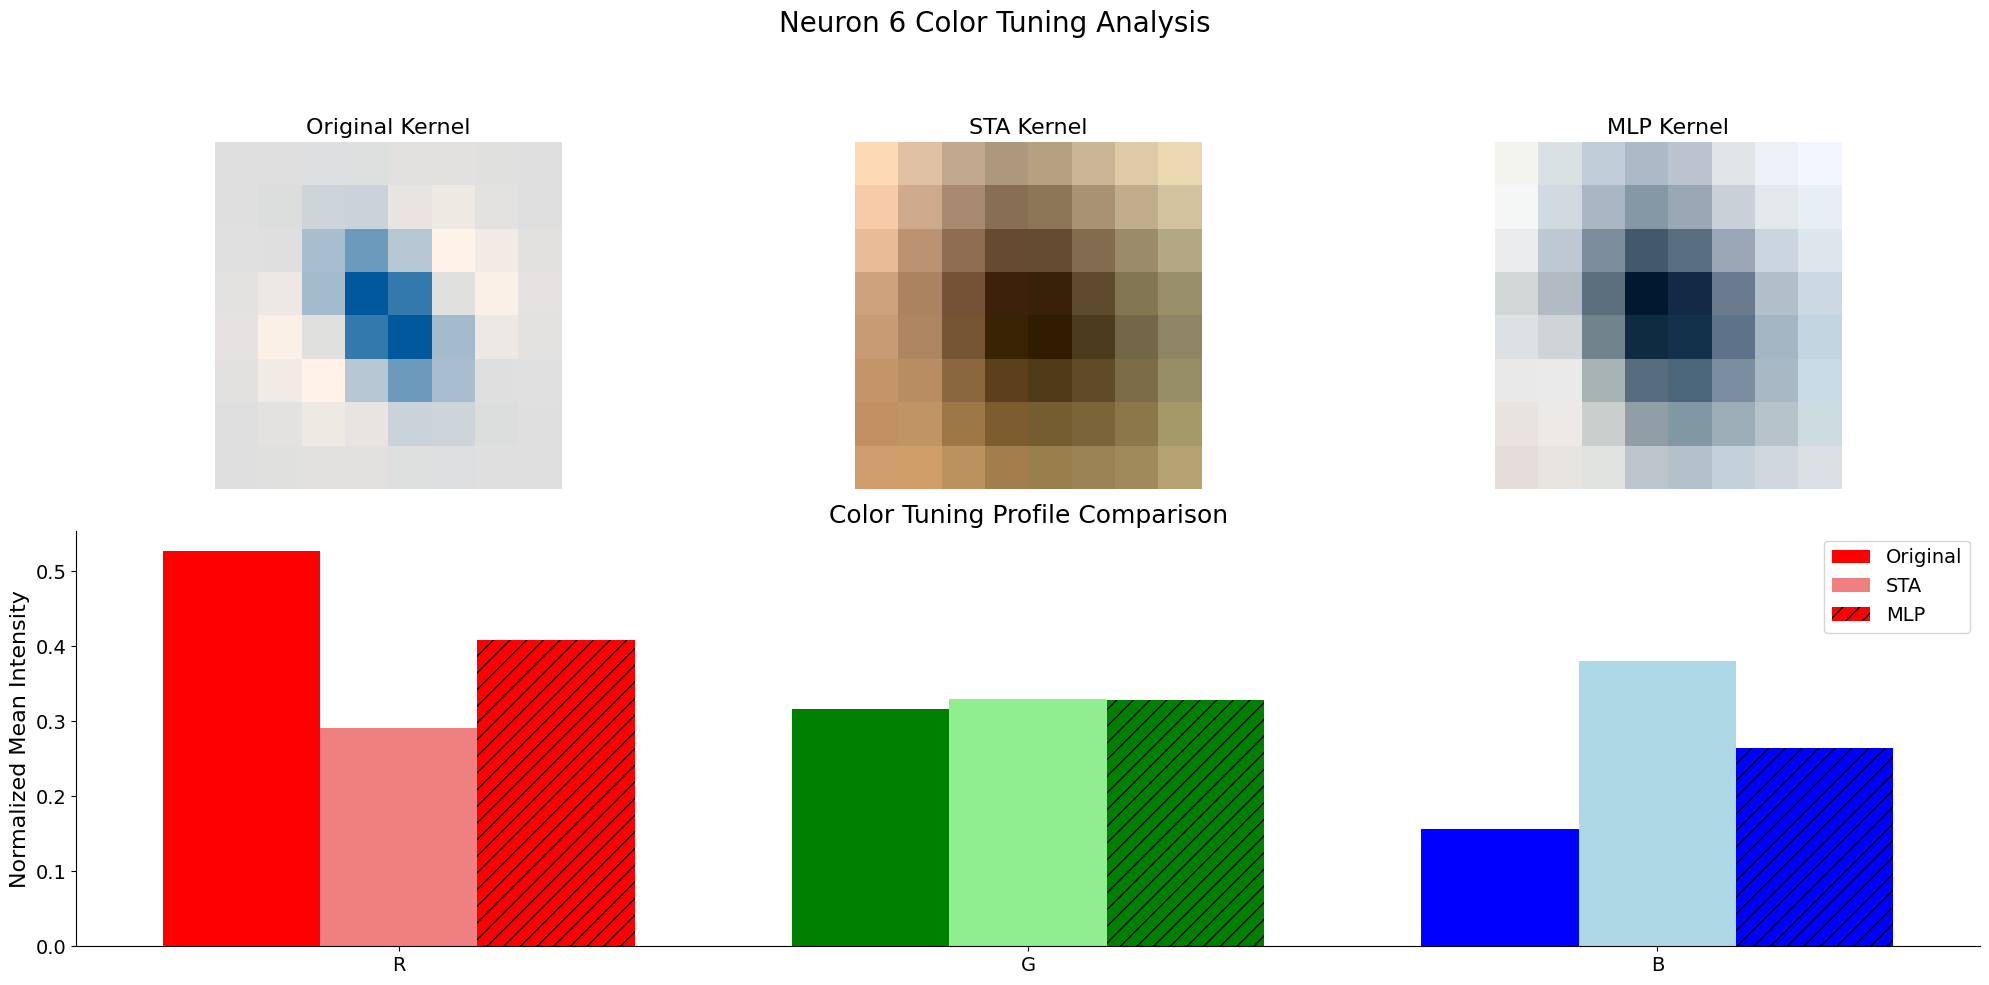

Neuron 6 Color Profiles:
  Original: [0.52739784 0.31564289 0.1569593 ]
  STA:      [0.29069807 0.32932715 0.37997478]
  MLP:      [0.40833813 0.32765022 0.26401165]


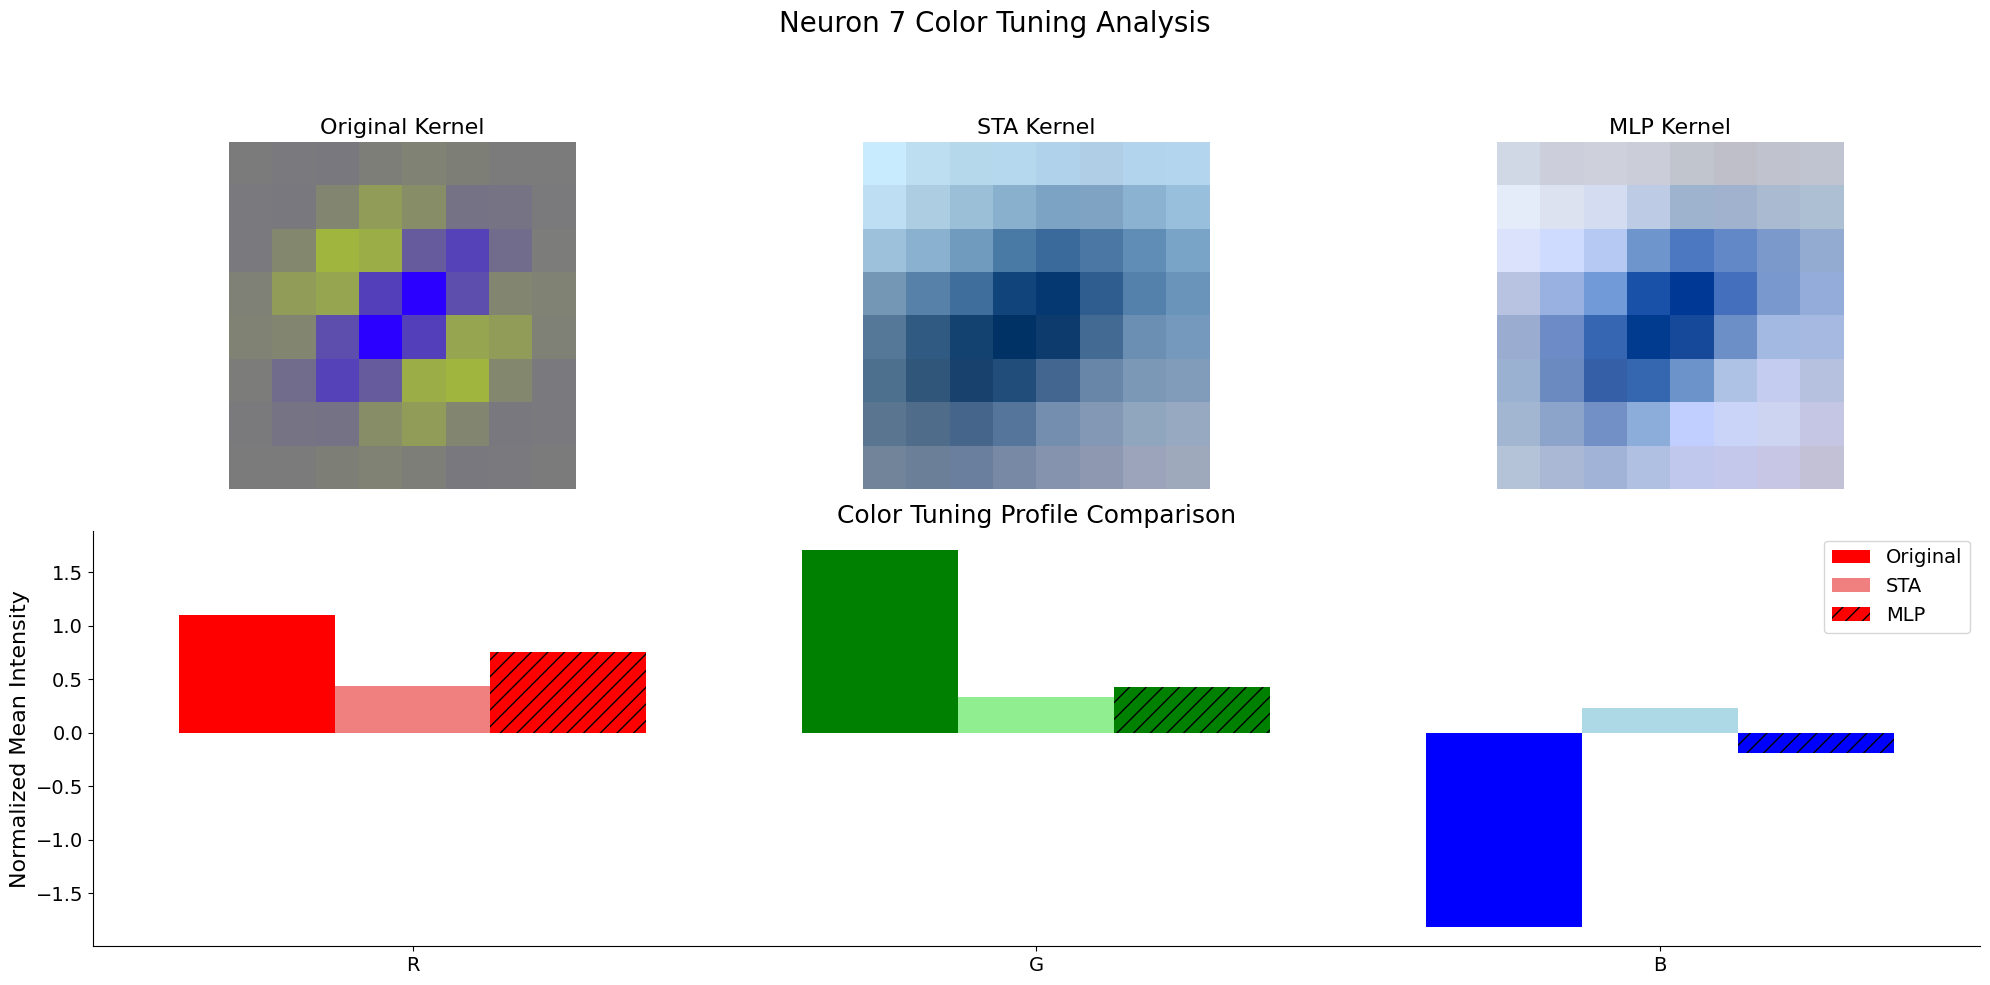

Neuron 7 Color Profiles:
  Original: [ 1.10556573  1.71229135 -1.81785683]
  STA:      [0.43802633 0.33195028 0.23002339]
  MLP:      [ 0.7589979   0.42945763 -0.18845557]


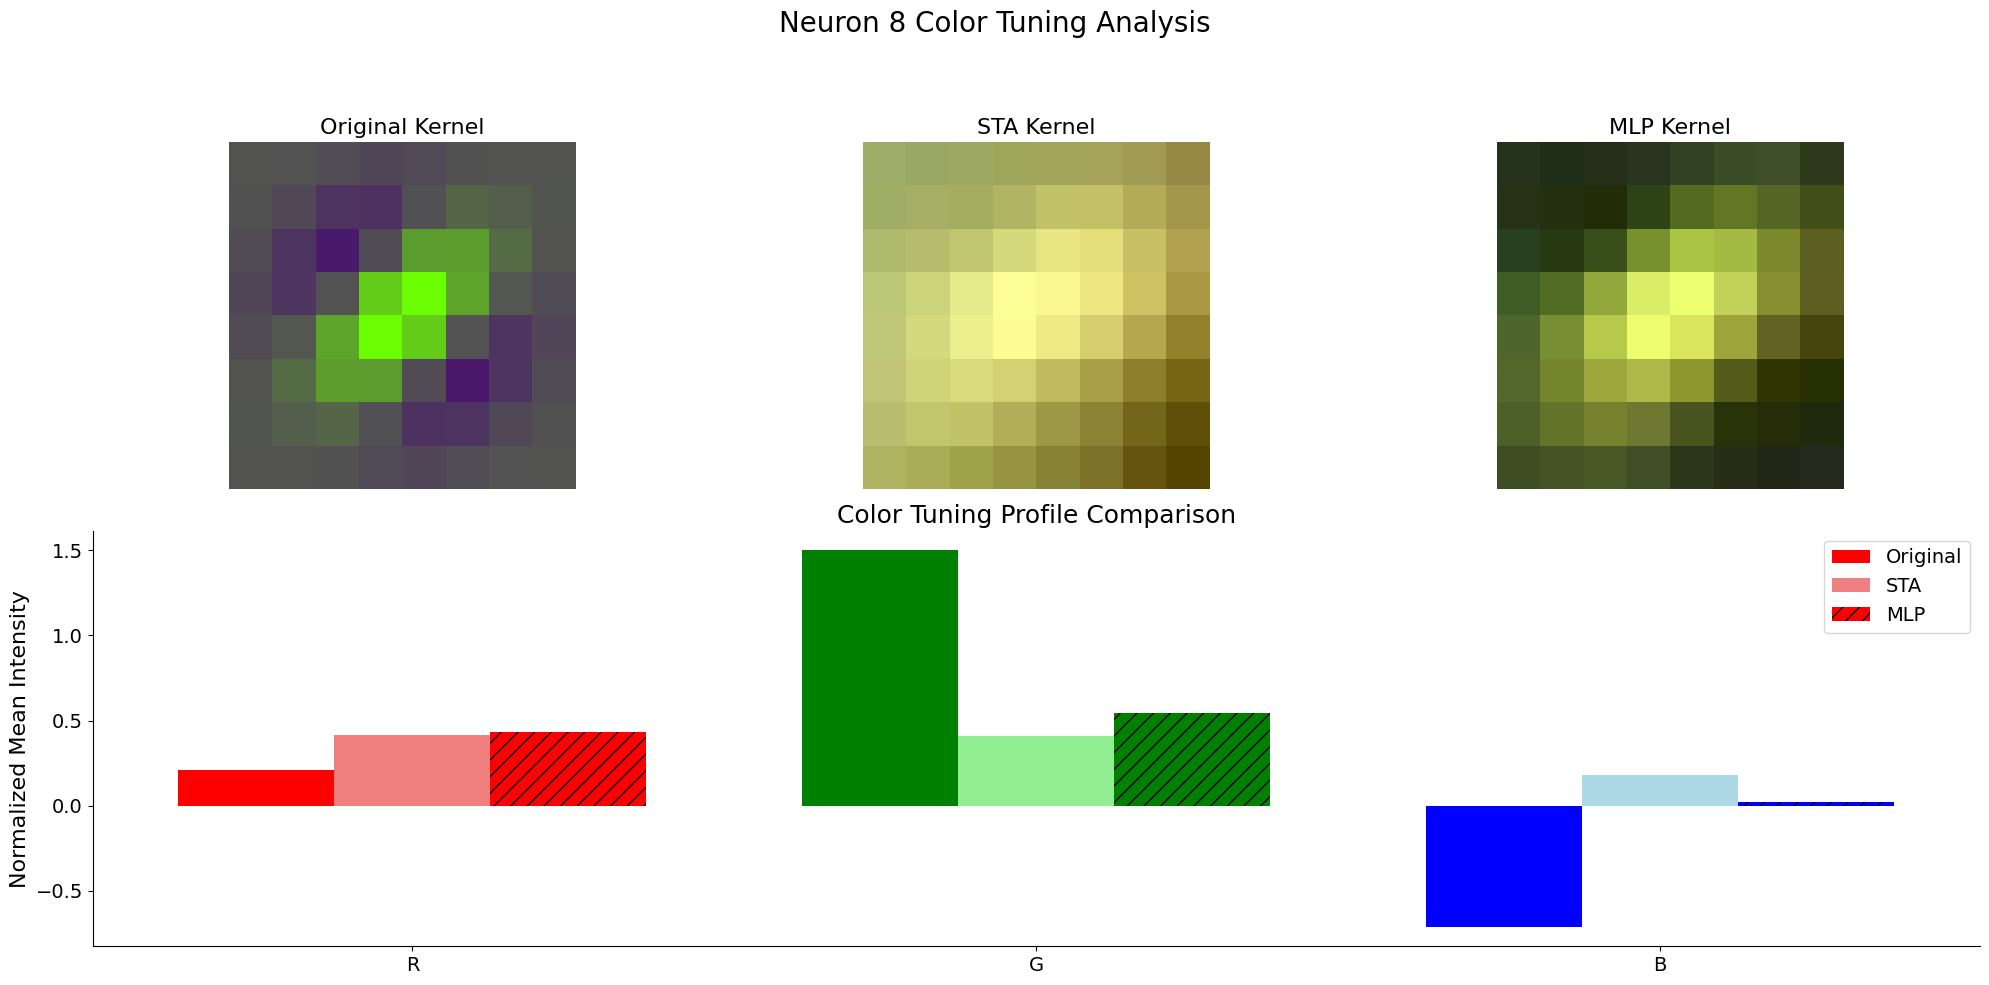

Neuron 8 Color Profiles:
  Original: [ 0.21143467  1.50287636 -0.71431107]
  STA:      [0.41253521 0.4073477  0.18011709]
  MLP:      [0.43156567 0.54666233 0.02177193]


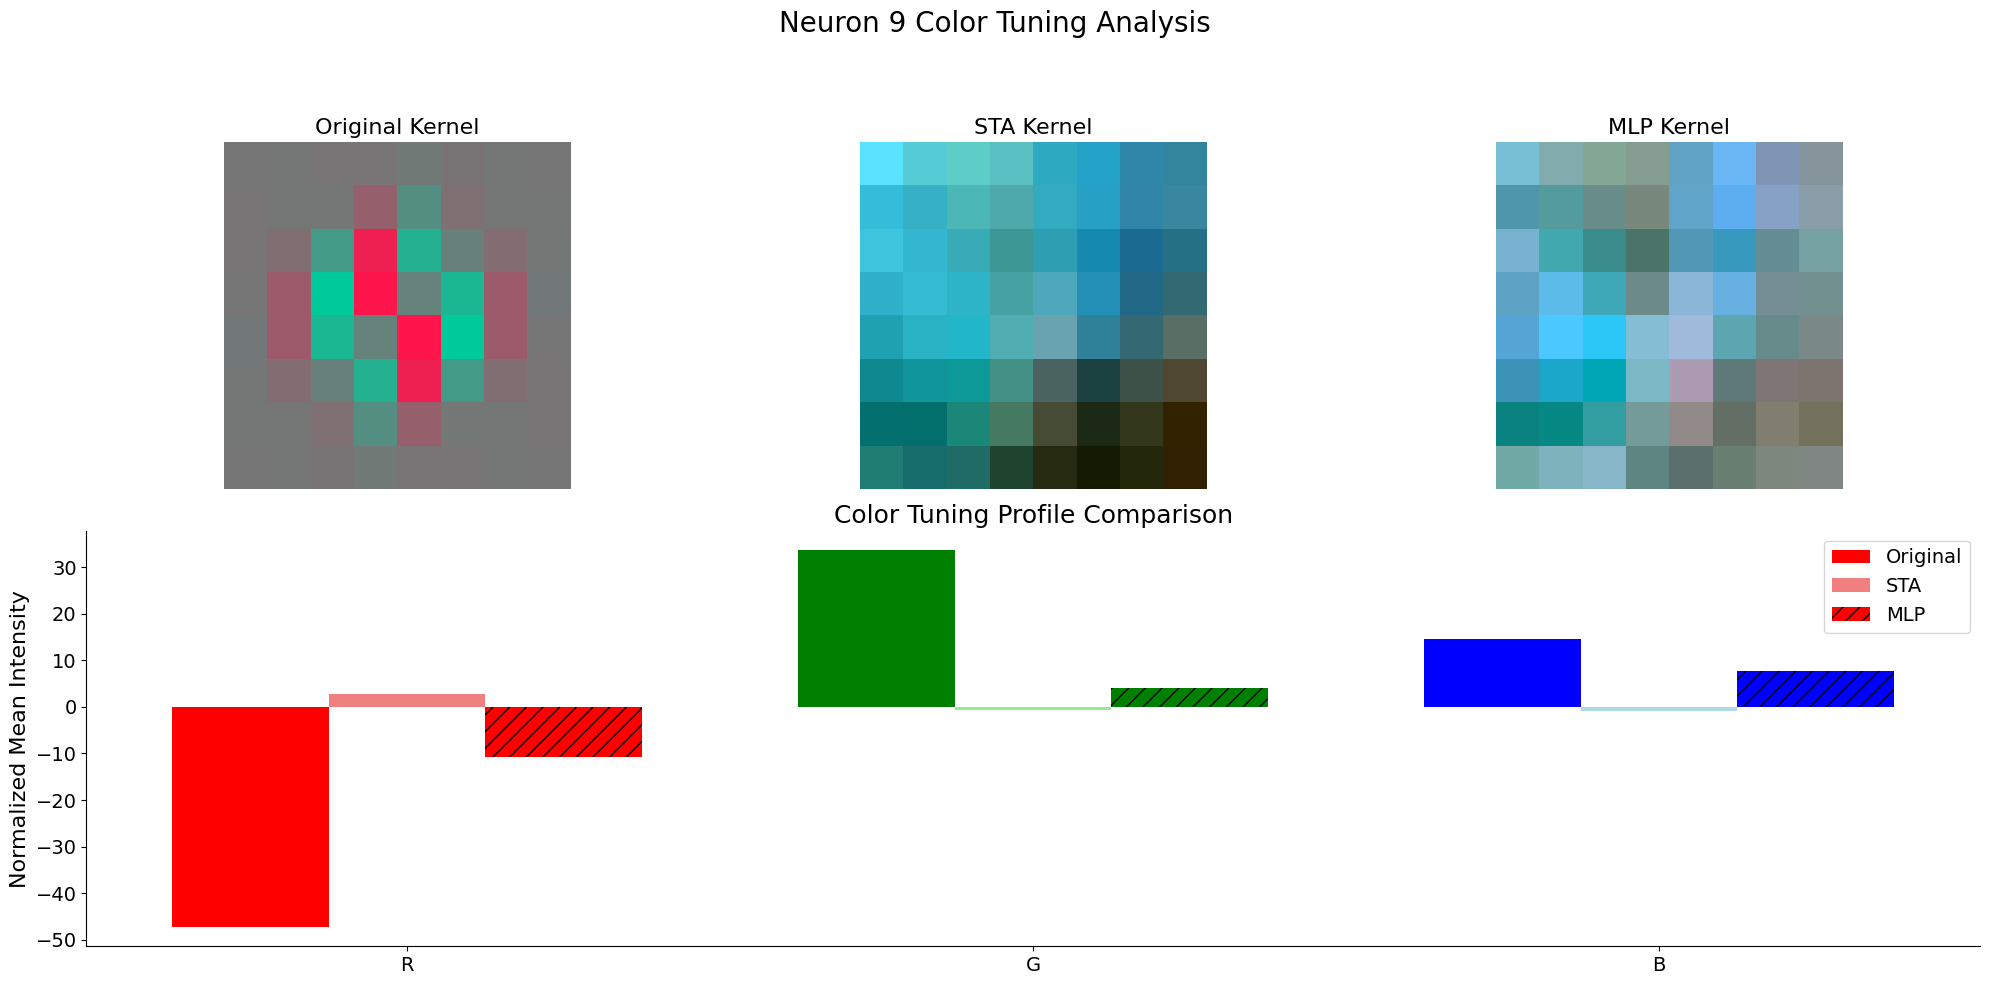

Neuron 9 Color Profiles:
  Original: [-47.355001    33.76760902  14.58729367]
  STA:      [ 2.68052037 -0.70314958 -0.97737079]
  MLP:      [-10.715087    4.034611    7.6804748]


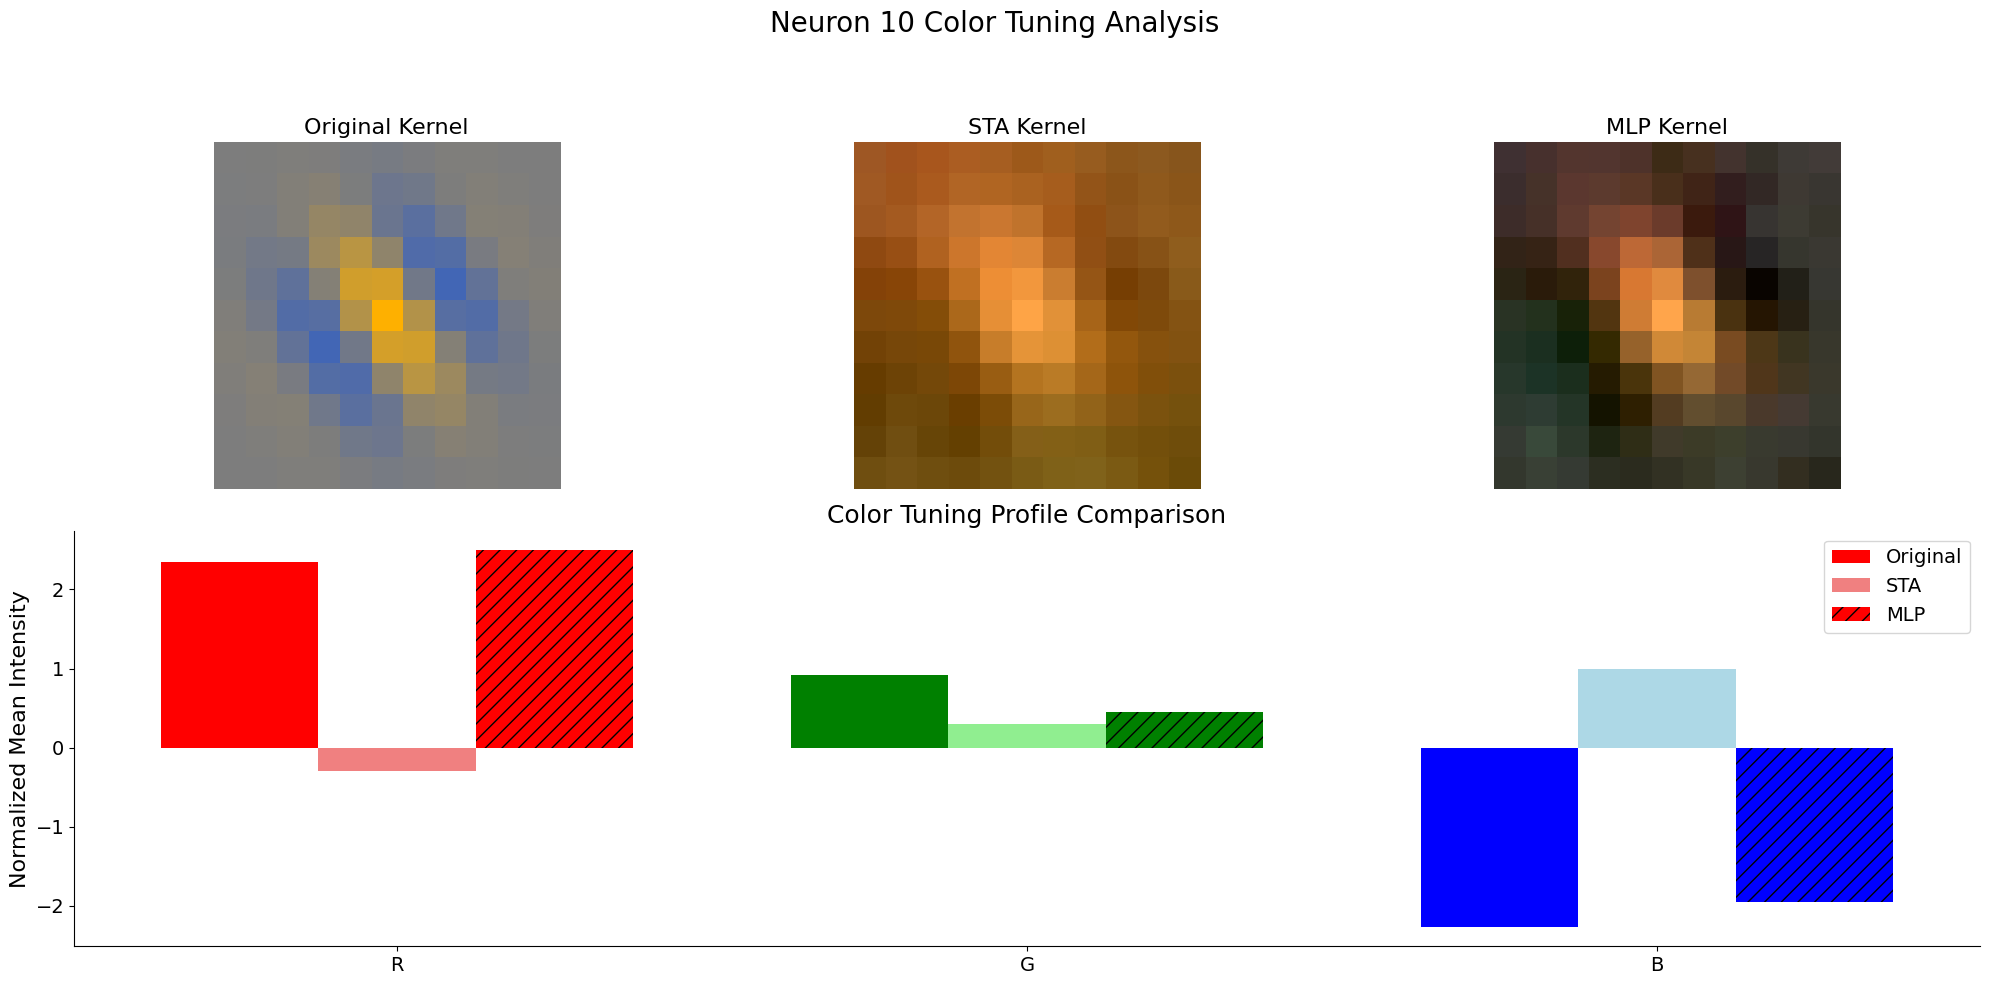

Neuron 10 Color Profiles:
  Original: [ 2.34717664  0.92384543 -2.27102484]
  STA:      [-0.29160499  0.30115909  0.9904459 ]
  MLP:      [ 2.5013752   0.44554937 -1.9469246 ]


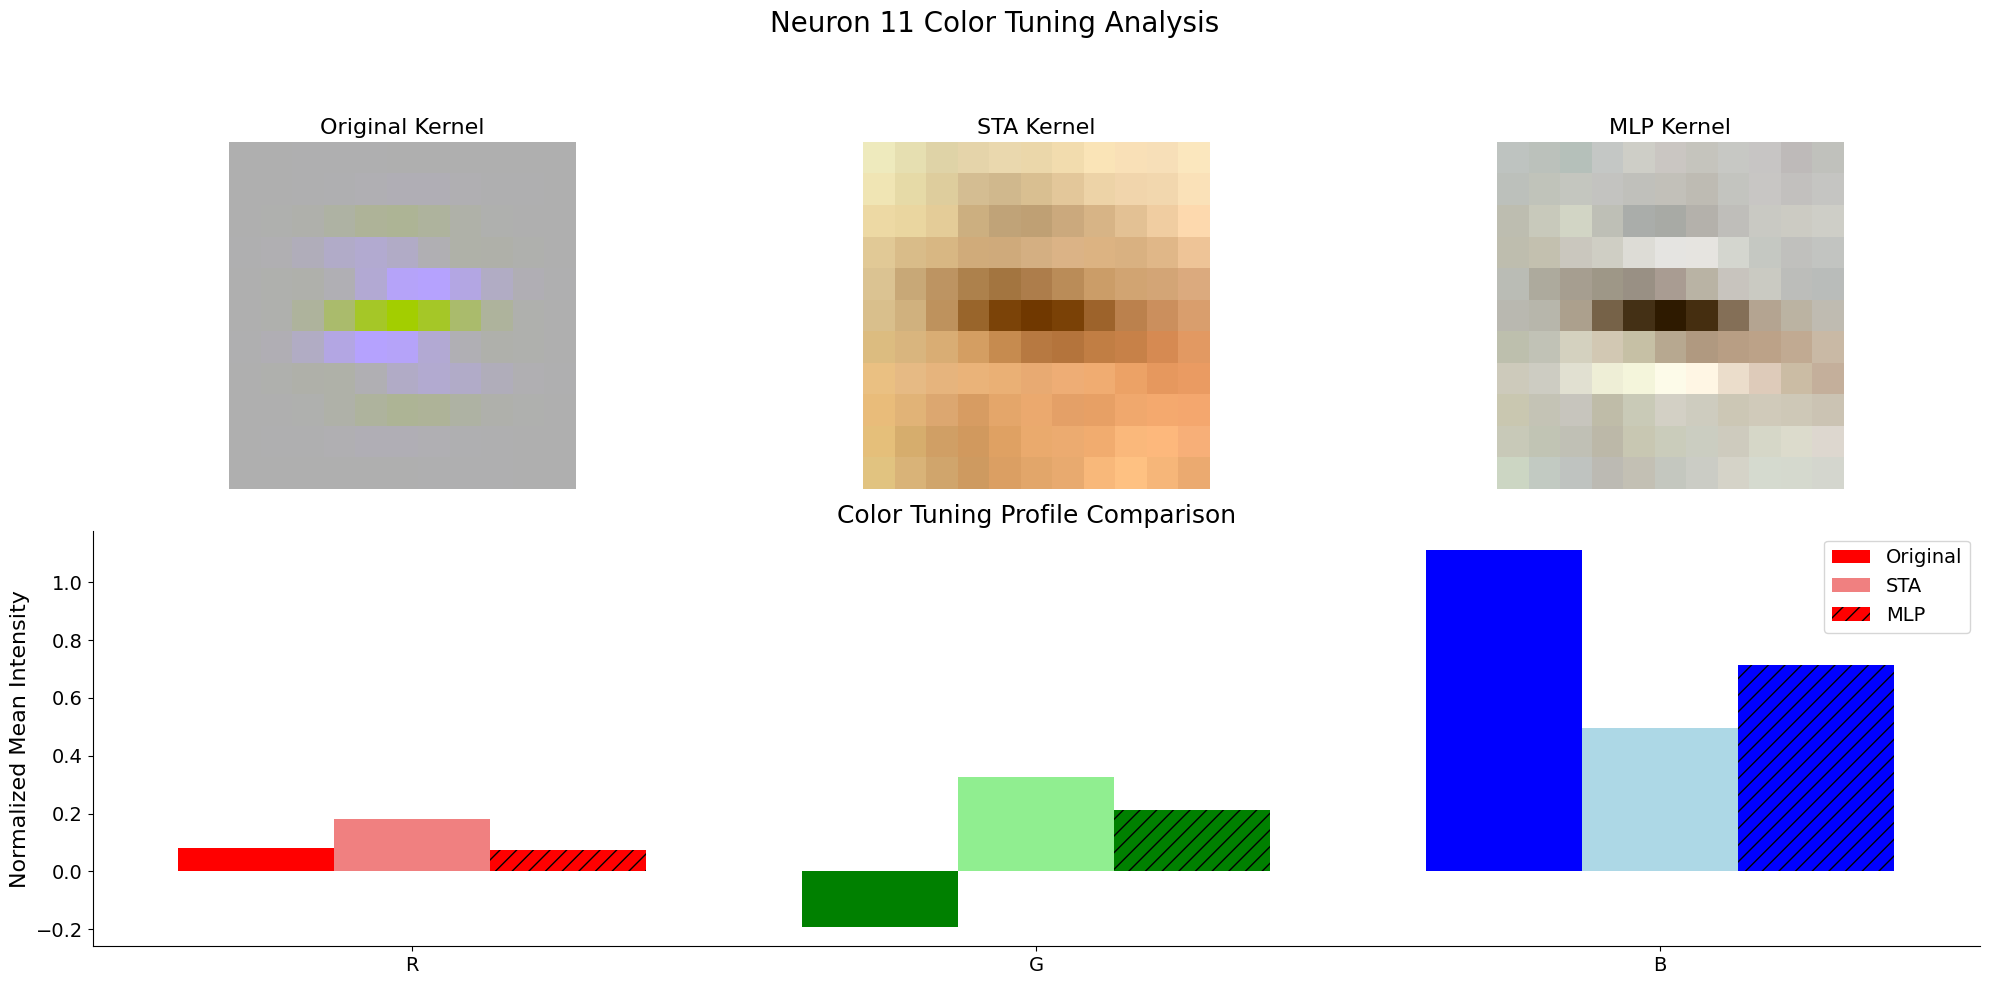

Neuron 11 Color Profiles:
  Original: [ 0.08111463 -0.19393756  1.11282358]
  STA:      [0.18058424 0.32495079 0.49446497]
  MLP:      [0.07311025 0.21259461 0.7142951 ]


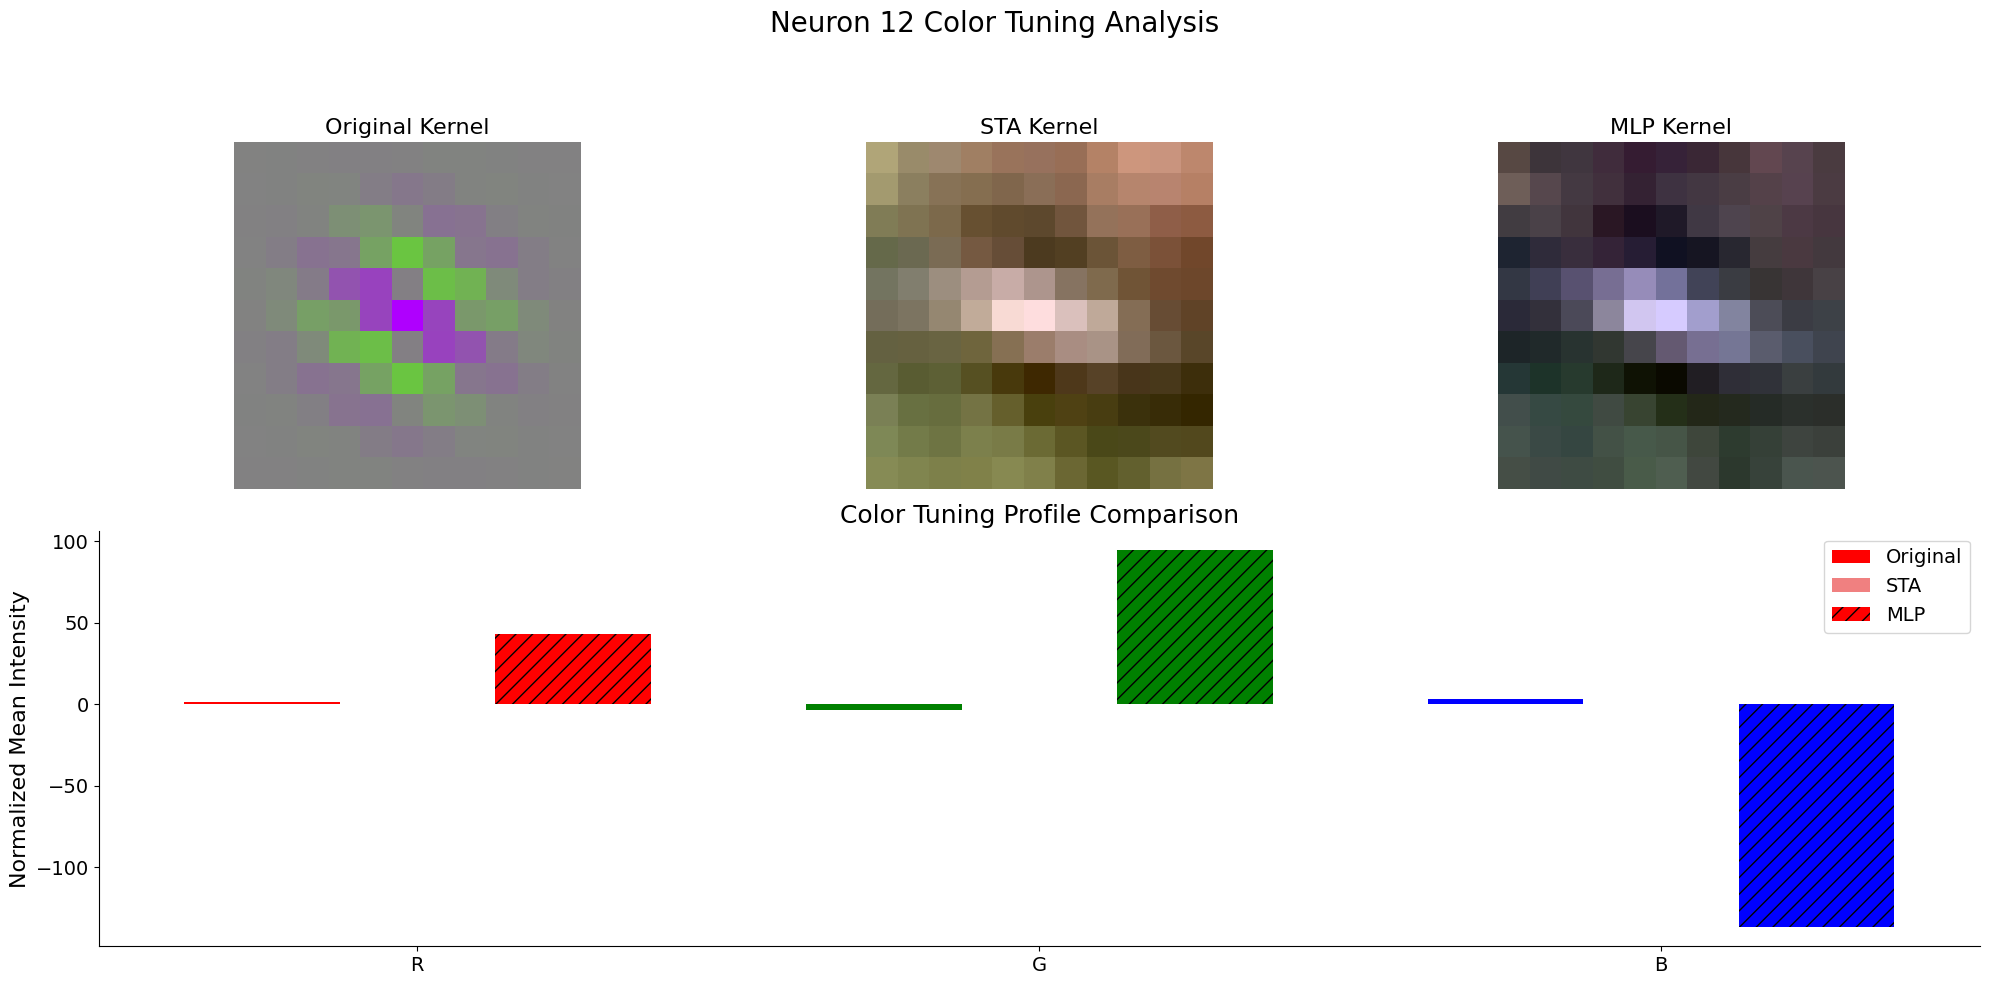

Neuron 12 Color Profiles:
  Original: [ 1.12563604 -3.21218066  3.08653543]
  STA:      [0.23195405 0.31221153 0.45583442]
  MLP:      [  43.027348   94.66868  -136.69603 ]


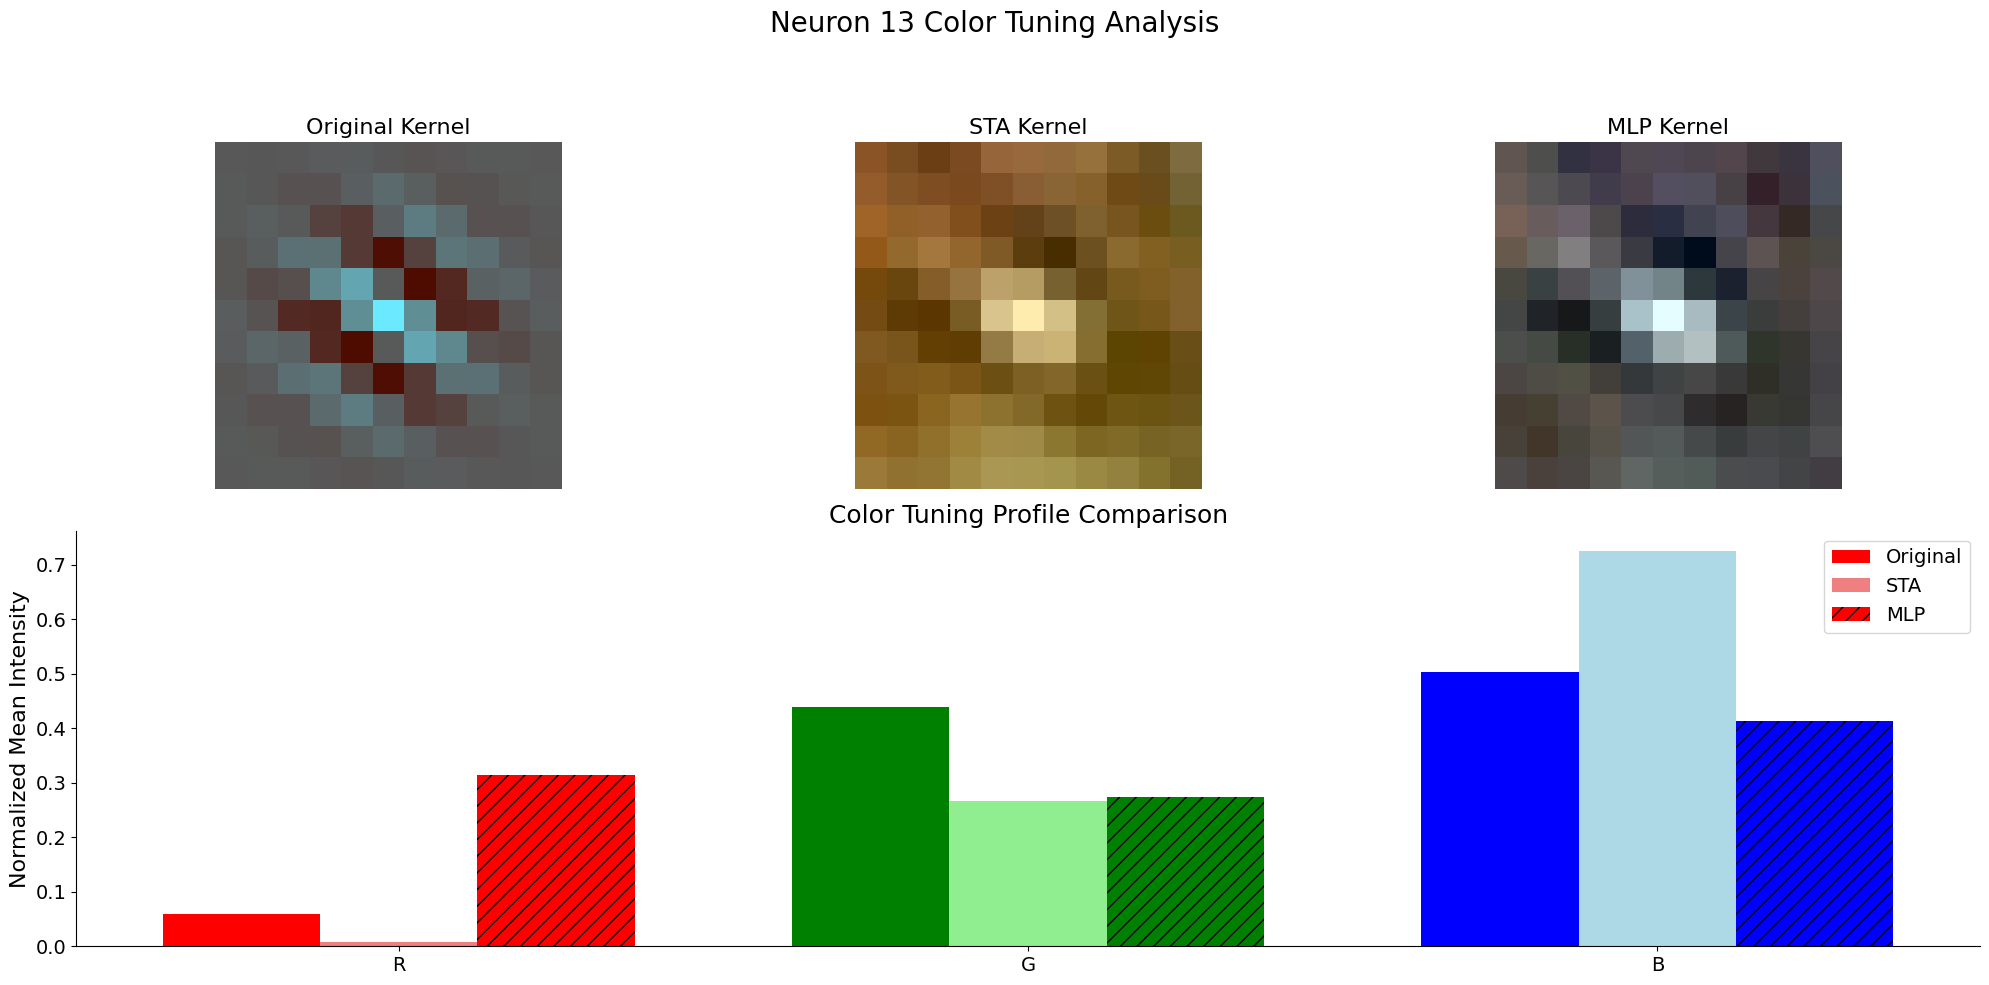

Neuron 13 Color Profiles:
  Original: [0.05836578 0.43896378 0.50266878]
  STA:      [0.00852865 0.266048   0.72542335]
  MLP:      [0.31427217 0.27330953 0.4124183 ]


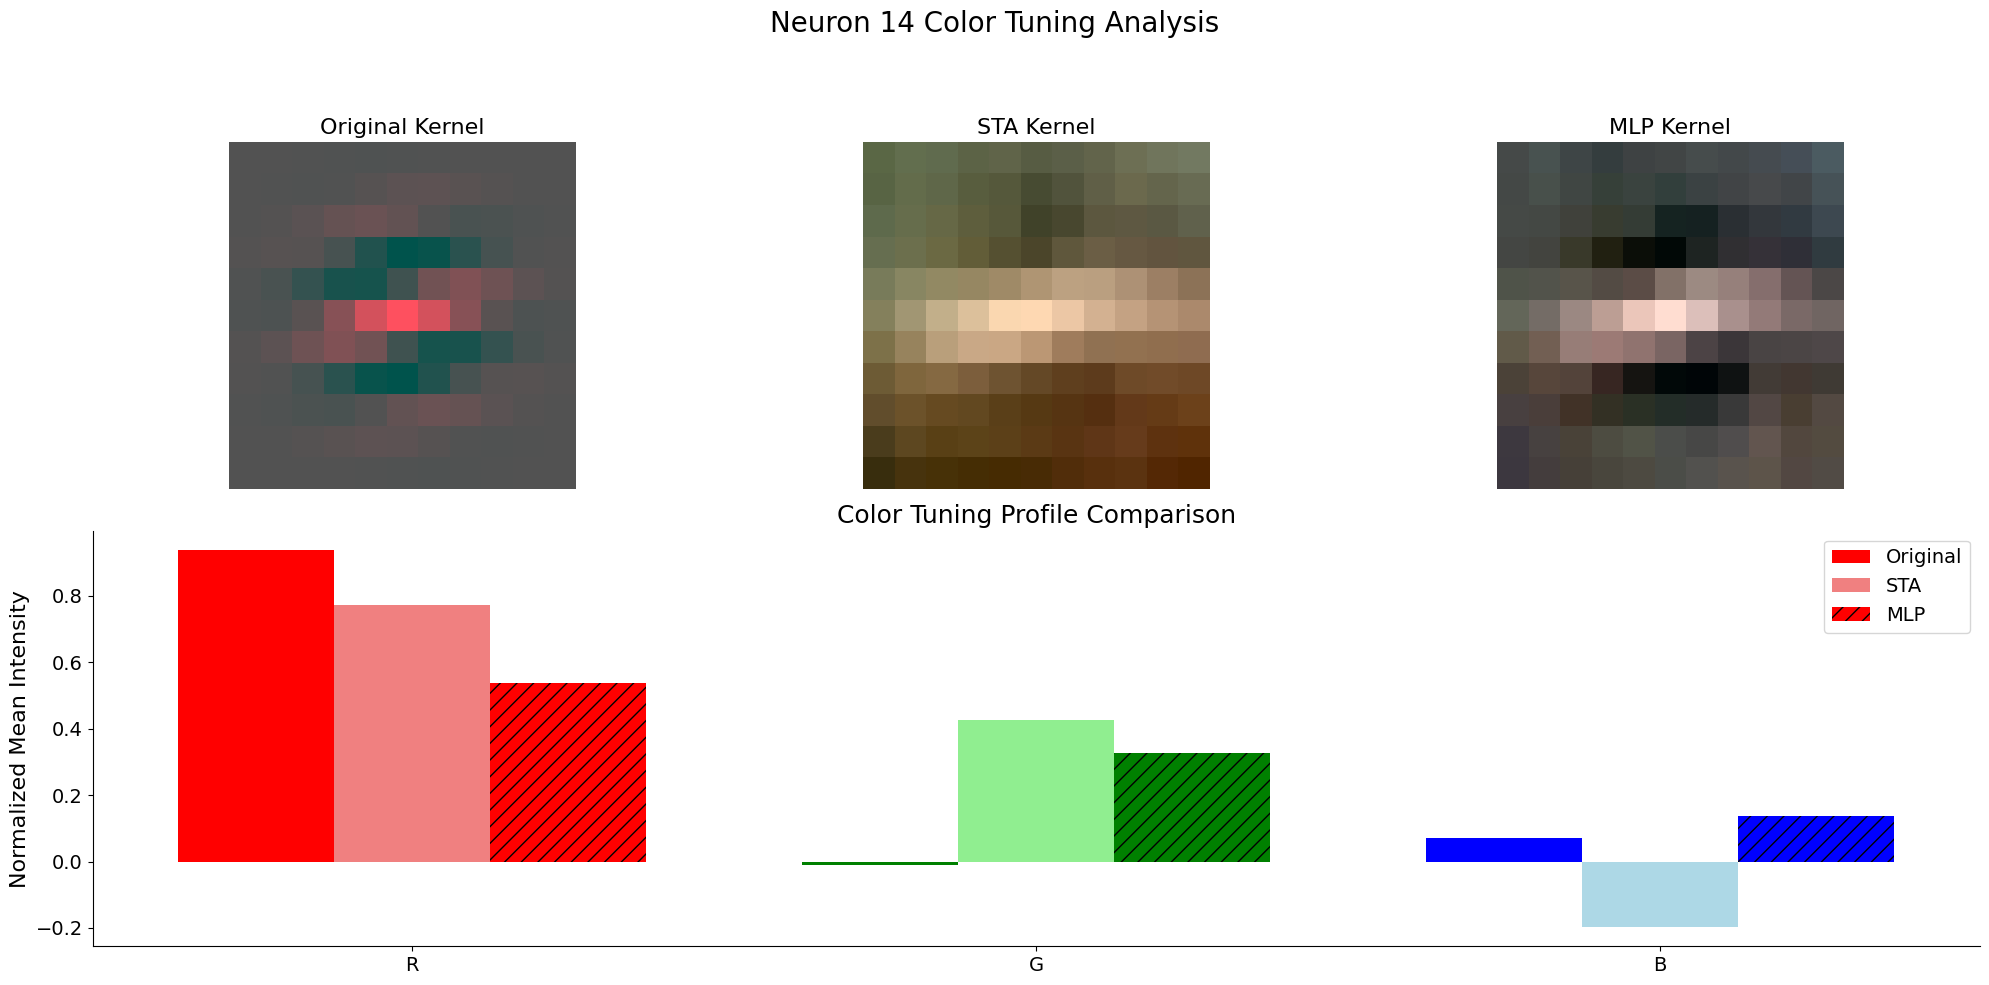

Neuron 14 Color Profiles:
  Original: [ 0.93859857 -0.00973589  0.07113564]
  STA:      [ 0.77173558  0.42661936 -0.19835494]
  MLP:      [0.53695524 0.32599968 0.13704507]


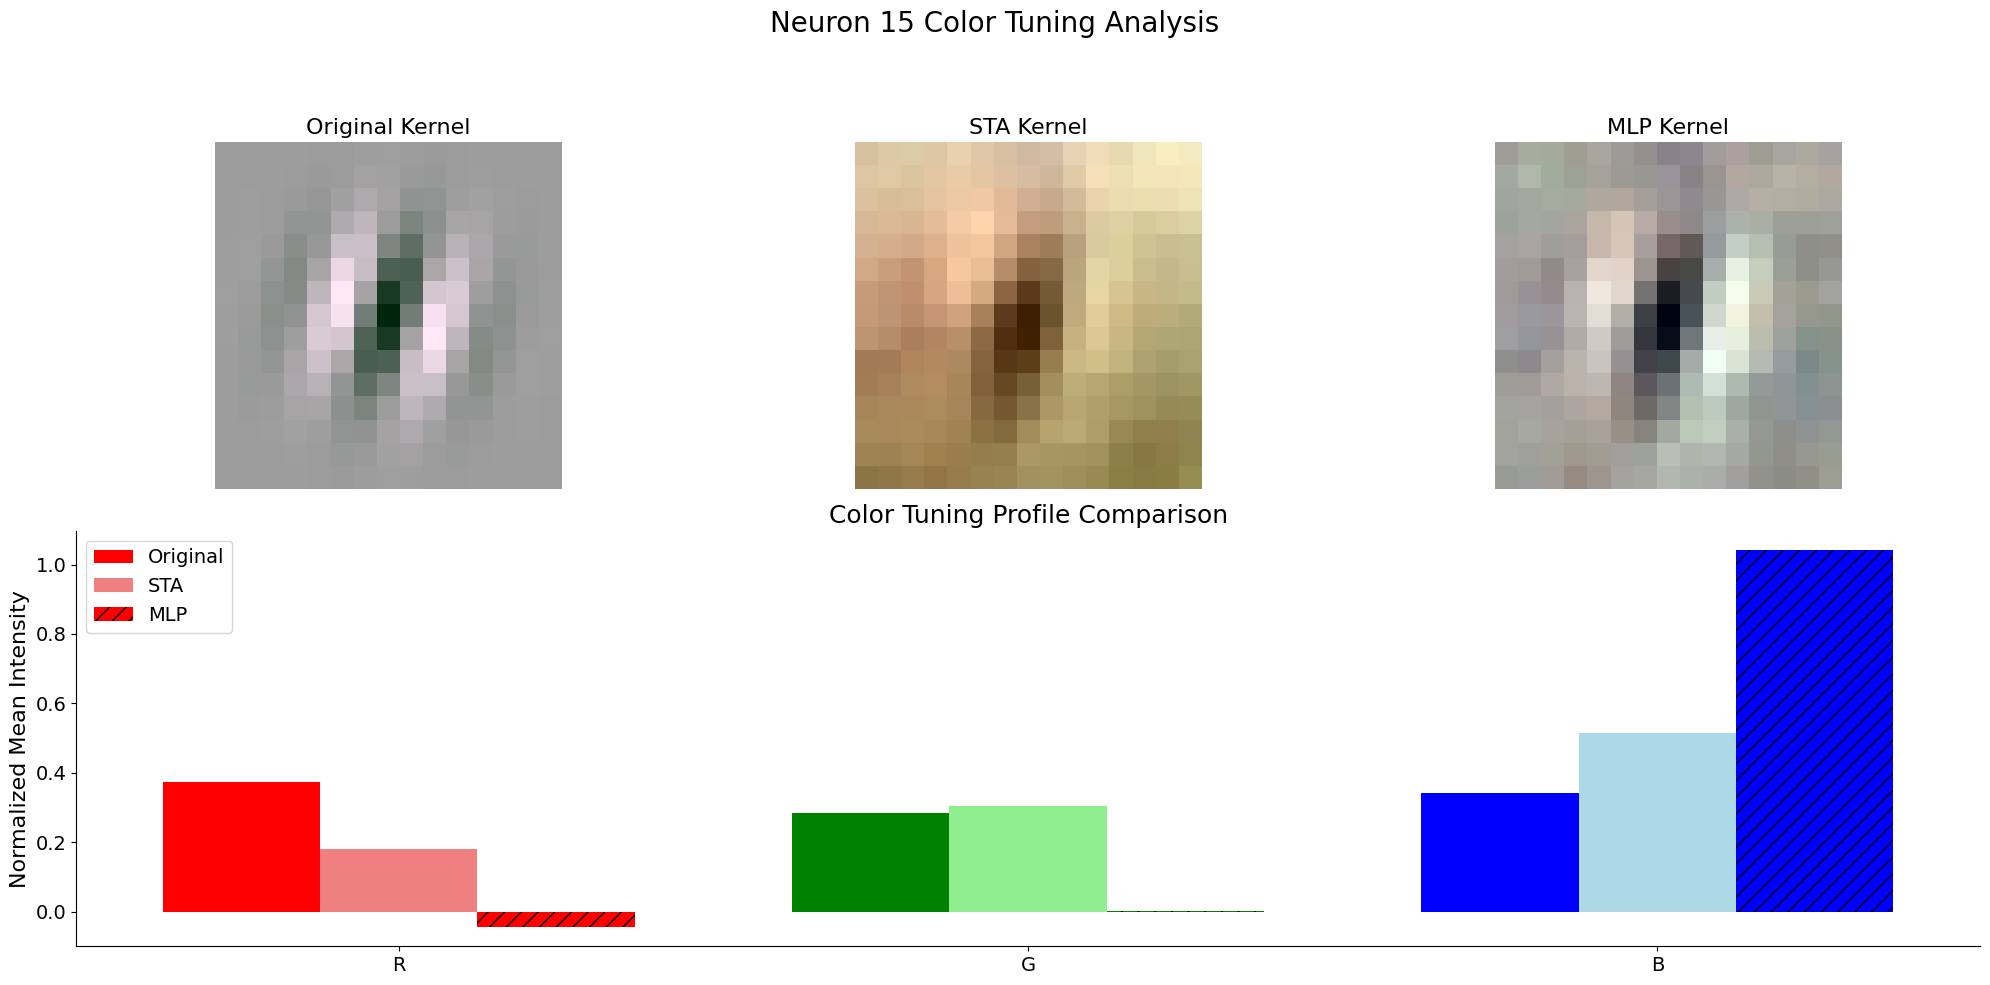

Neuron 15 Color Profiles:
  Original: [0.37373506 0.28371646 0.34255064]
  STA:      [0.179096   0.30500279 0.5159012 ]
  MLP:      [-0.04558704  0.0027848   1.0428022 ]


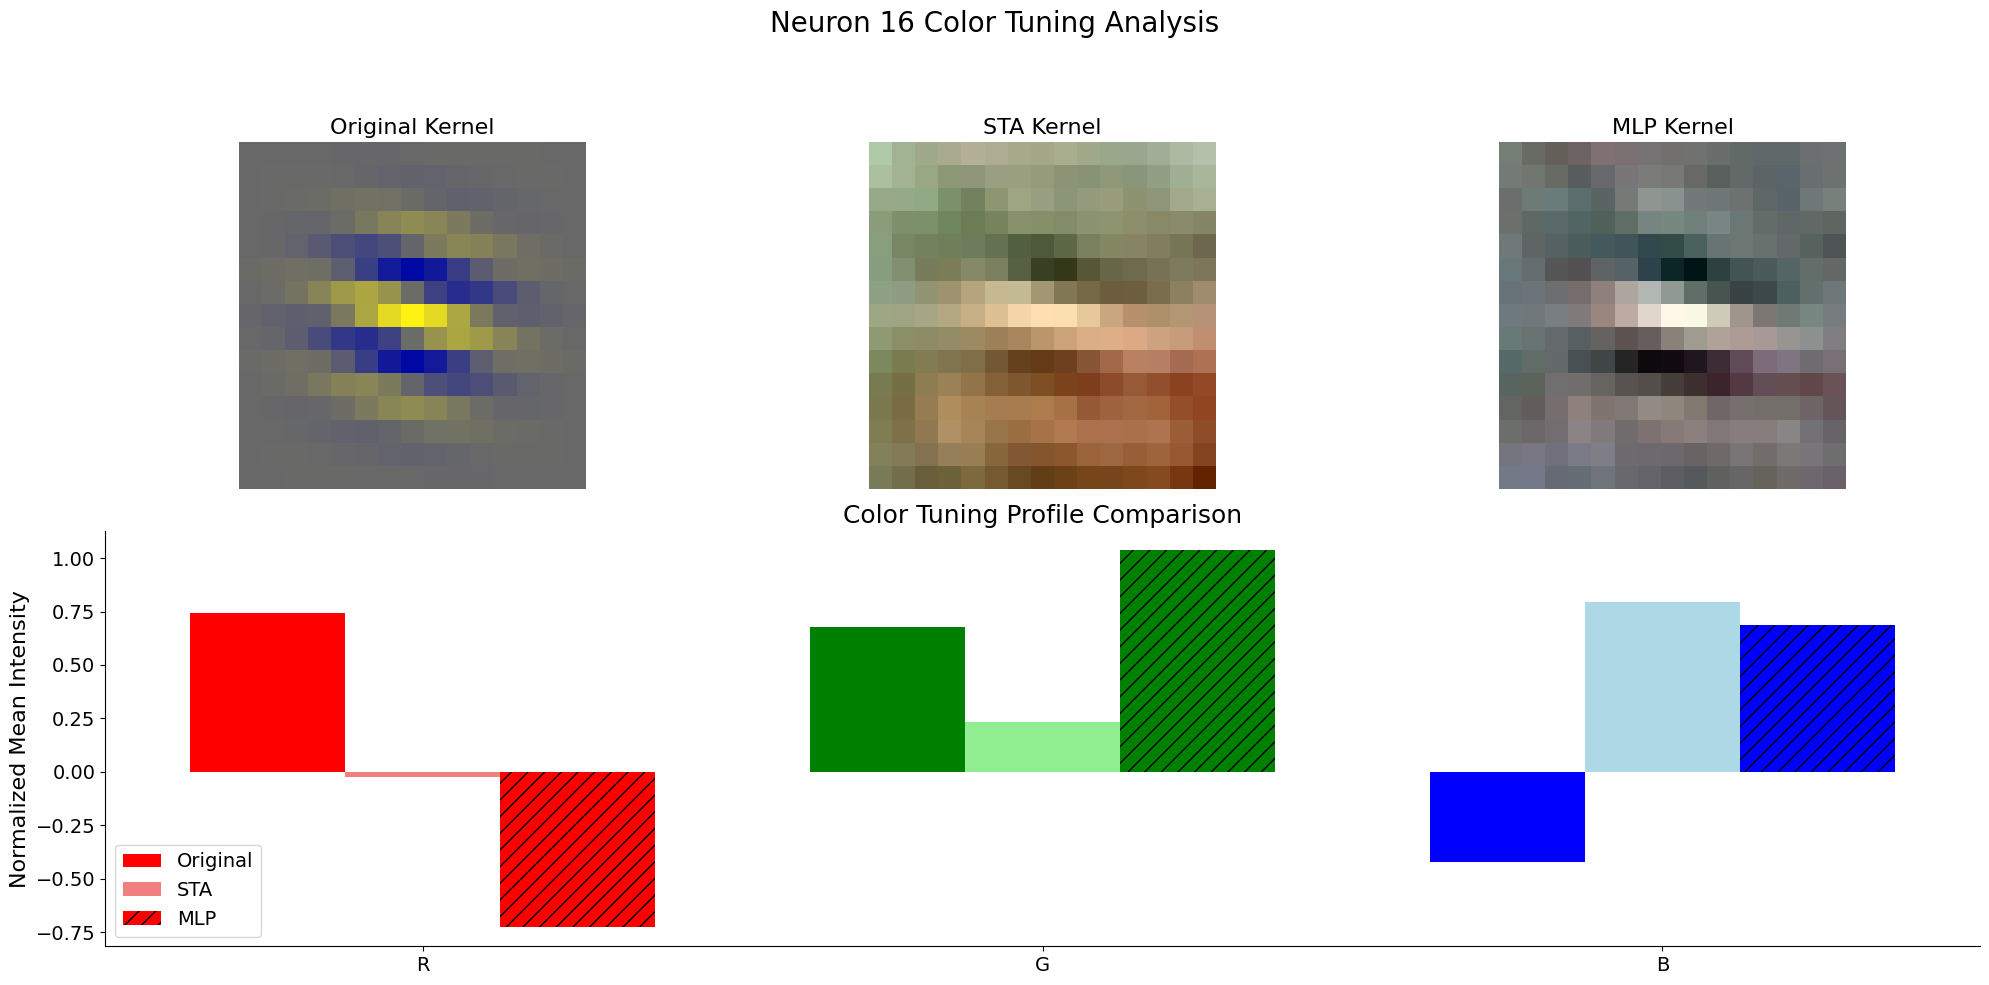

Neuron 16 Color Profiles:
  Original: [ 0.74131005  0.67933822 -0.42068741]
  STA:      [-0.02576421  0.23144336  0.79432085]
  MLP:      [-0.72734207  1.0389425   0.6883995 ]


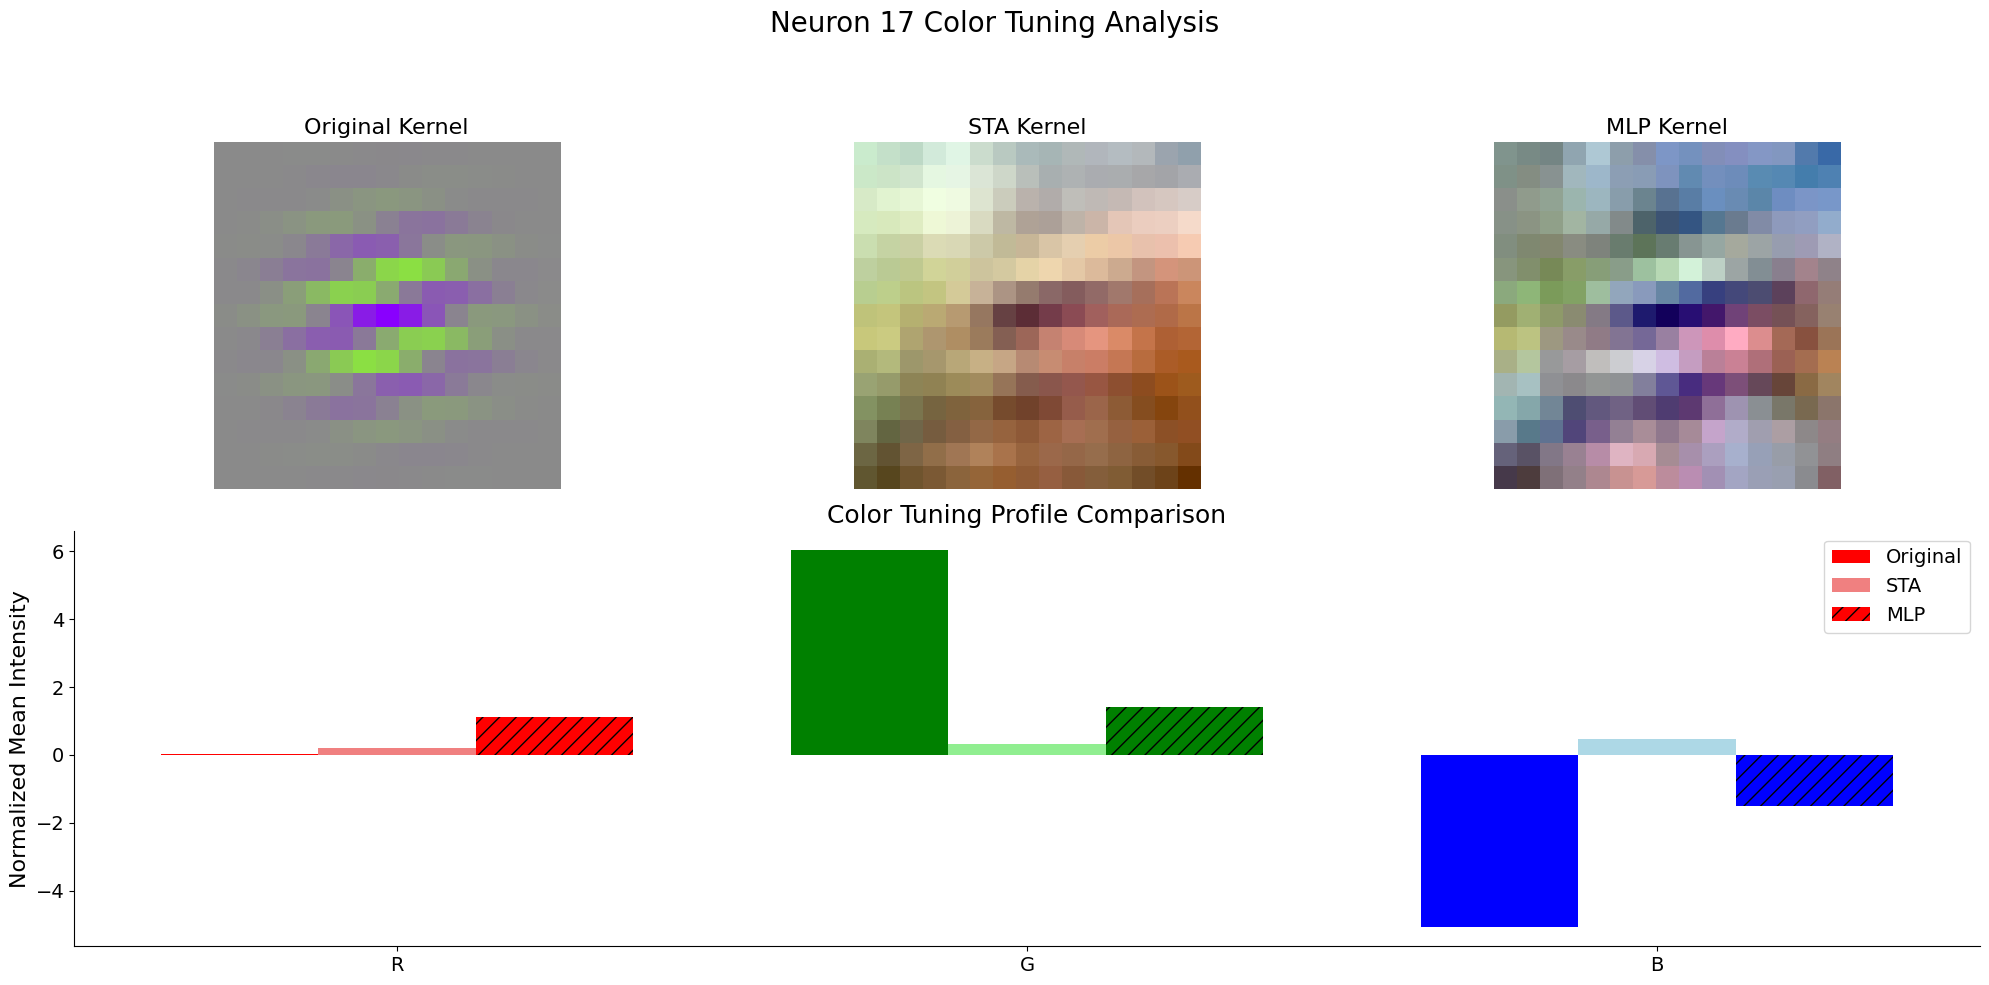

Neuron 17 Color Profiles:
  Original: [ 0.03453646  6.04286124 -5.07736552]
  STA:      [0.20051319 0.3239651  0.47552171]
  MLP:      [ 1.1145194  1.4011697 -1.515689 ]


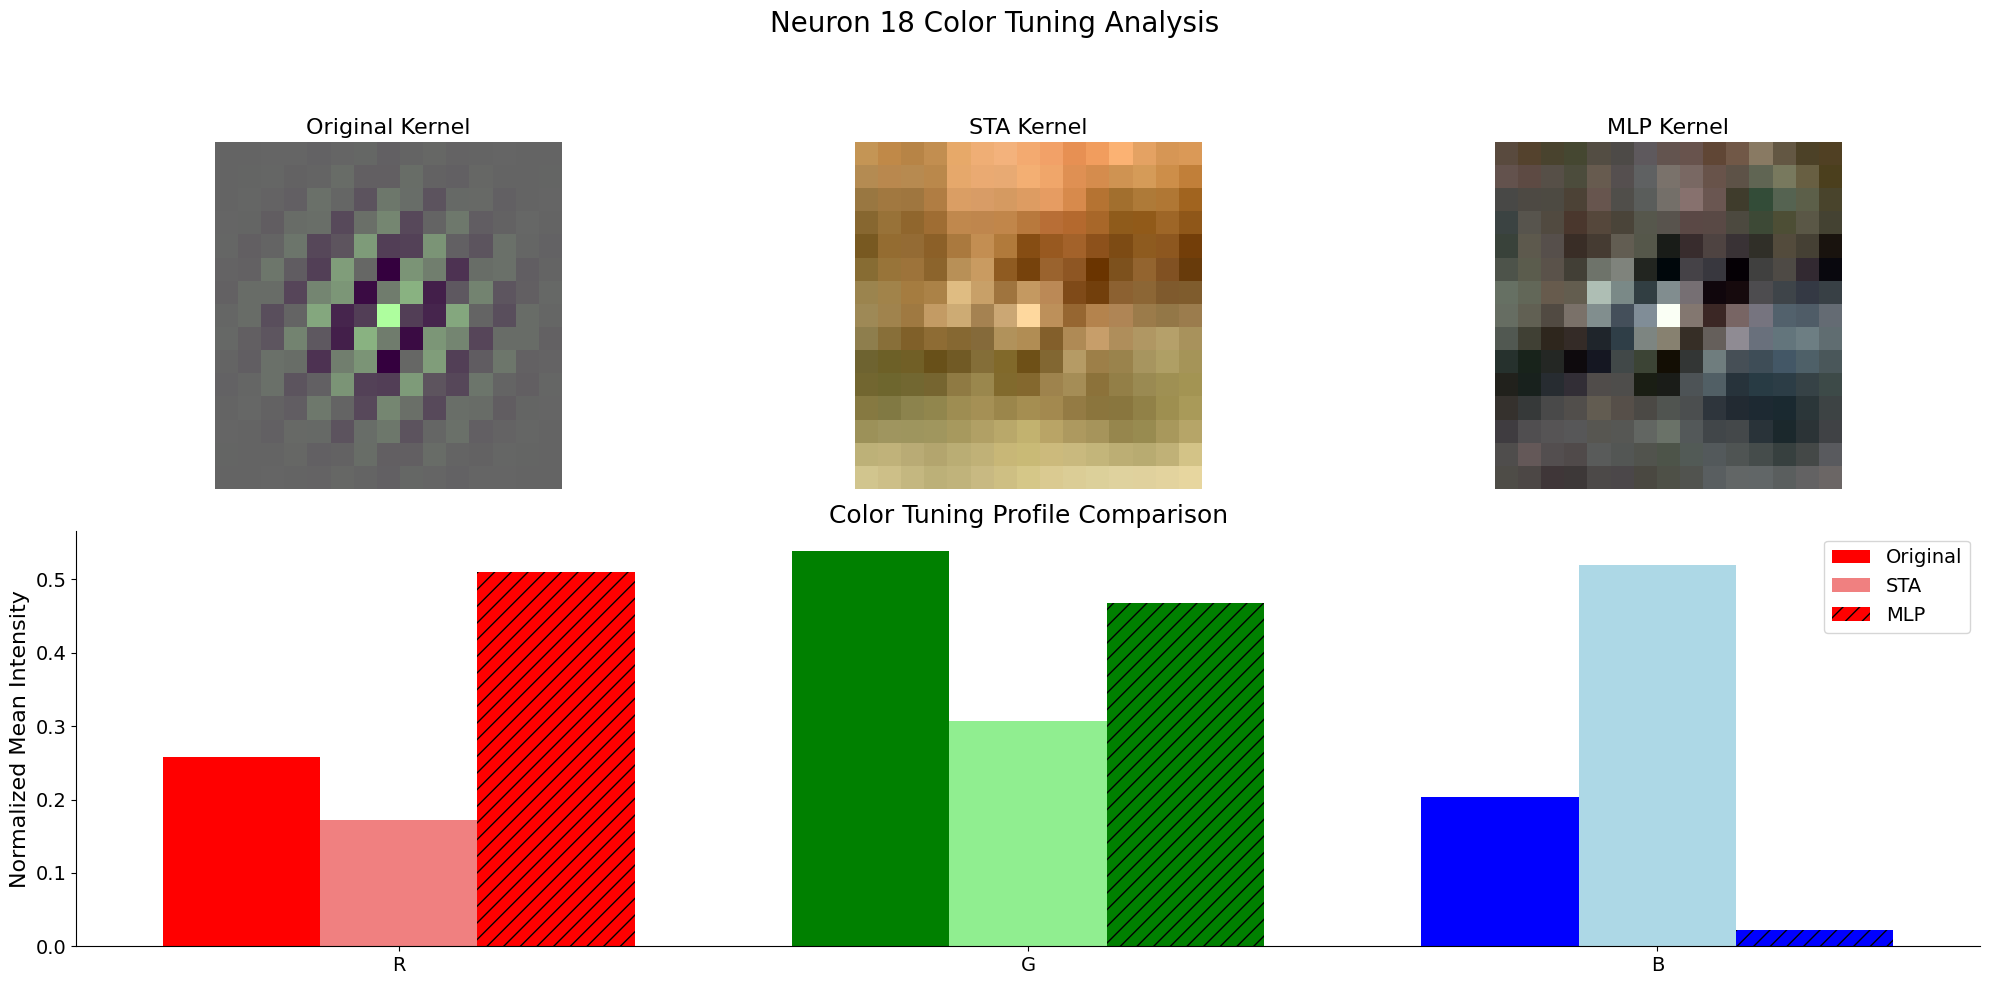

Neuron 18 Color Profiles:
  Original: [0.25774419 0.53929664 0.20290986]
  STA:      [0.17258592 0.30750808 0.519906  ]
  MLP:      [0.51027256 0.46783778 0.02188971]


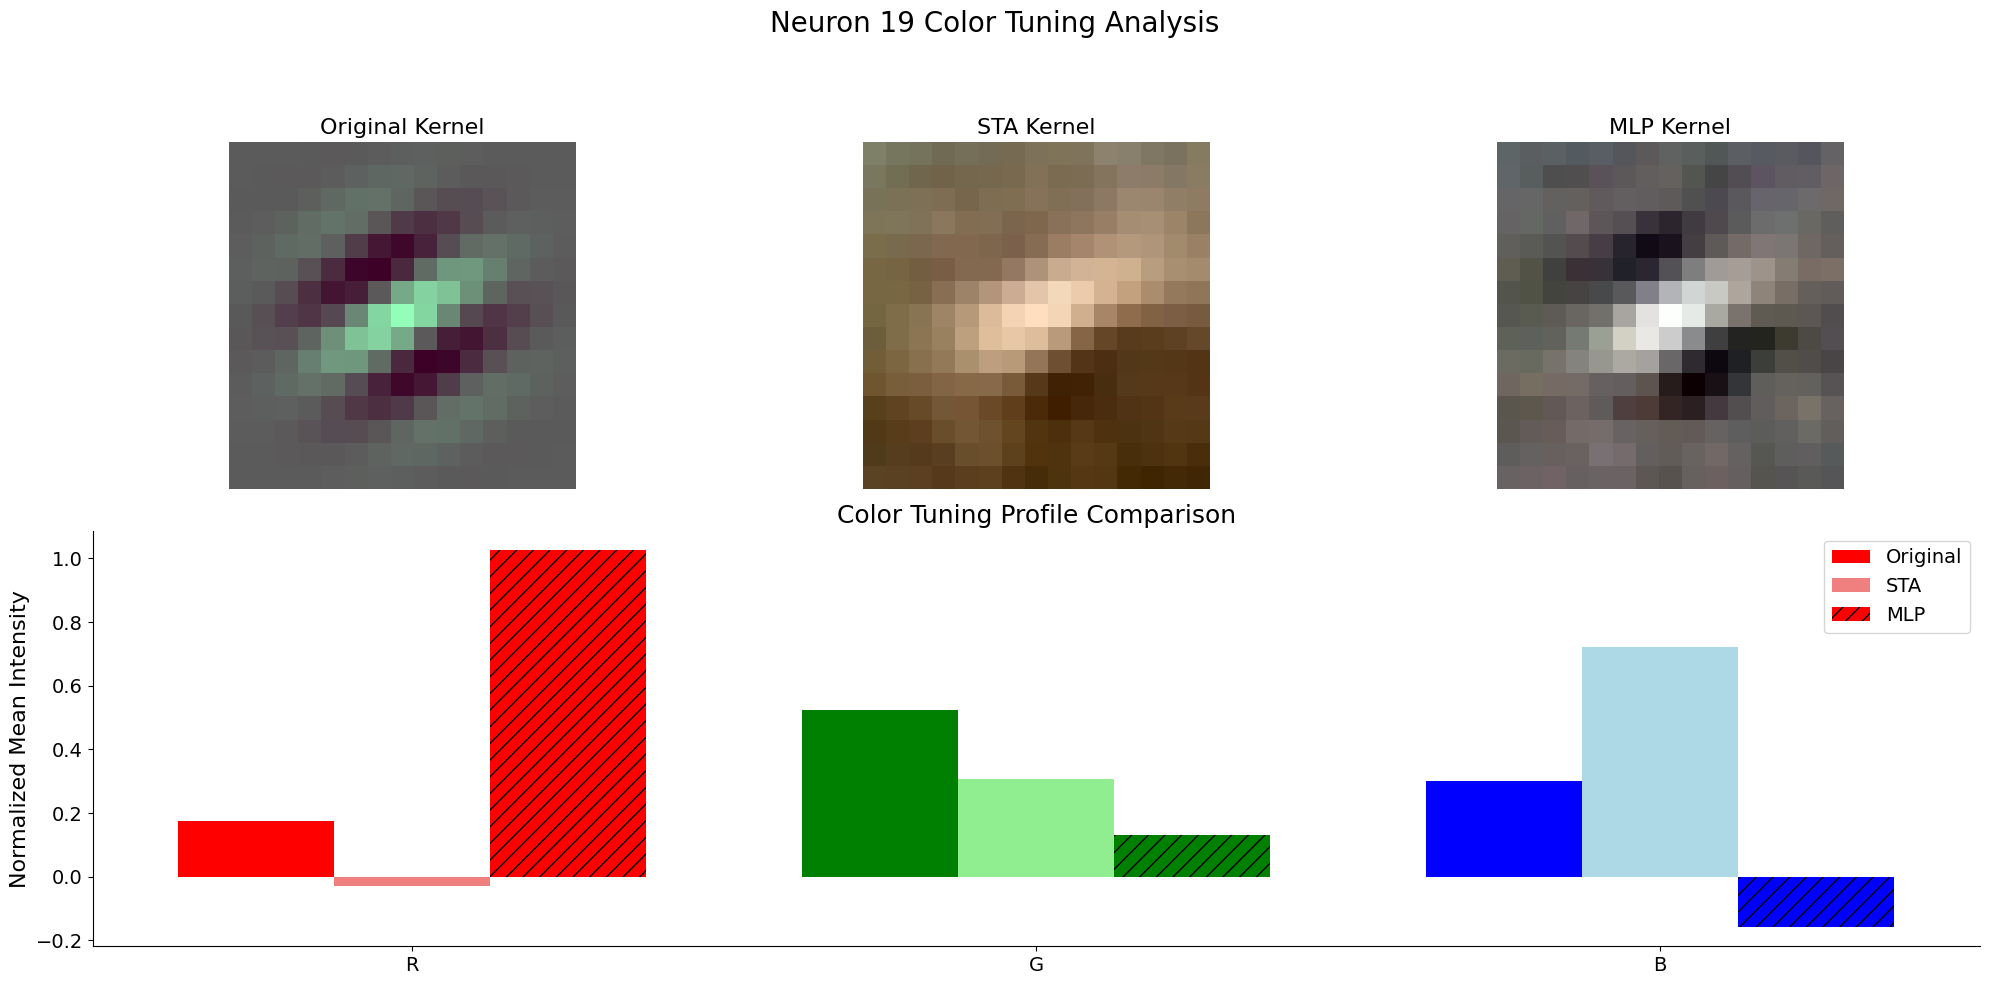

Neuron 19 Color Profiles:
  Original: [0.17489259 0.52475049 0.30035548]
  STA:      [-0.02932018  0.30691979  0.72240039]
  MLP:      [ 1.026997    0.13209705 -0.159094  ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)

def compute_color_profile(kernel):
    """
    Compute a color profile from a kernel.
    The profile is defined as the mean intensity in each channel, normalized so that the sum equals 1.

    Parameters:
      kernel : ndarray of shape (H, W, 3)

    Returns:
      profile_norm : ndarray of shape (3,)
    """
    if kernel.ndim != 3 or kernel.shape[2] != 3:
        raise ValueError("Kernel must be a color image with 3 channels.")
    profile = np.mean(kernel, axis=(0, 1))
    profile_norm = profile / (np.sum(profile) + 1e-10)
    return profile_norm

# Loop over selected neurons.
for neuron in selected_neurons:
    # Retrieve STA and MLP kernels from their respective results.
    sta_full = sta_results[neuron]
    mlp_full = mlp_weights[neuron]

    # Retrieve original kernel info from v1_cells: (original_kernel, freq, size, coords)
    original_kernel, freq, size, coords = v1_cells[neuron]

    # Crop the STA and MLP results to the receptive field.
    cropped_sta = sta_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    cropped_mlp = mlp_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # Compute color profiles.
    profile_orig = compute_color_profile(original_kernel)
    profile_sta = compute_color_profile(cropped_sta)
    profile_mlp = compute_color_profile(cropped_mlp)

    # === Plotting ===
    # Create a figure with two rows:
    # Top row: Three images (Original, STA, MLP) in that order.
    # Bottom row: Grouped bar plot for the three color profiles.
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])

    # Top row images:
    ax_orig = fig.add_subplot(gs[0, 0])
    ax_orig.imshow(norm_img(original_kernel))
    ax_orig.set_title("Original Kernel", fontsize=16)
    ax_orig.axis("off")

    ax_sta = fig.add_subplot(gs[0, 1])
    ax_sta.imshow(norm_img(cropped_sta))
    ax_sta.set_title("STA Kernel", fontsize=16)
    ax_sta.axis("off")

    ax_mlp = fig.add_subplot(gs[0, 2])
    ax_mlp.imshow(norm_img(cropped_mlp))
    ax_mlp.set_title("MLP Kernel", fontsize=16)
    ax_mlp.axis("off")

    # Bottom row: Grouped bar plot for color profiles.
    ax_bar = fig.add_subplot(gs[1, :])
    channels = ['R', 'G', 'B']
    x = np.arange(len(channels))
    width = 0.25  # width of each bar

    # Original: full colors.
    colors_orig = ['red', 'green', 'blue']
    bars_orig = ax_bar.bar(x - width, profile_orig, width, color=colors_orig, label="Original")

    # STA: lighter (shaded) colors.
    colors_sta = ['lightcoral', 'lightgreen', 'lightblue']
    bars_sta = ax_bar.bar(x, profile_sta, width, color=colors_sta, label="STA")

    # MLP: full colors with hatched lines.
    bars_mlp = ax_bar.bar(x + width, profile_mlp, width, color=colors_orig, hatch='//', label="MLP")

    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(channels, fontsize=14)
    ax_bar.set_ylabel("Normalized Mean Intensity", fontsize=16)
    ax_bar.set_title("Color Tuning Profile Comparison", fontsize=18)
    ax_bar.legend(fontsize=14)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.tick_params(axis='both', which='major', labelsize=14)

    plt.suptitle(f"Neuron {neuron} Color Tuning Analysis", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # Optionally, print the computed profiles.
    print(f"Neuron {neuron} Color Profiles:")
    print(f"  Original: {profile_orig}")
    print(f"  STA:      {profile_sta}")
    print(f"  MLP:      {profile_mlp}")


# Simulating V1 neurons

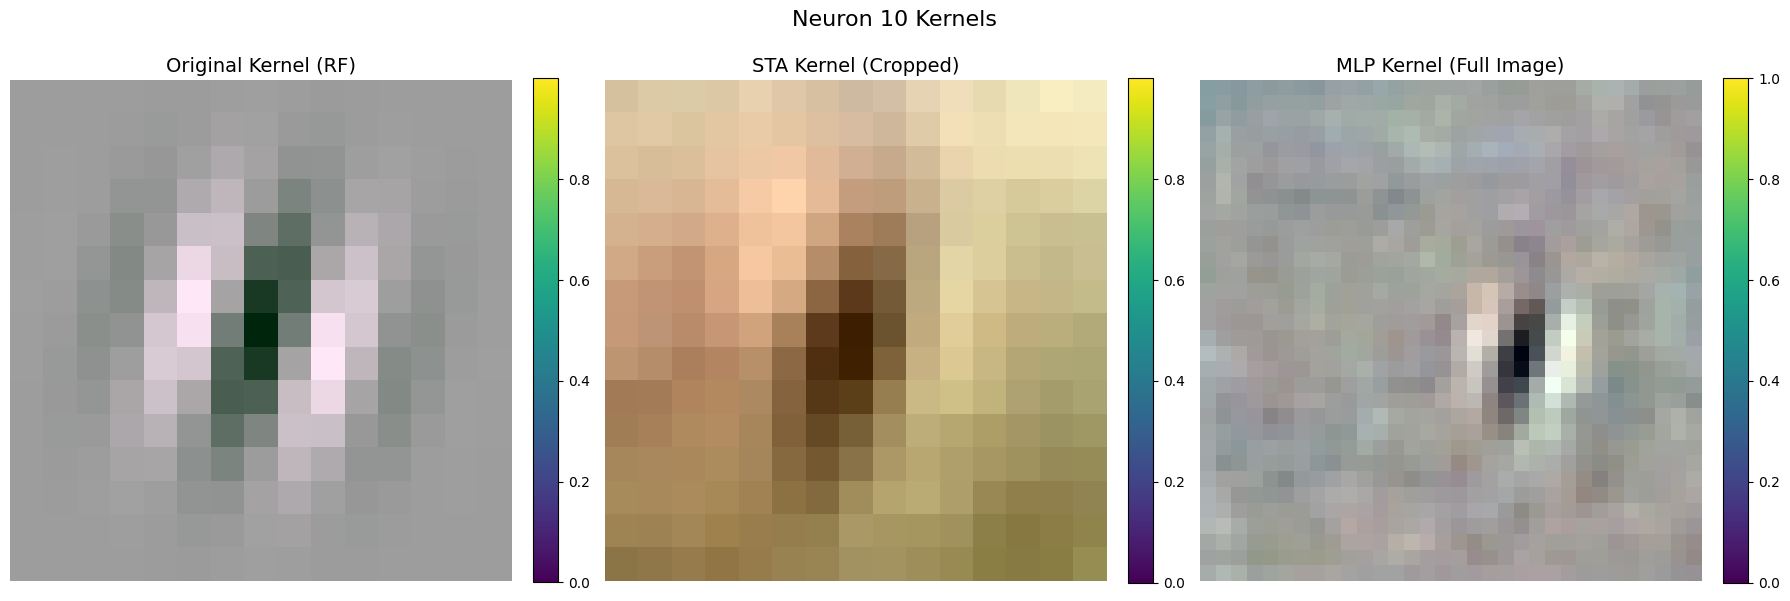

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load 100 images from CIFAR-10 (test set) and normalize to [0,1]
(_, _), (x_test, _) = cifar10.load_data()
stimuli = x_test[:100].astype(np.float32) / 255.0  # shape: (100, 32, 32, 3)



def normalize_predictions(pred):
    """Normalize predictions to the range [0, 10]."""
    pred_min = np.min(pred)
    pred_max = np.max(pred)
    return 10 * (pred - pred_min) / (pred_max - pred_min + 1e-10)

# --- Use neuron 10 for simulation ---
neuron = selected_neurons[15]

# Retrieve RF parameters for the neuron.
original_kernel, freq, size, coords = v1_cells[neuron]

# For STA, crop the full STA result to the RF region.
sta_full = sta_results[neuron]
cropped_sta = sta_full[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

# Unnormalize the STA by adding back the mean patch.
mean_stimulus = np.mean(stimuli, axis=0)
mean_patch = mean_stimulus[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
sta_unnorm = cropped_sta + mean_patch

# For MLP, the kernel is applied to the full image.
mlp_kernel = mlp_weights[neuron]

import matplotlib.pyplot as plt

# Plot the three kernels for neuron 10.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Kernel (RF)
im0 = axes[0].imshow(norm_img(original_kernel), cmap='viridis', interpolation='nearest')
axes[0].set_title("Original Kernel (RF)", fontsize=14)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# STA Kernel (cropped)
im1 = axes[1].imshow(norm_img(cropped_sta), cmap='viridis', interpolation='nearest')
axes[1].set_title("STA Kernel (Cropped)", fontsize=14)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# MLP Kernel (full image)
im2 = axes[2].imshow(norm_img(mlp_kernel), cmap='viridis', interpolation='nearest')
axes[2].set_title("MLP Kernel (Full Image)", fontsize=14)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle("Neuron 10 Kernels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



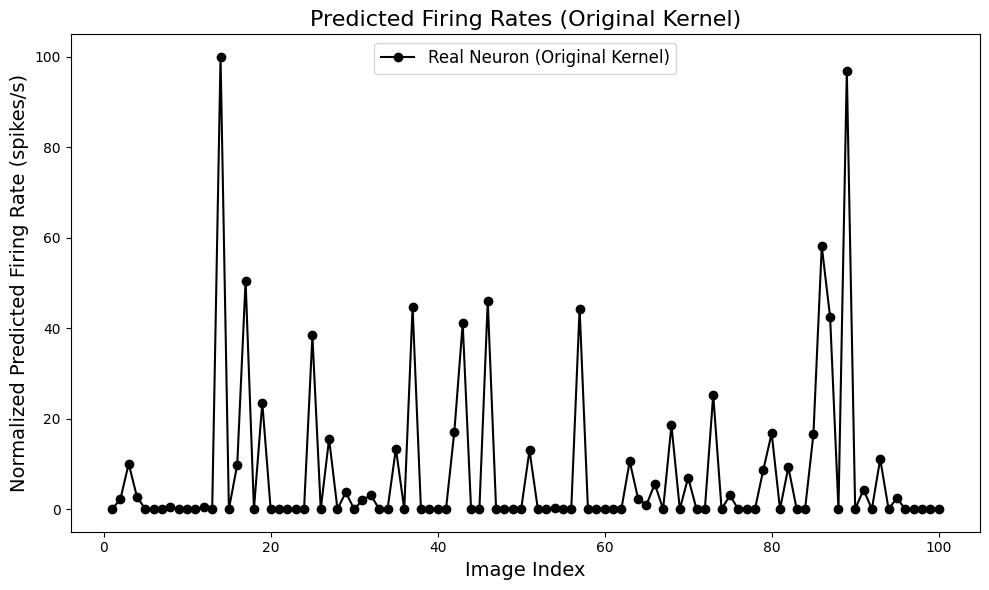

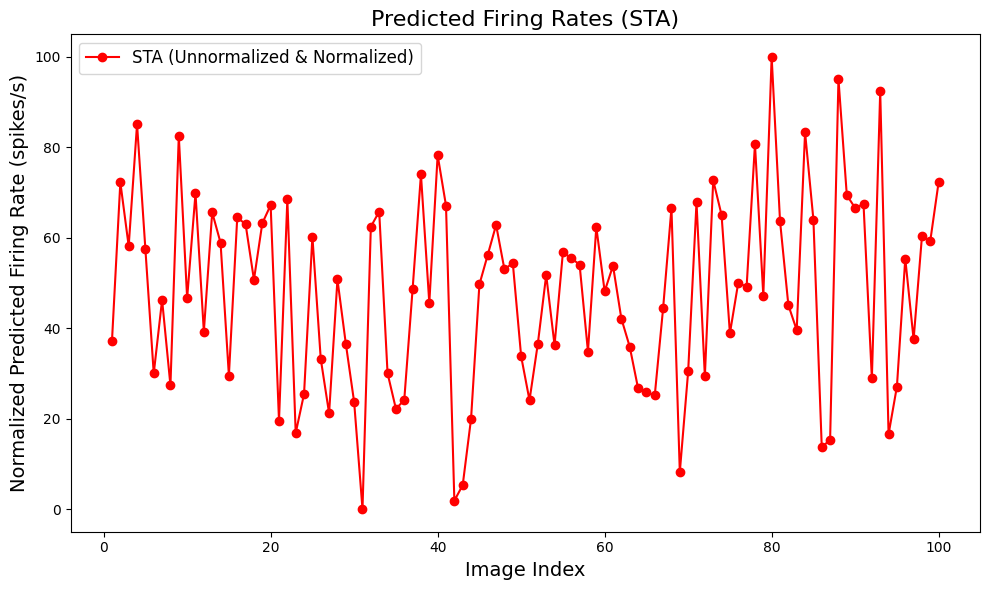

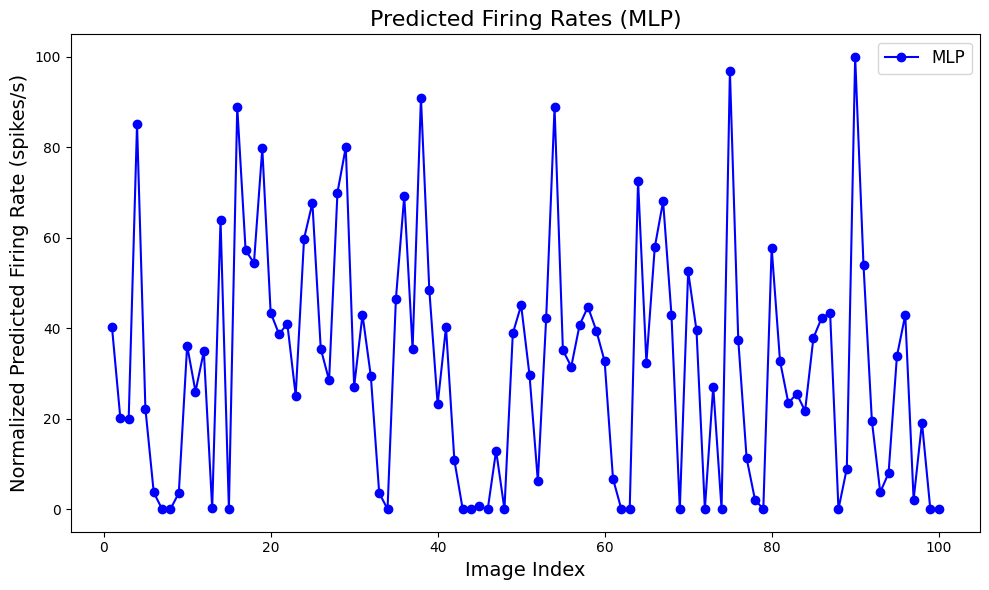

In [ ]:

# --- Simulate responses for 100 images ---
responses_original = []
responses_sta = []
responses_mlp = []

# For MLP predictions, choose a target neuron (using the first index from selected_neurons)
neuron_idx = selected_neurons[12]

for img in stimuli[:100]:
    # Extract the receptive field patch for original and STA responses.
    patch = img[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    resp_orig = np.maximum(0, np.sum(patch * original_kernel))
    resp_sta  = np.maximum(0, np.sum(patch * sta_unnorm))

    # For the MLP, ensure the image is preprocessed exactly as in training:
    # flatten the full image; add any necessary normalization here if applied during training.
    img_flat = img.reshape(1, -1)
    pred = model.predict(img_flat, verbose=0)  # model output already passes through ReLU
    resp_mlp = pred[0, neuron_idx]

    responses_original.append(resp_orig)
    responses_sta.append(resp_sta)
    responses_mlp.append(resp_mlp)

responses_original = np.array(responses_original)
responses_sta = np.array(responses_sta)
responses_mlp = np.array(responses_mlp)

# Normalize each set of predictions to be between 0 and 10.
norm_responses_original = normalize_predictions(responses_original) * 10
norm_responses_sta = normalize_predictions(responses_sta) * 10
norm_responses_mlp = normalize_predictions(responses_mlp) * 10

# Use 100 bins corresponding to the 100 images.
bins_idx = np.arange(1, 101)

# --- Plot normalized responses from the Original Kernel ---
plt.figure(figsize=(10, 6))
plt.plot(bins_idx, norm_responses_original, 'ko-', label="Real Neuron (Original Kernel)")
plt.xlabel("Image Index", fontsize=14)
plt.ylabel("Normalized Predicted Firing Rate (spikes/s)", fontsize=14)
plt.title("Predicted Firing Rates (Original Kernel)", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot normalized responses from the STA ---
plt.figure(figsize=(10, 6))
plt.plot(bins_idx, norm_responses_sta, 'ro-', label="STA (Unnormalized & Normalized)")
plt.xlabel("Image Index", fontsize=14)
plt.ylabel("Normalized Predicted Firing Rate (spikes/s)", fontsize=14)
plt.title("Predicted Firing Rates (STA)", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot normalized responses from the MLP ---
plt.figure(figsize=(10, 6))
plt.plot(bins_idx, norm_responses_mlp, 'bo-', label="MLP")
plt.xlabel("Image Index", fontsize=14)
plt.ylabel("Normalized Predicted Firing Rate (spikes/s)", fontsize=14)
plt.title("Predicted Firing Rates (MLP)", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


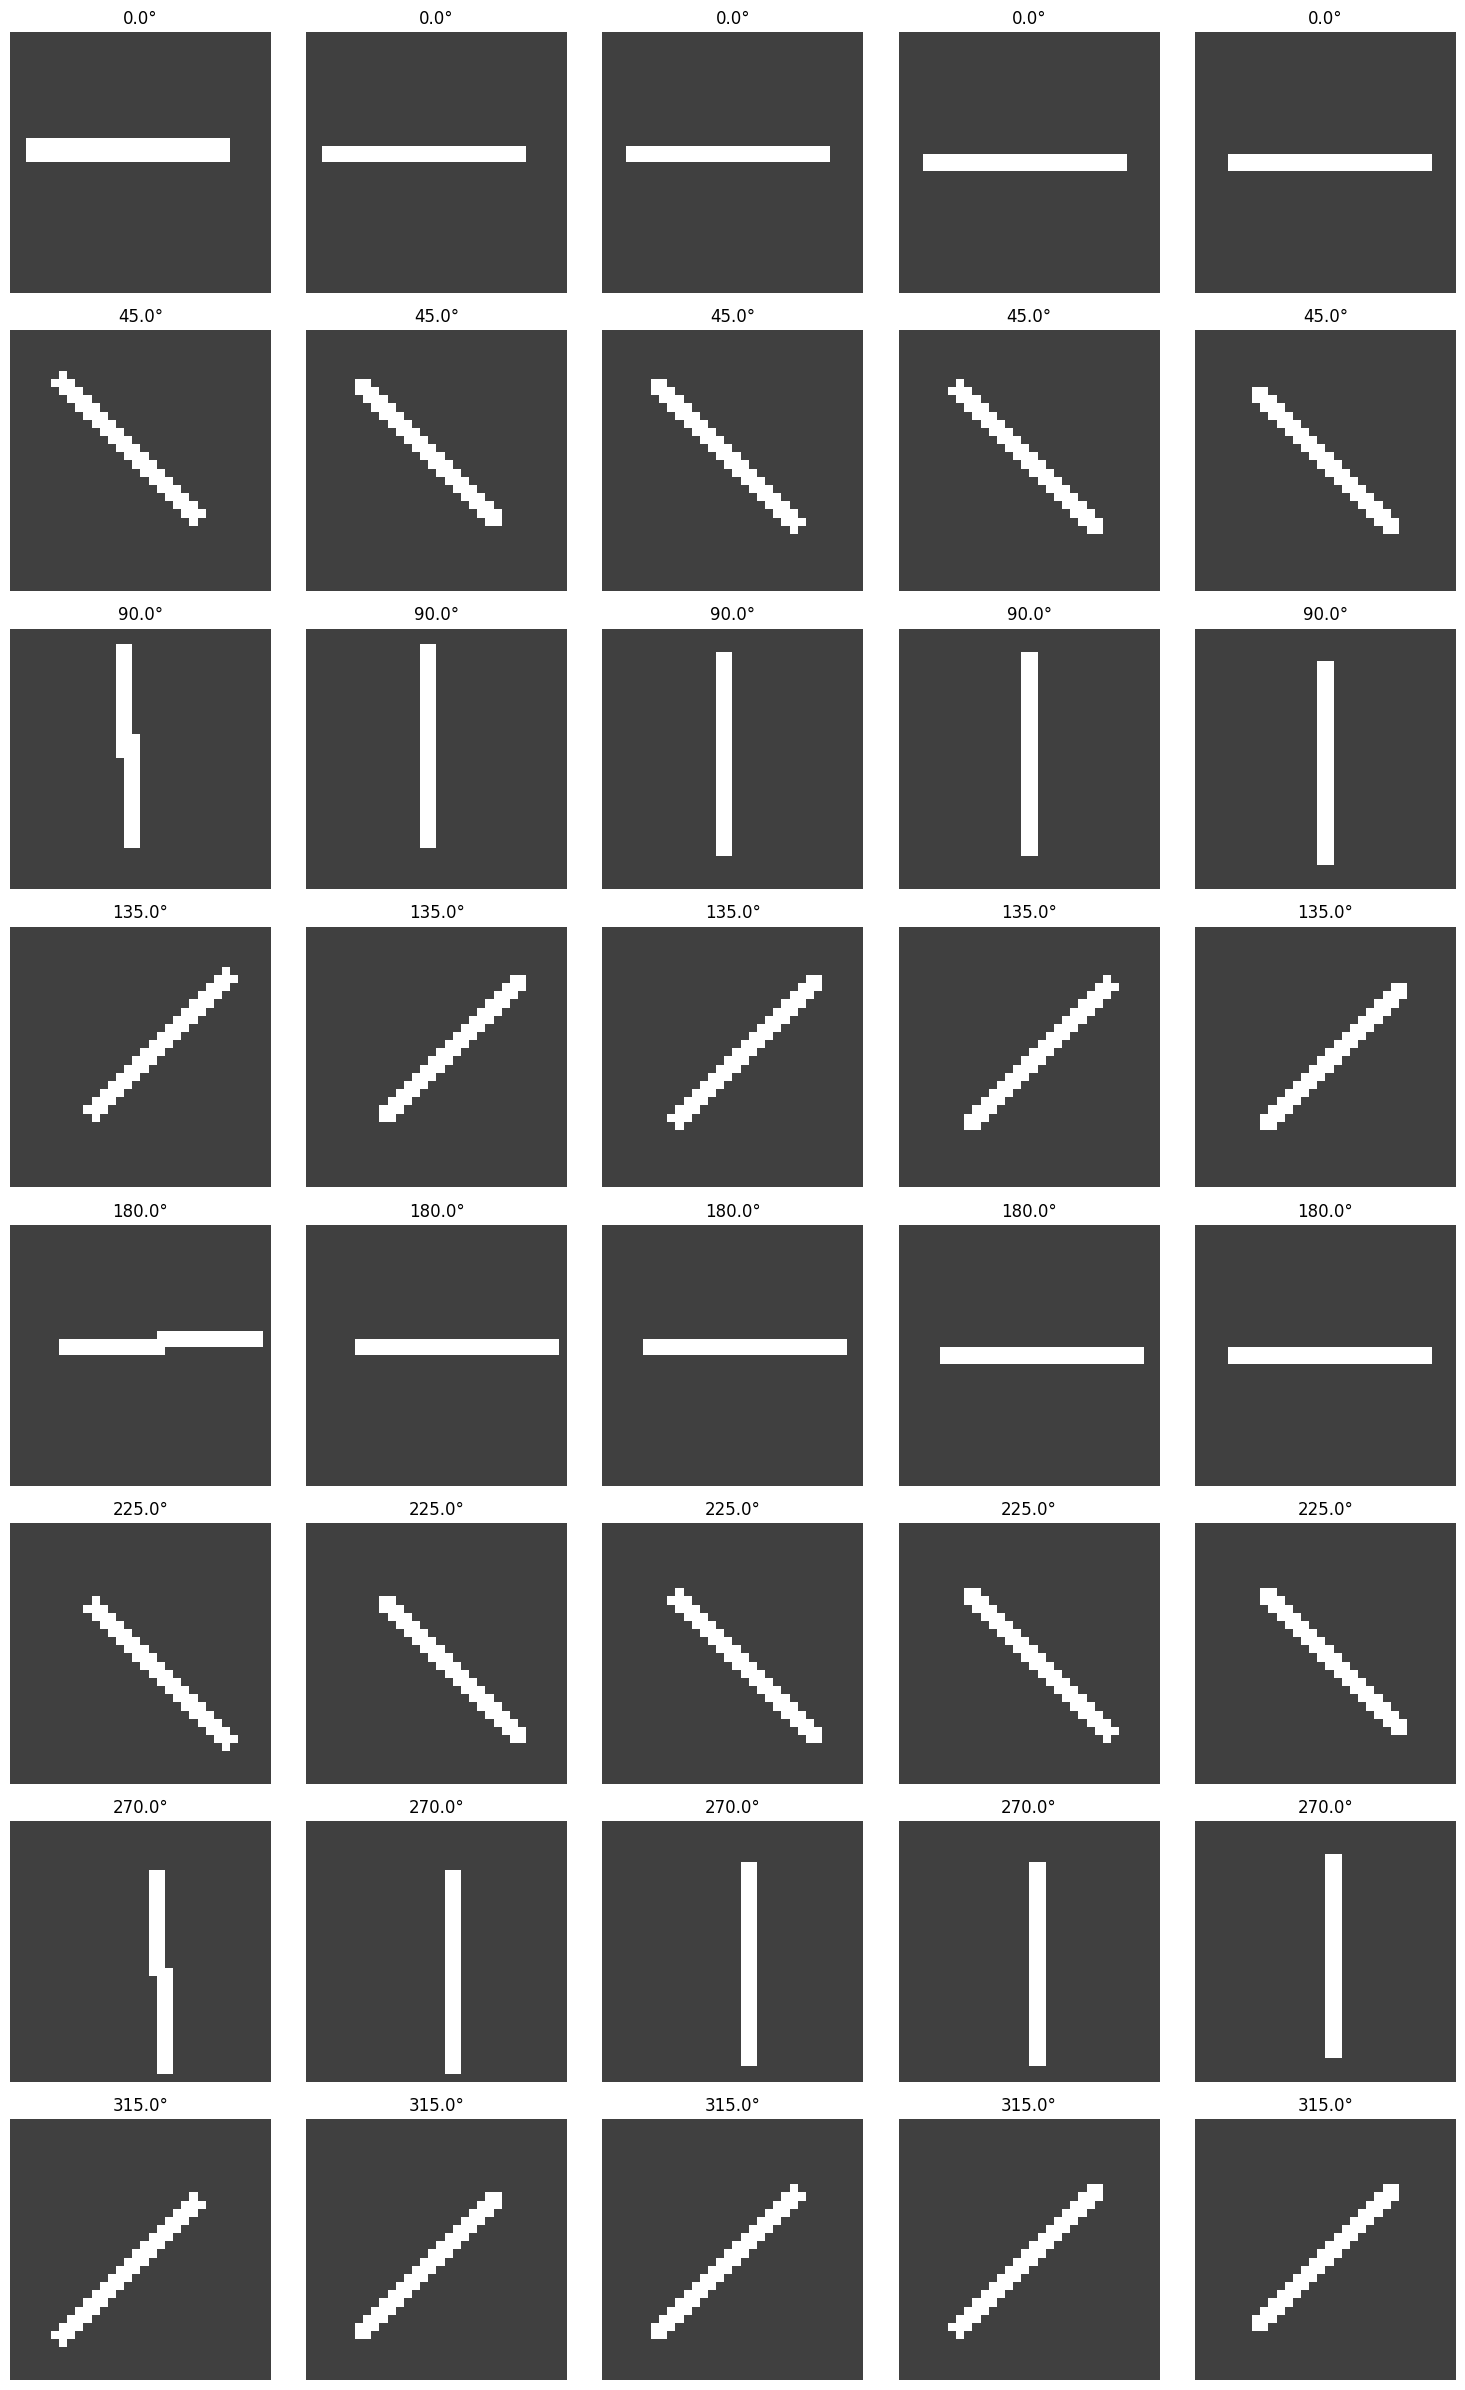

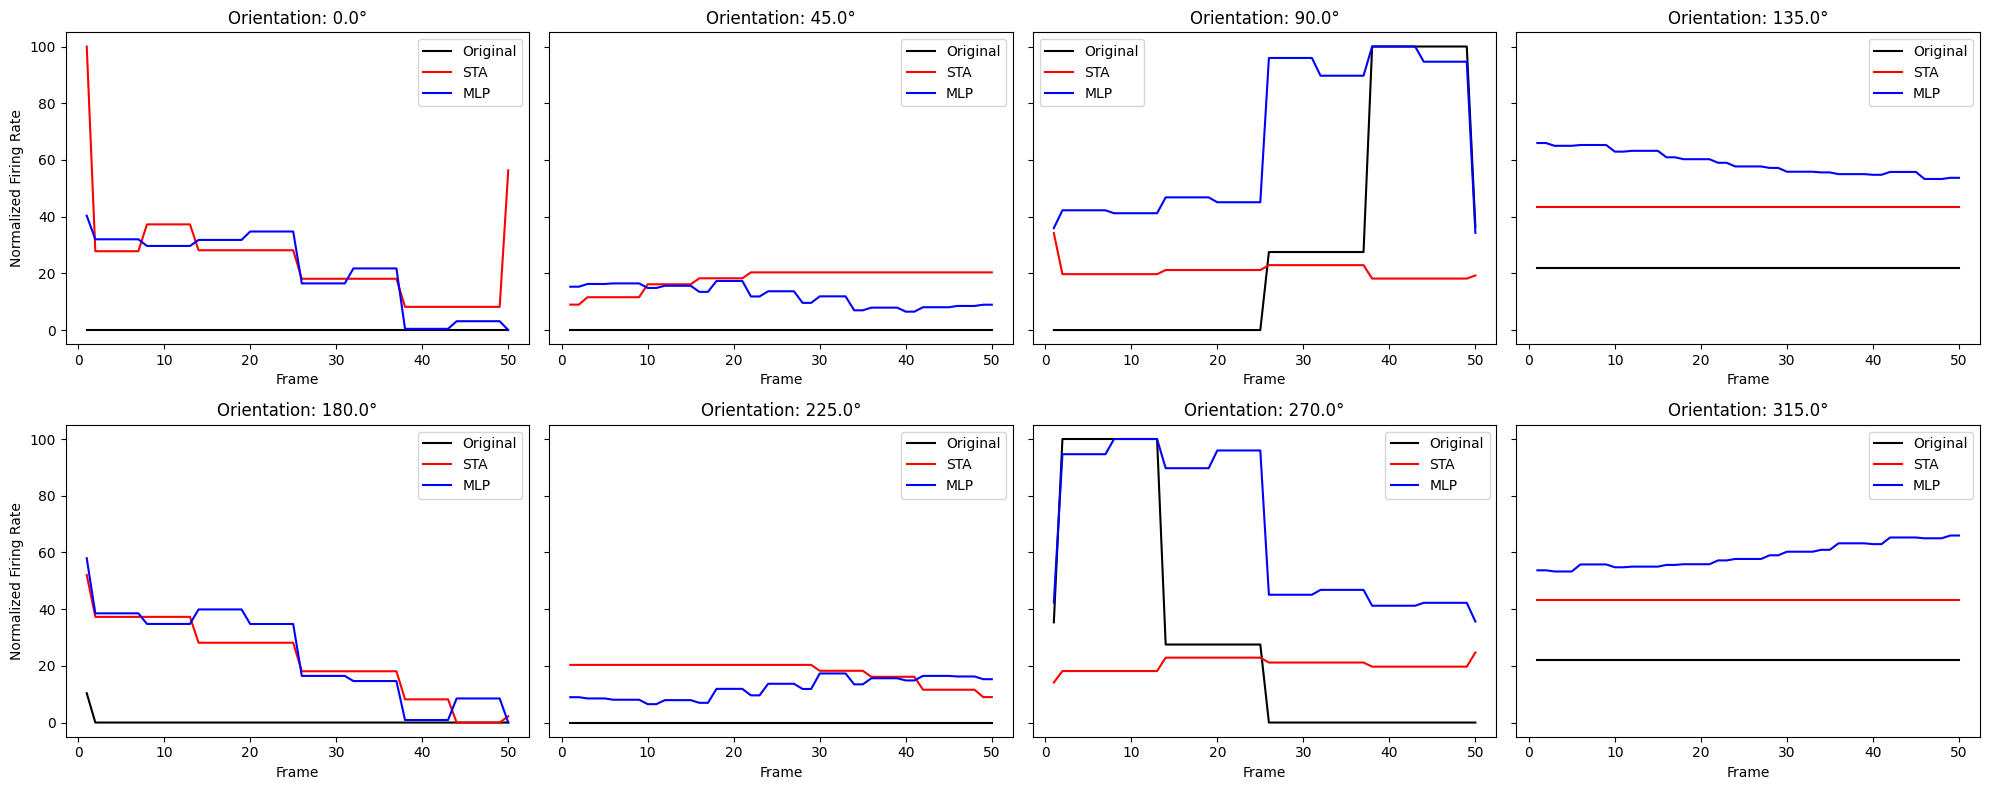

In [ ]:
# Parameters for synthetic dataset (CIFAR-like images)
n_orientations = 8
frames_per_orientation = 50
img_H, img_W, img_C = 32, 32, 3
background_intensity = int(128 / 2)  # gray background
bar_length = 25             # length of the bar in pixels
bar_thickness = 2           # thickness of the bar in pixels

# Function to draw a rotated bar (using distance to the line)
def draw_bar(image, center, angle, length, thickness, color):
    H, W, _ = image.shape
    y_grid, x_grid = np.ogrid[:H, :W]
    x0, y0 = center
    dx = np.cos(angle)
    dy = np.sin(angle)
    # Projection of each pixel onto the bar's direction
    proj = ((x_grid - x0) * dx + (y_grid - y0) * dy)
    # Distance perpendicular to the bar
    perp = (-(x_grid - x0) * dy + (y_grid - y0) * dx)
    mask = (np.abs(proj) <= length/2) & (np.abs(perp) <= thickness/2)
    for c in range(3):
        image[..., c][mask] = color[c]
    return image

# Create dataset: a list of images and corresponding orientation labels.
synthetic_stimuli = []
orientations_list = []

for i in range(n_orientations):
    angle = i * np.pi/4  # 0, 45, 90, ... 315 degrees (in radians)
    margin = int(np.ceil(bar_length/2)) + 1
    if np.cos(angle) >= 0:
        x_start, x_end = margin, img_W - margin
    else:
        x_start, x_end = img_W - margin, margin
    if np.sin(angle) >= 0:
        y_start, y_end = margin, img_H - margin
    else:
        y_start, y_end = img_H - margin, margin

    # Create a linear trajectory for the bar's center.
    xs = np.linspace(x_start, x_end, frames_per_orientation)
    ys = np.linspace(y_start, y_end, frames_per_orientation)

    for j in range(frames_per_orientation):
        # Create a gray background image.
        img = np.ones((img_H, img_W, img_C), dtype=np.uint8) * background_intensity
        center = (xs[j], ys[j])
        # Draw the bar in white.
        img = draw_bar(img, center, angle, bar_length, bar_thickness, [255, 255, 255])
        synthetic_stimuli.append(img)
        orientations_list.append(angle)

synthetic_stimuli = np.array(synthetic_stimuli)  # (n_orientations*frames_per_orientation, 32, 32, 3)
orientations_list = np.array(orientations_list)

# Display 5 sample frames per orientation (take every 5th frame from each set)
fig, axes = plt.subplots(n_orientations, 5, figsize=(15, 3*n_orientations))
for i in range(n_orientations):
    for j in range(5):
        idx = i * frames_per_orientation + j*5
        axes[i, j].imshow(synthetic_stimuli[idx])
        axes[i, j].set_title(f"{(orientations_list[idx]*180/np.pi):.1f}°")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# --- Compute responses using the three models ---
responses_original = []
responses_sta = []
responses_mlp = []

# For MLP predictions, choose a target neuron (using a specific index from selected_neurons)
neuron_idx = selected_neurons[15]

for img in synthetic_stimuli:
    # For original and STA, extract a patch based on predefined coords and size.
    patch = img[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]
    resp_orig = np.maximum(0, np.sum(patch * original_kernel))
    resp_sta  = np.maximum(0, np.sum(patch * sta_unnorm))

    # For the MLP: convert image to float32 and normalize to [-1,1]
    img_norm = (img.astype(np.float32) / 255.0) * 2 - 1
    img_flat = img_norm.reshape(1, -1)
    pred = model.predict(img_flat, verbose=0)  # model output already passes through ReLU if needed
    resp_mlp = pred[0, neuron_idx]

    responses_original.append(resp_orig)
    responses_sta.append(resp_sta)
    responses_mlp.append(resp_mlp)

responses_original = np.array(responses_original)
responses_sta = np.array(responses_sta)
responses_mlp = np.array(responses_mlp)

# Normalize each set of predictions to be between 0 and 10.
norm_responses_original = normalize_predictions(responses_original) * 10
norm_responses_sta = normalize_predictions(responses_sta) * 10
norm_responses_mlp = normalize_predictions(responses_mlp) * 10

# --- Plot firing rates for each orientation ---
# Create a subplot grid (2 rows x 4 columns) for the 8 orientations.
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharey=True)
for i in range(n_orientations):
    ax = axes[i // 4, i % 4]
    idx_start = i * frames_per_orientation
    idx_end = idx_start + frames_per_orientation
    frames = np.arange(1, frames_per_orientation + 1)

    ax.plot(frames, norm_responses_original[idx_start:idx_end], 'k-', label="Original")
    ax.plot(frames, norm_responses_sta[idx_start:idx_end], 'r-', label="STA")
    ax.plot(frames, norm_responses_mlp[idx_start:idx_end], 'b-', label="MLP")

    ax.set_title(f"Orientation: {orientations_list[idx_start]*180/np.pi:.1f}°")
    ax.set_xlabel("Frame")
    if i % 4 == 0:
        ax.set_ylabel("Normalized Firing Rate")
    ax.legend()
plt.tight_layout()
plt.show()


# Exporting Huber and Wiesel experiment

In [ ]:
import os
import matplotlib.animation as animation
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define output directory and ensure it exists
output_dir = '/content/drive/MyDrive'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "hub_and_wiesel.mp4")

# Total number of frames in the synthetic dataset.
n_frames = synthetic_stimuli.shape[0]

# Create figure with two subplots: stimulus (left) and response (right).
fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(12, 6))

# --- Left subplot: Show the stimulus image ---
im = ax_img.imshow(synthetic_stimuli[0])
ax_img.set_title("Synthetic Stimulus")
ax_img.axis('off')

# --- Right subplot: Show the responses as a bar plot ---
labels = ["Original", "STA", "MLP"]
# Use a thicker bar (increase width)
bar_width = 0.8
initial_heights = [norm_responses_original[0], norm_responses_sta[0], norm_responses_mlp[0]]
bars = ax_bar.bar(labels, initial_heights, color=["k", "r", "b"], width=bar_width)
ax_bar.set_ylim(0, max(norm_responses_original.max(), norm_responses_sta.max(), norm_responses_mlp.max()) * 1.2)
ax_bar.set_ylabel("Normalized Firing Rate (spikes/s)")
ax_bar.set_title("Model Responses (Vertical Update Only)")
# Fix the x-limits so bars remain at fixed horizontal positions.
ax_bar.set_xlim(-0.5, len(labels)-0.5)

# Function to update the frame for animation.
def update(frame):
    # Update the stimulus image.
    im.set_data(synthetic_stimuli[frame])

    # Update bar heights (vertical movement only).
    heights = [norm_responses_original[frame], norm_responses_sta[frame], norm_responses_mlp[frame]]
    for bar, h in zip(bars, heights):
        bar.set_height(h)

    # Update the figure title with the current frame.
    fig.suptitle(f"Frame {frame+1}/{n_frames}", fontsize=16)
    return [im, *bars]

# Create the animation.
anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=100, blit=True)


# Save the animation as an MP4 file to Google Drive.
Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, metadata=dict(artist="Your Name"), bitrate=1800)
anim.save(output_path, writer=writer)

plt.close(fig)
print(f"Video saved to {output_path}")

Mounted at /content/drive
Video saved to /content/drive/MyDrive/hub_and_wiesel.mp4


In [ ]:

# Display a link to search for the video in your Google Drive.
# This link searches for "hub_and_wiesel" in your Drive.
video_search_url = "https://drive.google.com/drive/search?q=hub_and_wiesel"
display(HTML(f'<a href="{video_search_url}" target="_blank" style="font-size:18px;">Click here to open your Hub_and_Wiesel video in Google Drive</a>'))
